# Generate Species for Low Temperature Pathways

The goal of this notebook is to allow you to generate all the species that would occur by systematically applying known low-temperature pathways to a starting fuel molecule(s).

You might do this to generate species that you then put into an RMG input file, to help RMG find the low temperature pathways. An RMG input file species block is generated at the end, to facilitate this.

These are the pathways, from https://doi.org/10.1016/j.combustflame.2015.07.005
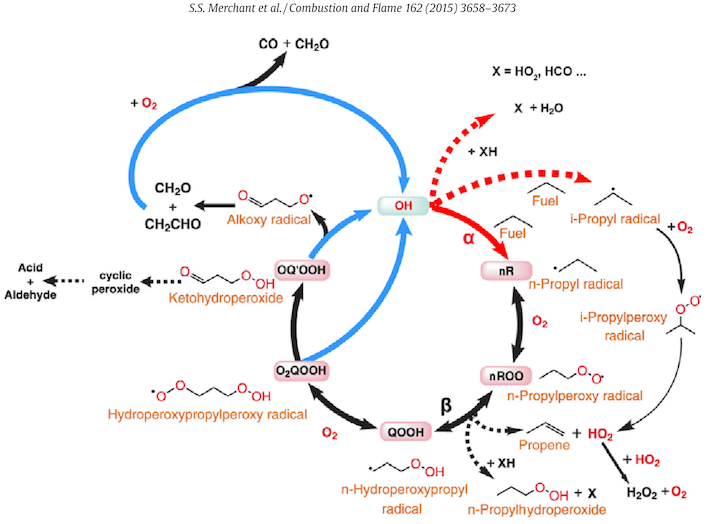

In [1]:
import sys, os
sys.path.insert(0,os.path.expandvars("$RMGpy"))

In [2]:
from rmgpy.rmg.main import RMG
from rmgpy.rmg.model import CoreEdgeReactionModel
from rmgpy import settings
from IPython.display import display
from arkane.output import prettify

Declare database variables here by changing the thermo and reaction libraries. These are not actually used.

In [3]:
database = """
database(
    thermoLibraries = ['BurkeH2O2','primaryThermoLibrary','DFT_QCI_thermo','CBS_QB3_1dHR'],
    reactionLibraries = [],
    seedMechanisms = [],
    kineticsDepositories = ['training'],
    kineticsFamilies = [
        'H_Abstraction',
        'R_Recombination',
        'R_Addition_MultipleBond',
        'intra_H_migration',
        'HO2_Elimination_from_PeroxyRadical',
        'intra_OH_migration',
    ],
    kineticsEstimator = 'rate rules',
)

options(
    verboseComments=True,  # Set to True for detailed kinetics comments
)
"""

Just put O2 in the model for now

In [4]:
speciesList = """
species(
    label='O2',
    reactive=True,
    structure=SMILES("[O][O]")
)
"""

In [5]:
# Write input file to disk
os.makedirs('temp', exist_ok=True)
inputFile = open('temp/input.py','w')
inputFile.write(database)
inputFile.write(speciesList)
inputFile.close()

In [6]:
# initialize RMG instance
# This does all the hard work of loading the databases etc.
# which can take a while
from rmgpy.tools.generate_reactions import RMG
kwargs = {
            'restart': '',
            'walltime': '00:00:00:00',
            'kineticsdatastore': True
    }
rmg = RMG(input_file='temp/input.py', output_directory='temp')

rmg.initialize(**kwargs)


In [7]:
from rmgpy.molecule import Molecule

In [8]:
from collections import defaultdict
molecules = defaultdict(set)

def union(*args):
    out = set()
    for a in args:
        out.update(molecules[a])
    return out

# Put your fuel molecule(s) here:

In [9]:
# you may have more than one if you wish, just repeat this line
molecules['fuel'].add(Molecule(smiles='CCCCCCCCCC'))

In [10]:
for m in molecules['fuel']:
    display(m)

# ☝️☝️☝️☝️☝️☝️☝️☝️

In [11]:
molecules['H'].add(Molecule(smiles='[H]'))
molecules

defaultdict(set,
            {'fuel': {Molecule(smiles="CCCCCCCCCC")},
             'H': {Molecule(smiles="[H]")}})

In [12]:
union('fuel','H')

{Molecule(smiles="[H]"), Molecule(smiles="CCCCCCCCCC")}

In [13]:
# React fuel with H via H_Abstraction to get the radicals R

h = list(molecules['H'])[0]
for s in molecules['fuel']:
    reactions = rmg.database.kinetics.generate_reactions_from_families((s, h), only_families='H_Abstraction')
    for r in reactions:
        print(r)
        m = r.products[1].molecule[0]
        display(m)
        molecules['R'].add(m)
molecules

[H] + CCCCCCCCCC <=> [H][H] + CC[CH]CCCCCCC


[H] + CCCCCCCCCC <=> [H][H] + CCC[CH]CCCCCC


[H] + CCCCCCCCCC <=> [H][H] + CCCC[CH]CCCCC


[H] + CCCCCCCCCC <=> [H][H] + C[CH]CCCCCCCC


[H] + CCCCCCCCCC <=> [H][H] + [CH2]CCCCCCCCC


defaultdict(set,
            {'fuel': {Molecule(smiles="CCCCCCCCCC")},
             'H': {Molecule(smiles="[H]")},
             'R': {Molecule(smiles="CCCC[CH]CCCCC"),
              Molecule(smiles="CCC[CH]CCCCCC"),
              Molecule(smiles="[CH2]CCCCCCCCC"),
              Molecule(smiles="C[CH]CCCCCCCC"),
              Molecule(smiles="CC[CH]CCCCCCC")}})

In [14]:
molecules['O2'].add(Molecule(smiles='[O][O]'))
molecules

defaultdict(set,
            {'fuel': {Molecule(smiles="CCCCCCCCCC")},
             'H': {Molecule(smiles="[H]")},
             'R': {Molecule(smiles="CCCC[CH]CCCCC"),
              Molecule(smiles="CCC[CH]CCCCCC"),
              Molecule(smiles="[CH2]CCCCCCCCC"),
              Molecule(smiles="C[CH]CCCCCCCC"),
              Molecule(smiles="CC[CH]CCCCCCC")},
             'O2': {Molecule(smiles="[O][O]")}})

[O][O] + CCCC[CH]CCCCC <=> CCCCCC(CCCC)O[O]


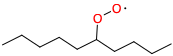

[O][O] + CCC[CH]CCCCCC <=> CCCCCCC(CCC)O[O]


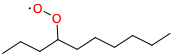

[O][O] + [CH2]CCCCCCCCC <=> CCCCCCCCCCO[O]


[O][O] + C[CH]CCCCCCCC <=> CCCCCCCCC(C)O[O]


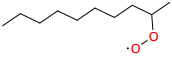

[O][O] + CC[CH]CCCCCCC <=> CCCCCCCC(CC)O[O]


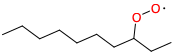

defaultdict(set,
            {'fuel': {Molecule(smiles="CCCCCCCCCC")},
             'H': {Molecule(smiles="[H]")},
             'R': {Molecule(smiles="CCCC[CH]CCCCC"),
              Molecule(smiles="CCC[CH]CCCCCC"),
              Molecule(smiles="[CH2]CCCCCCCCC"),
              Molecule(smiles="C[CH]CCCCCCCC"),
              Molecule(smiles="CC[CH]CCCCCCC")},
             'O2': {Molecule(smiles="[O][O]")},
             'ROO': {Molecule(smiles="CCCCCCCCC(C)O[O]"),
              Molecule(smiles="CCCCCCCC(CC)O[O]"),
              Molecule(smiles="CCCCCC(CCCC)O[O]"),
              Molecule(smiles="CCCCCCCCCCO[O]"),
              Molecule(smiles="CCCCCCC(CCC)O[O]")}})

In [15]:
# React R with O2 to get the ROO
o2 = list(molecules['O2'])[0]
for s in molecules['R']:
    reactions = rmg.database.kinetics.generate_reactions_from_families((s, o2), only_families='R_Recombination')
    for r in reactions:
        print(r)
        m = r.products[0].molecule[0]
        display(m)
        molecules['ROO'].add(m)
molecules

CCCCCCCCC(C)O[O] <=> CCCCCCCC[C](C)OO


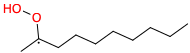

CCCCCCCCC(C)O[O] <=> CCCCCCC[CH]C(C)OO


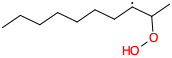

CCCCCCCCC(C)O[O] <=> [CH2]C(CCCCCCCC)OO


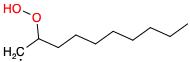

CCCCCCCCC(C)O[O] <=> CCCCCC[CH]CC(C)OO


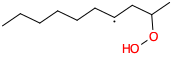

CCCCCCCCC(C)O[O] <=> CCCCC[CH]CCC(C)OO


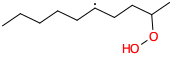

CCCCCCCCC(C)O[O] <=> CCCC[CH]CCCC(C)OO


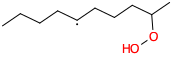

CCCCCCCCC(C)O[O] <=> CCC[CH]CCCCC(C)OO


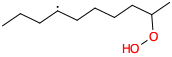

CCCCCCCC(CC)O[O] <=> CCCCCCC[C](CC)OO


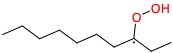

CCCCCCCC(CC)O[O] <=> CCCCCC[CH]C(CC)OO


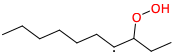

CCCCCCCC(CC)O[O] <=> C[CH]C(CCCCCCC)OO


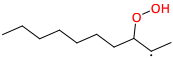

CCCCCCCC(CC)O[O] <=> CCCCC[CH]CC(CC)OO


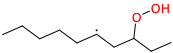

CCCCCCCC(CC)O[O] <=> [CH2]CC(CCCCCCC)OO


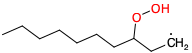

CCCCCCCC(CC)O[O] <=> CCCC[CH]CCC(CC)OO


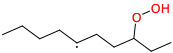

CCCCCCCC(CC)O[O] <=> CCC[CH]CCCC(CC)OO


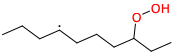

CCCCCCCC(CC)O[O] <=> CC[CH]CCCCC(CC)OO


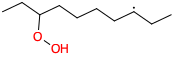

CCCCCC(CCCC)O[O] <=> CCCCC[C](CCCC)OO


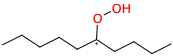

CCCCCC(CCCC)O[O] <=> CCCC[CH]C(CCCC)OO


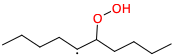

CCCCCC(CCCC)O[O] <=> CCC[CH]C(CCCCC)OO


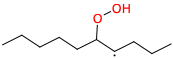

CCCCCC(CCCC)O[O] <=> CCC[CH]CC(CCCC)OO


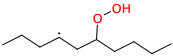

CCCCCC(CCCC)O[O] <=> CC[CH]CC(CCCCC)OO


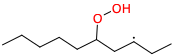

CCCCCC(CCCC)O[O] <=> CC[CH]CCC(CCCC)OO


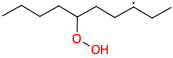

CCCCCC(CCCC)O[O] <=> C[CH]CCC(CCCCC)OO


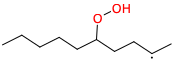

CCCCCC(CCCC)O[O] <=> C[CH]CCCC(CCCC)OO


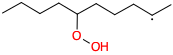

CCCCCC(CCCC)O[O] <=> [CH2]CCCC(CCCCC)OO


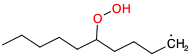

CCCCCC(CCCC)O[O] <=> [CH2]CCCCC(CCCC)OO


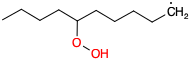

CCCCCCCCCCO[O] <=> CCCCCCCCC[CH]OO


CCCCCCCCCCO[O] <=> CCCCCCCC[CH]COO


CCCCCCCCCCO[O] <=> CCCCCCC[CH]CCOO


CCCCCCCCCCO[O] <=> CCCCCC[CH]CCCOO


CCCCCCCCCCO[O] <=> CCCCC[CH]CCCCOO


CCCCCCCCCCO[O] <=> CCCC[CH]CCCCCOO


CCCCCCC(CCC)O[O] <=> CCCCCC[C](CCC)OO


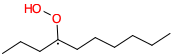

CCCCCCC(CCC)O[O] <=> CCCCC[CH]C(CCC)OO


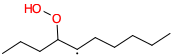

CCCCCCC(CCC)O[O] <=> CC[CH]C(CCCCCC)OO


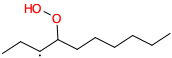

CCCCCCC(CCC)O[O] <=> CCCC[CH]CC(CCC)OO


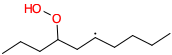

CCCCCCC(CCC)O[O] <=> C[CH]CC(CCCCCC)OO


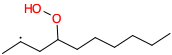

CCCCCCC(CCC)O[O] <=> CCC[CH]CCC(CCC)OO


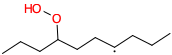

CCCCCCC(CCC)O[O] <=> [CH2]CCC(CCCCCC)OO


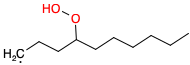

CCCCCCC(CCC)O[O] <=> CC[CH]CCCC(CCC)OO


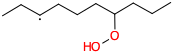

CCCCCCC(CCC)O[O] <=> C[CH]CCCCC(CCC)OO


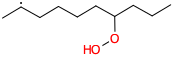

defaultdict(set,
            {'fuel': {Molecule(smiles="CCCCCCCCCC")},
             'H': {Molecule(smiles="[H]")},
             'R': {Molecule(smiles="CCCC[CH]CCCCC"),
              Molecule(smiles="CCC[CH]CCCCCC"),
              Molecule(smiles="[CH2]CCCCCCCCC"),
              Molecule(smiles="C[CH]CCCCCCCC"),
              Molecule(smiles="CC[CH]CCCCCCC")},
             'O2': {Molecule(smiles="[O][O]")},
             'ROO': {Molecule(smiles="CCCCCCCCC(C)O[O]"),
              Molecule(smiles="CCCCCCCC(CC)O[O]"),
              Molecule(smiles="CCCCCC(CCCC)O[O]"),
              Molecule(smiles="CCCCCCCCCCO[O]"),
              Molecule(smiles="CCCCCCC(CCC)O[O]")},
             'QOOH': {Molecule(smiles="C[CH]CCC(CCCCC)OO"),
              Molecule(smiles="C[CH]CCCC(CCCC)OO"),
              Molecule(smiles="[CH2]CCCC(CCCCC)OO"),
              Molecule(smiles="[CH2]CCCCC(CCCC)OO"),
              Molecule(smiles="CCCCCCCCC[CH]OO"),
              Molecule(smiles="CCCCCCCC[CH]COO"),
           

In [16]:
# Isomerize ROO to get QOOH
for s in molecules['ROO']:
    reactions = rmg.database.kinetics.generate_reactions_from_families((s, ), only_families='intra_H_migration')
    for r in reactions:
        print(r)
        m = r.products[0].molecule[0]
        display(m)
        molecules['QOOH'].add(m)
molecules

[O][O] + C[CH]CCC(CCCCC)OO <=> CCCCCC(CCC(C)O[O])OO


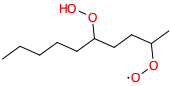

[O][O] + C[CH]CCCC(CCCC)OO <=> CCCCC(CCCC(C)O[O])OO


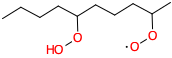

[O][O] + [CH2]CCCC(CCCCC)OO <=> CCCCCC(CCCCO[O])OO


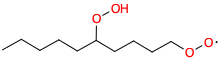

[O][O] + [CH2]CCCCC(CCCC)OO <=> CCCCC(CCCCCO[O])OO


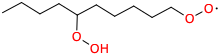

[O][O] + CCCCCCCCC[CH]OO <=> CCCCCCCCCC(O[O])OO


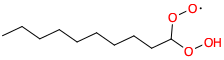

[O][O] + CCCCCCCC[CH]COO <=> CCCCCCCCC(COO)O[O]


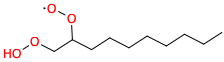

[O][O] + CCCCCCC[CH]CCOO <=> CCCCCCCC(CCOO)O[O]


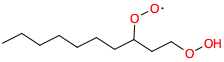

[O][O] + CCCCCC[CH]CCCOO <=> CCCCCCC(CCCOO)O[O]


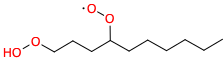

[O][O] + CCCCC[CH]CCCCOO <=> CCCCCC(CCCCOO)O[O]


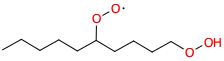

[O][O] + CCCC[CH]CCCCCOO <=> CCCCC(CCCCCOO)O[O]


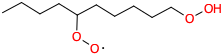

[O][O] + CCCCCC[CH]CC(C)OO <=> CCCCCCC(CC(C)OO)O[O]


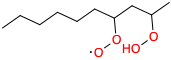

[O][O] + CCCCC[CH]CCC(C)OO <=> CCCCCC(CCC(C)OO)O[O]


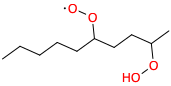

[O][O] + CCCCCCCC[C](C)OO <=> CCCCCCCCC(C)(O[O])OO


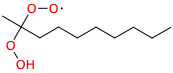

[O][O] + [CH2]C(CCCCCCCC)OO <=> CCCCCCCCC(CO[O])OO


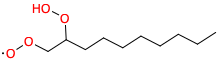

[O][O] + CCCC[CH]CCCC(C)OO <=> CCCCC(CCCC(C)OO)O[O]


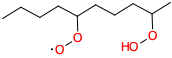

[O][O] + CCC[CH]CCCCC(C)OO <=> CCCC(CCCCC(C)OO)O[O]


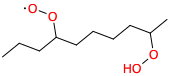

[O][O] + CCCCCCC[C](CC)OO <=> CCCCCCCC(CC)(O[O])OO


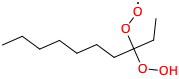

[O][O] + CCCCCC[CH]C(CC)OO <=> CCCCCCC(O[O])C(CC)OO


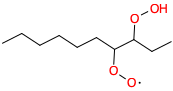

[O][O] + C[CH]C(CCCCCCC)OO <=> CCCCCCCC(OO)C(C)O[O]


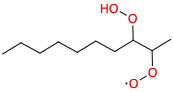

[O][O] + CCCCC[CH]CC(CC)OO <=> CCCCCC(CC(CC)OO)O[O]


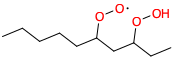

[O][O] + [CH2]CC(CCCCCCC)OO <=> CCCCCCCC(CCO[O])OO


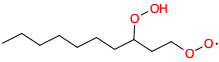

[O][O] + CCCC[CH]CCC(CC)OO <=> CCCCC(CCC(CC)OO)O[O]


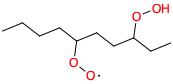

[O][O] + CCC[CH]CCCC(CC)OO <=> CCCC(CCCC(CC)OO)O[O]


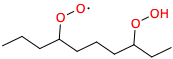

[O][O] + CC[CH]CCCCC(CC)OO <=> CCC(CCCCC(CC)OO)O[O]


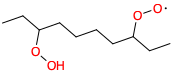

[O][O] + CCCCC[C](CCCC)OO <=> CCCCCC(CCCC)(O[O])OO


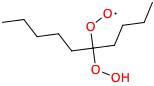

[O][O] + CCCC[CH]C(CCCC)OO <=> CCCCC(O[O])C(CCCC)OO


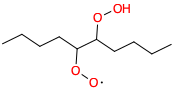

[O][O] + CCC[CH]C(CCCCC)OO <=> CCCCCC(OO)C(CCC)O[O]


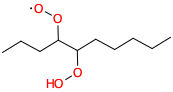

[O][O] + CCC[CH]CC(CCCC)OO <=> CCCCC(CC(CCC)O[O])OO


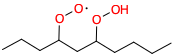

[O][O] + CCCCCCC[CH]C(C)OO <=> CCCCCCCC(O[O])C(C)OO


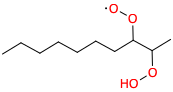

[O][O] + CC[CH]CC(CCCCC)OO <=> CCCCCC(CC(CC)O[O])OO


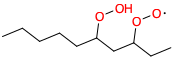

[O][O] + CCCCCC[C](CCC)OO <=> CCCCCCC(CCC)(O[O])OO


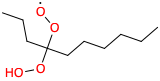

[O][O] + CCCCC[CH]C(CCC)OO <=> CCCCCC(O[O])C(CCC)OO


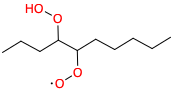

[O][O] + CC[CH]C(CCCCCC)OO <=> CCCCCCC(OO)C(CC)O[O]


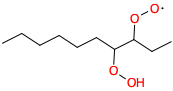

[O][O] + CCCC[CH]CC(CCC)OO <=> CCCCC(CC(CCC)OO)O[O]


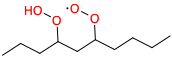

[O][O] + C[CH]CC(CCCCCC)OO <=> CCCCCCC(CC(C)O[O])OO


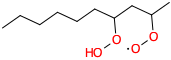

[O][O] + CCC[CH]CCC(CCC)OO <=> CCCC(CCC(CCC)OO)O[O]


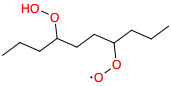

[O][O] + [CH2]CCC(CCCCCC)OO <=> CCCCCCC(CCCO[O])OO


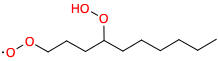

[O][O] + CC[CH]CCCC(CCC)OO <=> CCCC(CCCC(CC)O[O])OO


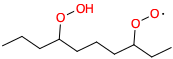

[O][O] + C[CH]CCCCC(CCC)OO <=> CCCC(CCCCC(C)O[O])OO


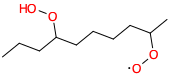

[O][O] + CC[CH]CCC(CCCC)OO <=> CCCCC(CCC(CC)O[O])OO


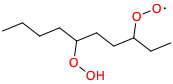

defaultdict(set,
            {'fuel': {Molecule(smiles="CCCCCCCCCC")},
             'H': {Molecule(smiles="[H]")},
             'R': {Molecule(smiles="CCCC[CH]CCCCC"),
              Molecule(smiles="CCC[CH]CCCCCC"),
              Molecule(smiles="[CH2]CCCCCCCCC"),
              Molecule(smiles="C[CH]CCCCCCCC"),
              Molecule(smiles="CC[CH]CCCCCCC")},
             'O2': {Molecule(smiles="[O][O]")},
             'ROO': {Molecule(smiles="CCCCCCCCC(C)O[O]"),
              Molecule(smiles="CCCCCCCC(CC)O[O]"),
              Molecule(smiles="CCCCCC(CCCC)O[O]"),
              Molecule(smiles="CCCCCCCCCCO[O]"),
              Molecule(smiles="CCCCCCC(CCC)O[O]")},
             'QOOH': {Molecule(smiles="C[CH]CCC(CCCCC)OO"),
              Molecule(smiles="C[CH]CCCC(CCCC)OO"),
              Molecule(smiles="[CH2]CCCC(CCCCC)OO"),
              Molecule(smiles="[CH2]CCCCC(CCCC)OO"),
              Molecule(smiles="CCCCCCCCC[CH]OO"),
              Molecule(smiles="CCCCCCCC[CH]COO"),
           

In [17]:
# React QOOH with O2 to get the O2QOOH
o2 = list(molecules['O2'])[0]
for s in molecules['QOOH']:
    reactions = rmg.database.kinetics.generate_reactions_from_families((s, o2), only_families='R_Recombination')
    for r in reactions:
        print(r)
        m = r.products[0].molecule[0]
        display(m)
        molecules['O2QOOH'].add(m)
molecules

In [18]:
# What next? OH + keto-hydroperoxide   or   HO2 + alkenyl hydroperoxide 

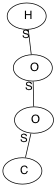

In [19]:
# Next we want O2QOOH on its way towards OH + keto-hydroperoxide
# but in elementary steps it goes via HOOQjOOH made by intra_H_migration
# we will need a template to filter out just these species
# from all the others that can be made by intra_H_migration
from rmgpy.molecule import Group
rjooh = Group().from_adjacency_list("""
1 C u1 {2,S}
2 O u0 {1,S} {3,S}
3 O u0 {2,S} {4,S}
4 H u0 {3,S}
""")
rjooh

Applying intra_H_migration but finding just the HOOQjOOH radicals
CCCCCCC(CC(C)O[O])OO <=> CCCCCCC(C[C](C)OO)OO


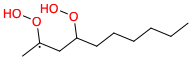

CCCCCCC(CC(C)O[O])OO <=> CCCCCCC([CH]C(C)OO)OO
CCCCCCC(CC(C)O[O])OO <=> [CH2]C(CC(CCCCCC)OO)OO
CCCCCCC(CC(C)O[O])OO <=> CCCCCC[C](CC(C)OO)OO


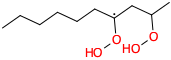

CCCCCCC(CC(C)O[O])OO <=> CCCCC[CH]C(CC(C)OO)OO
CCCCCCC(CC(C)O[O])OO <=> CCCCCCC(CC(C)OO)O[O]
CCCCCCC(CC(C)O[O])OO <=> CCCC[CH]CC(CC(C)OO)OO
CCCCCCC(CC(C)O[O])OO <=> CCC[CH]CCC(CC(C)OO)OO
CCCC(CCC(CCC)OO)O[O] <=> CCC[C](CCC(CCC)OO)OO


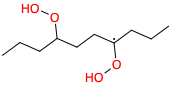

CCCC(CCC(CCC)OO)O[O] <=> CC[CH]C(CCC(CCC)OO)OO
CCCC(CCC(CCC)OO)O[O] <=> CCCC([CH]CC(CCC)OO)OO
CCCC(CCC(CCC)OO)O[O] <=> C[CH]CC(CCC(CCC)OO)OO
CCCC(CCC(CCC)OO)O[O] <=> CCCC([CH]CC(CCC)OO)OO
CCCC(CCC(CCC)OO)O[O] <=> [CH2]CCC(CCC(CCC)OO)OO
CCCC(CCC(CCC)OO)O[O] <=> CCC[C](CCC(CCC)OO)OO


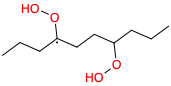

CCCC(CCC(CCC)OO)O[O] <=> CC[CH]C(CCC(CCC)OO)OO
CCCC(CCC(CCC)OO)O[O] <=> C[CH]CC(CCC(CCC)OO)OO
CCCCCCC(CCCO[O])OO <=> CCCCCCC(CC[CH]OO)OO


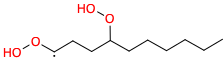

CCCCCCC(CCCO[O])OO <=> CCCCCCC(C[CH]COO)OO
CCCCCCC(CCCO[O])OO <=> CCCCCCC([CH]CCOO)OO
CCCCCCC(CCCO[O])OO <=> CCCCCC[C](CCCOO)OO


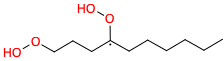

CCCCCCC(CCCO[O])OO <=> CCCCC[CH]C(CCCOO)OO
CCCCCCC(CCCO[O])OO <=> CCCCCCC(CCCOO)O[O]
CCCCCCC(CCCO[O])OO <=> CCCC[CH]CC(CCCOO)OO
CCCC(CCCC(CC)O[O])OO <=> CCCC(CCC[C](CC)OO)OO


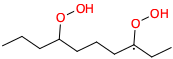

CCCC(CCCC(CC)O[O])OO <=> CCCC(CC[CH]C(CC)OO)OO
CCCC(CCCC(CC)O[O])OO <=> C[CH]C(CCCC(CCC)OO)OO
CCCC(CCCC(CC)O[O])OO <=> CCCC(C[CH]CC(CC)OO)OO
CCCC(CCCC(CC)O[O])OO <=> [CH2]CC(CCCC(CCC)OO)OO
CCCC(CCCC(CC)O[O])OO <=> CCCC([CH]CCC(CC)OO)OO
CCCC(CCCC(CC)O[O])OO <=> CCC[C](CCCC(CC)OO)OO


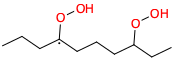

CCCC(CCCC(CC)O[O])OO <=> CC[CH]C(CCCC(CC)OO)OO
CCCC(CCCCC(C)O[O])OO <=> CCCC(CCCC[C](C)OO)OO


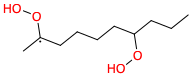

CCCC(CCCCC(C)O[O])OO <=> CCCC(CCC[CH]C(C)OO)OO
CCCC(CCCCC(C)O[O])OO <=> [CH2]C(CCCCC(CCC)OO)OO
CCCC(CCCCC(C)O[O])OO <=> CCCC(CC[CH]CC(C)OO)OO
CCCC(CCCCC(C)O[O])OO <=> CCCC(C[CH]CCC(C)OO)OO
CCCC(CCCCC(C)O[O])OO <=> CCCC([CH]CCCC(C)OO)OO
CCCC(CCCCC(C)O[O])OO <=> CCC[C](CCCCC(C)OO)OO


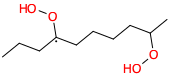

CCCCC(CCC(CC)O[O])OO <=> CCCCC(CC[C](CC)OO)OO


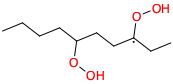

CCCCC(CCC(CC)O[O])OO <=> CCCCC(C[CH]C(CC)OO)OO
CCCCC(CCC(CC)O[O])OO <=> C[CH]C(CCC(CCCC)OO)OO
CCCCC(CCC(CC)O[O])OO <=> CCCCC([CH]CC(CC)OO)OO
CCCCC(CCC(CC)O[O])OO <=> [CH2]CC(CCC(CCCC)OO)OO
CCCCC(CCC(CC)O[O])OO <=> CCCC[C](CCC(CC)OO)OO


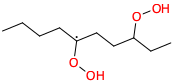

CCCCC(CCC(CC)O[O])OO <=> CCC[CH]C(CCC(CC)OO)OO
CCCCC(CCC(CC)O[O])OO <=> CCCCC(CCC(CC)OO)O[O]
CCCCC(CCC(CC)O[O])OO <=> CC[CH]CC(CCC(CC)OO)OO
CCCCCC(CCCC)(O[O])OO <=> CCCC[CH]C(CCCC)(OO)OO
CCCCCC(CCCC)(O[O])OO <=> CCC[CH]C(CCCCC)(OO)OO
CCCCCC(CCCC)(O[O])OO <=> CCC[CH]CC(CCCC)(OO)OO
CCCCCC(CCCC)(O[O])OO <=> CC[CH]CC(CCCCC)(OO)OO
CCCCCC(CCCC)(O[O])OO <=> CC[CH]CCC(CCCC)(OO)OO
CCCCCC(CCCC)(O[O])OO <=> C[CH]CCC(CCCCC)(OO)OO
CCCCCC(CCCC)(O[O])OO <=> C[CH]CCCC(CCCC)(OO)OO
CCCCCC(CCCC)(O[O])OO <=> [CH2]CCCC(CCCCC)(OO)OO
CCCCCC(CCCC)(O[O])OO <=> [CH2]CCCCC(CCCC)(OO)OO
CCCCC(O[O])C(CCCC)OO <=> CCCC[C](OO)C(CCCC)OO


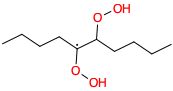

CCCCC(O[O])C(CCCC)OO <=> CCCC[C](OO)C(CCCC)OO


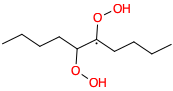

CCCCC(O[O])C(CCCC)OO <=> CCC[CH]C(OO)C(CCCC)OO
CCCCC(O[O])C(CCCC)OO <=> CCC[CH]C(OO)C(CCCC)OO
CCCCC(O[O])C(CCCC)OO <=> CC[CH]CC(OO)C(CCCC)OO
CCCCC(O[O])C(CCCC)OO <=> CC[CH]CC(OO)C(CCCC)OO
CCCCC(O[O])C(CCCC)OO <=> C[CH]CCC(OO)C(CCCC)OO
CCCCC(O[O])C(CCCC)OO <=> C[CH]CCC(OO)C(CCCC)OO
CCCCC(O[O])C(CCCC)OO <=> [CH2]CCCC(OO)C(CCCC)OO
CCCCC(O[O])C(CCCC)OO <=> [CH2]CCCC(OO)C(CCCC)OO
CCCCCC(OO)C(CCC)O[O] <=> CCCCCC(OO)[C](CCC)OO


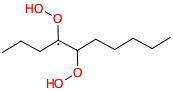

CCCCCC(OO)C(CCC)O[O] <=> CCCCC[C](OO)C(CCC)OO


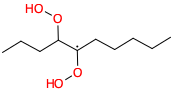

CCCCCC(OO)C(CCC)O[O] <=> CC[CH]C(OO)C(CCCCC)OO
CCCCCC(OO)C(CCC)O[O] <=> CCCC[CH]C(OO)C(CCC)OO
CCCCCC(OO)C(CCC)O[O] <=> C[CH]CC(OO)C(CCCCC)OO
CCCCCC(OO)C(CCC)O[O] <=> CCCCCC(O[O])C(CCC)OO
CCCCCC(OO)C(CCC)O[O] <=> CCC[CH]CC(OO)C(CCC)OO
CCCCCC(OO)C(CCC)O[O] <=> [CH2]CCC(OO)C(CCCCC)OO
CCCCCC(OO)C(CCC)O[O] <=> CC[CH]CCC(OO)C(CCC)OO
CCCCCC(OO)C(CCC)O[O] <=> C[CH]CCCC(OO)C(CCC)OO
CCCCC(CC(CCC)O[O])OO <=> CCCCC(C[C](CCC)OO)OO


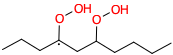

CCCCC(CC(CCC)O[O])OO <=> CCCCC([CH]C(CCC)OO)OO
CCCCC(CC(CCC)O[O])OO <=> CC[CH]C(CC(CCCC)OO)OO
CCCCC(CC(CCC)O[O])OO <=> CCCC[C](CC(CCC)OO)OO


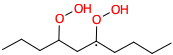

CCCCC(CC(CCC)O[O])OO <=> C[CH]CC(CC(CCCC)OO)OO
CCCCC(CC(CCC)O[O])OO <=> CCC[CH]C(CC(CCC)OO)OO
CCCCC(CC(CCC)O[O])OO <=> [CH2]CCC(CC(CCCC)OO)OO
CCCCC(CC(CCC)O[O])OO <=> CCCCC(CC(CCC)OO)O[O]
CCCCC(CC(CCC)O[O])OO <=> CC[CH]CC(CC(CCC)OO)OO
CCCCC(CC(CCC)O[O])OO <=> C[CH]CCC(CC(CCC)OO)OO
CCCCCCCC(O[O])C(C)OO <=> CCCCCCC[C](OO)C(C)OO


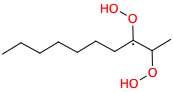

CCCCCCCC(O[O])C(C)OO <=> CCCCCCCC(OO)[C](C)OO


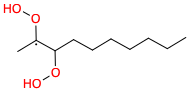

CCCCCCCC(O[O])C(C)OO <=> CCCCCC[CH]C(OO)C(C)OO
CCCCCCCC(O[O])C(C)OO <=> [CH2]C(OO)C(CCCCCCC)OO
CCCCCCCC(O[O])C(C)OO <=> CCCCC[CH]CC(OO)C(C)OO
CCCCCCCC(O[O])C(C)OO <=> CCCCCCCC(OO)C(C)O[O]
CCCCCCCC(O[O])C(C)OO <=> CCCC[CH]CCC(OO)C(C)OO
CCCCCCCC(O[O])C(C)OO <=> CCC[CH]CCCC(OO)C(C)OO
CCCCCCCC(O[O])C(C)OO <=> CC[CH]CCCCC(OO)C(C)OO
CCCCCC(CC(CC)O[O])OO <=> CCCCCC(C[C](CC)OO)OO


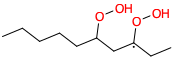

CCCCCC(CC(CC)O[O])OO <=> CCCCCC([CH]C(CC)OO)OO
CCCCCC(CC(CC)O[O])OO <=> C[CH]C(CC(CCCCC)OO)OO
CCCCCC(CC(CC)O[O])OO <=> CCCCC[C](CC(CC)OO)OO


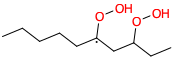

CCCCCC(CC(CC)O[O])OO <=> [CH2]CC(CC(CCCCC)OO)OO
CCCCCC(CC(CC)O[O])OO <=> CCCC[CH]C(CC(CC)OO)OO
CCCCCC(CC(CC)O[O])OO <=> CCCCCC(CC(CC)OO)O[O]
CCCCCC(CC(CC)O[O])OO <=> CCC[CH]CC(CC(CC)OO)OO
CCCCCC(CC(CC)O[O])OO <=> CC[CH]CCC(CC(CC)OO)OO
CCCCCCC(CCC)(O[O])OO <=> CCCCC[CH]C(CCC)(OO)OO
CCCCCCC(CCC)(O[O])OO <=> CC[CH]C(CCCCCC)(OO)OO
CCCCCCC(CCC)(O[O])OO <=> CCCC[CH]CC(CCC)(OO)OO
CCCCCCC(CCC)(O[O])OO <=> C[CH]CC(CCCCCC)(OO)OO
CCCCCCC(CCC)(O[O])OO <=> CCC[CH]CCC(CCC)(OO)OO
CCCCCCC(CCC)(O[O])OO <=> [CH2]CCC(CCCCCC)(OO)OO
CCCCCCC(CCC)(O[O])OO <=> CC[CH]CCCC(CCC)(OO)OO
CCCCCCC(CCC)(O[O])OO <=> C[CH]CCCCC(CCC)(OO)OO
CCCCCC(O[O])C(CCC)OO <=> CCCCC[C](OO)C(CCC)OO


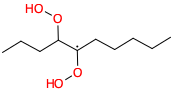

CCCCCC(O[O])C(CCC)OO <=> CCCCCC(OO)[C](CCC)OO


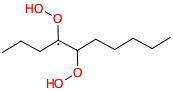

CCCCCC(O[O])C(CCC)OO <=> CCCC[CH]C(OO)C(CCC)OO
CCCCCC(O[O])C(CCC)OO <=> CC[CH]C(OO)C(CCCCC)OO
CCCCCC(O[O])C(CCC)OO <=> CCC[CH]CC(OO)C(CCC)OO
CCCCCC(O[O])C(CCC)OO <=> CCCCCC(OO)C(CCC)O[O]
CCCCCC(O[O])C(CCC)OO <=> C[CH]CC(OO)C(CCCCC)OO
CCCCCC(O[O])C(CCC)OO <=> CC[CH]CCC(OO)C(CCC)OO
CCCCCC(O[O])C(CCC)OO <=> [CH2]CCC(OO)C(CCCCC)OO
CCCCCC(O[O])C(CCC)OO <=> C[CH]CCCC(OO)C(CCC)OO
CCCCCC(O[O])C(CCC)OO <=> [CH2]CCCCC(OO)C(CCC)OO
CCCCCCC(OO)C(CC)O[O] <=> CCCCCCC(OO)[C](CC)OO


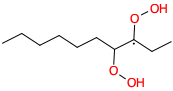

CCCCCCC(OO)C(CC)O[O] <=> CCCCCC[C](OO)C(CC)OO


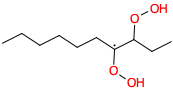

CCCCCCC(OO)C(CC)O[O] <=> C[CH]C(OO)C(CCCCCC)OO
CCCCCCC(OO)C(CC)O[O] <=> CCCCC[CH]C(OO)C(CC)OO
CCCCCCC(OO)C(CC)O[O] <=> [CH2]CC(OO)C(CCCCCC)OO
CCCCCCC(OO)C(CC)O[O] <=> CCCCCCC(O[O])C(CC)OO
CCCCCCC(OO)C(CC)O[O] <=> CCCC[CH]CC(OO)C(CC)OO
CCCCCCC(OO)C(CC)O[O] <=> CCC[CH]CCC(OO)C(CC)OO
CCCCCCC(OO)C(CC)O[O] <=> CC[CH]CCCC(OO)C(CC)OO
CCCCC(CC(CCC)OO)O[O] <=> CCCC[C](CC(CCC)OO)OO


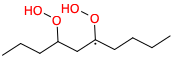

CCCCC(CC(CCC)OO)O[O] <=> CCCCC([CH]C(CCC)OO)OO
CCCCC(CC(CCC)OO)O[O] <=> CCC[CH]C(CC(CCC)OO)OO
CCCCC(CC(CCC)OO)O[O] <=> CCCCC(C[C](CCC)OO)OO


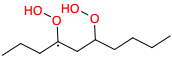

CCCCC(CC(CCC)OO)O[O] <=> CC[CH]CC(CC(CCC)OO)OO
CCCCC(CC(CCC)OO)O[O] <=> CC[CH]C(CC(CCCC)OO)OO
CCCCC(CC(CCC)OO)O[O] <=> C[CH]CCC(CC(CCC)OO)OO
CCCCC(CC(CCC)OO)O[O] <=> CCCCC(CC(CCC)O[O])OO
CCCCC(CC(CCC)OO)O[O] <=> C[CH]CC(CC(CCCC)OO)OO
CCCCC(CC(CCC)OO)O[O] <=> [CH2]CCCC(CC(CCC)OO)OO
CCCCC(CC(CCC)OO)O[O] <=> [CH2]CCC(CC(CCCC)OO)OO
CCCCCC(CCCCOO)O[O] <=> CCCCC[C](CCCCOO)OO


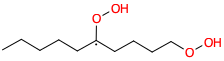

CCCCCC(CCCCOO)O[O] <=> CCCC[CH]C(CCCCOO)OO
CCCCCC(CCCCOO)O[O] <=> CCCCCC([CH]CCCOO)OO
CCCCCC(CCCCOO)O[O] <=> CCC[CH]CC(CCCCOO)OO
CCCCCC(CCCCOO)O[O] <=> CCCCCC(C[CH]CCOO)OO
CCCCCC(CCCCOO)O[O] <=> CC[CH]CCC(CCCCOO)OO
CCCCCC(CCCCOO)O[O] <=> CCCCCC(CC[CH]COO)OO
CCCCCC(CCCCOO)O[O] <=> C[CH]CCCC(CCCCOO)OO
CCCCCC(CCCCOO)O[O] <=> CCCCCC(CCC[CH]OO)OO


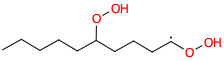

CCCCCC(CCCCOO)O[O] <=> [CH2]CCCCC(CCCCOO)OO
CCCCC(CCCCCOO)O[O] <=> CCCC[C](CCCCCOO)OO


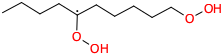

CCCCC(CCCCCOO)O[O] <=> CCC[CH]C(CCCCCOO)OO
CCCCC(CCCCCOO)O[O] <=> CCCCC([CH]CCCCOO)OO
CCCCC(CCCCCOO)O[O] <=> CC[CH]CC(CCCCCOO)OO
CCCCC(CCCCCOO)O[O] <=> CCCCC(C[CH]CCCOO)OO
CCCCC(CCCCCOO)O[O] <=> C[CH]CCC(CCCCCOO)OO
CCCCC(CCCCCOO)O[O] <=> CCCCC(CC[CH]CCOO)OO
CCCCC(CCCCCOO)O[O] <=> [CH2]CCCC(CCCCCOO)OO
CCCCC(CCCCCOO)O[O] <=> CCCCC(CCC[CH]COO)OO
CCCCC(CCCCCOO)O[O] <=> CCCCC(CCCC[CH]OO)OO


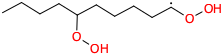

CCCCCCC(CC(C)OO)O[O] <=> CCCCCC[C](CC(C)OO)OO


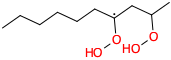

CCCCCCC(CC(C)OO)O[O] <=> CCCCCCC([CH]C(C)OO)OO
CCCCCCC(CC(C)OO)O[O] <=> CCCCC[CH]C(CC(C)OO)OO
CCCCCCC(CC(C)OO)O[O] <=> CCCCCCC(C[C](C)OO)OO


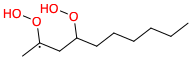

CCCCCCC(CC(C)OO)O[O] <=> CCCC[CH]CC(CC(C)OO)OO
CCCCCCC(CC(C)OO)O[O] <=> [CH2]C(CC(CCCCCC)OO)OO
CCCCCCC(CC(C)OO)O[O] <=> CCC[CH]CCC(CC(C)OO)OO
CCCCCCC(CC(C)OO)O[O] <=> CCCCCCC(CC(C)O[O])OO
CCCCCCC(CC(C)OO)O[O] <=> CC[CH]CCCC(CC(C)OO)OO
CCCCCCC(CC(C)OO)O[O] <=> C[CH]CCCCC(CC(C)OO)OO
CCCCCCCCC(C)(O[O])OO <=> CCCCCCC[CH]C(C)(OO)OO
CCCCCCCCC(C)(O[O])OO <=> [CH2]C(CCCCCCCC)(OO)OO
CCCCCCCCC(C)(O[O])OO <=> CCCCCC[CH]CC(C)(OO)OO
CCCCCCCCC(C)(O[O])OO <=> CCCCC[CH]CCC(C)(OO)OO
CCCCCCCCC(C)(O[O])OO <=> CCCC[CH]CCCC(C)(OO)OO
CCCCCCCCC(C)(O[O])OO <=> CCC[CH]CCCCC(C)(OO)OO
CCCCCCCCC(CO[O])OO <=> CCCCCCCCC([CH]OO)OO


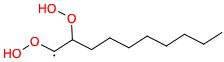

CCCCCCCCC(CO[O])OO <=> CCCCCCCC[C](COO)OO


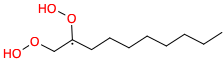

CCCCCCCCC(CO[O])OO <=> CCCCCCC[CH]C(COO)OO
CCCCCCCCC(CO[O])OO <=> CCCCCCCCC(COO)O[O]
CCCCCCCCC(CO[O])OO <=> CCCCCC[CH]CC(COO)OO
CCCCCCCCC(CO[O])OO <=> CCCCC[CH]CCC(COO)OO
CCCCCCCCC(CO[O])OO <=> CCCC[CH]CCCC(COO)OO
CCCCC(CCCC(C)OO)O[O] <=> CCCC[C](CCCC(C)OO)OO


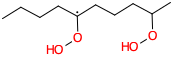

CCCCC(CCCC(C)OO)O[O] <=> CCC[CH]C(CCCC(C)OO)OO
CCCCC(CCCC(C)OO)O[O] <=> CCCCC([CH]CCC(C)OO)OO
CCCCC(CCCC(C)OO)O[O] <=> CC[CH]CC(CCCC(C)OO)OO
CCCCC(CCCC(C)OO)O[O] <=> CCCCC(C[CH]CC(C)OO)OO
CCCCC(CCCC(C)OO)O[O] <=> C[CH]CCC(CCCC(C)OO)OO
CCCCC(CCCC(C)OO)O[O] <=> CCCCC(CC[CH]C(C)OO)OO
CCCCC(CCCC(C)OO)O[O] <=> [CH2]CCCC(CCCC(C)OO)OO
CCCCC(CCCC(C)OO)O[O] <=> CCCCC(CCC[C](C)OO)OO


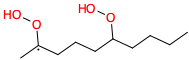

CCCCC(CCCC(C)OO)O[O] <=> [CH2]C(CCCC(CCCC)OO)OO
CCCC(CCCCC(C)OO)O[O] <=> CCC[C](CCCCC(C)OO)OO


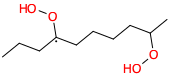

CCCC(CCCCC(C)OO)O[O] <=> CC[CH]C(CCCCC(C)OO)OO
CCCC(CCCCC(C)OO)O[O] <=> CCCC([CH]CCCC(C)OO)OO
CCCC(CCCCC(C)OO)O[O] <=> C[CH]CC(CCCCC(C)OO)OO
CCCC(CCCCC(C)OO)O[O] <=> CCCC(C[CH]CCC(C)OO)OO
CCCC(CCCCC(C)OO)O[O] <=> [CH2]CCC(CCCCC(C)OO)OO
CCCC(CCCCC(C)OO)O[O] <=> CCCC(CC[CH]CC(C)OO)OO
CCCC(CCCCC(C)OO)O[O] <=> CCCC(CCC[CH]C(C)OO)OO
CCCC(CCCCC(C)OO)O[O] <=> CCCC(CCCC[C](C)OO)OO


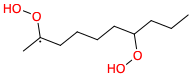

CCCCCCCC(CC)(O[O])OO <=> CCCCCC[CH]C(CC)(OO)OO
CCCCCCCC(CC)(O[O])OO <=> C[CH]C(CCCCCCC)(OO)OO
CCCCCCCC(CC)(O[O])OO <=> CCCCC[CH]CC(CC)(OO)OO
CCCCCCCC(CC)(O[O])OO <=> [CH2]CC(CCCCCCC)(OO)OO
CCCCCCCC(CC)(O[O])OO <=> CCCC[CH]CCC(CC)(OO)OO
CCCCCCCC(CC)(O[O])OO <=> CCC[CH]CCCC(CC)(OO)OO
CCCCCCCC(CC)(O[O])OO <=> CC[CH]CCCCC(CC)(OO)OO
CCCCCCC(O[O])C(CC)OO <=> CCCCCC[C](OO)C(CC)OO


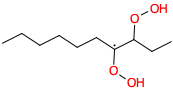

CCCCCCC(O[O])C(CC)OO <=> CCCCCCC(OO)[C](CC)OO


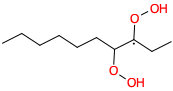

CCCCCCC(O[O])C(CC)OO <=> CCCCC[CH]C(OO)C(CC)OO
CCCCCCC(O[O])C(CC)OO <=> C[CH]C(OO)C(CCCCCC)OO
CCCCCCC(O[O])C(CC)OO <=> CCCC[CH]CC(OO)C(CC)OO
CCCCCCC(O[O])C(CC)OO <=> CCCCCCC(OO)C(CC)O[O]
CCCCCCC(O[O])C(CC)OO <=> [CH2]CC(OO)C(CCCCCC)OO
CCCCCCC(O[O])C(CC)OO <=> CCC[CH]CCC(OO)C(CC)OO
CCCCCCC(O[O])C(CC)OO <=> CC[CH]CCCC(OO)C(CC)OO
CCCCCCC(O[O])C(CC)OO <=> C[CH]CCCCC(OO)C(CC)OO
CCCCCCCC(OO)C(C)O[O] <=> CCCCCCCC(OO)[C](C)OO


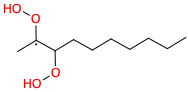

CCCCCCCC(OO)C(C)O[O] <=> CCCCCCC[C](OO)C(C)OO


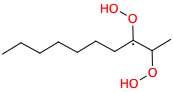

CCCCCCCC(OO)C(C)O[O] <=> [CH2]C(OO)C(CCCCCCC)OO
CCCCCCCC(OO)C(C)O[O] <=> CCCCCC[CH]C(OO)C(C)OO
CCCCCCCC(OO)C(C)O[O] <=> CCCCCCCC(O[O])C(C)OO
CCCCCCCC(OO)C(C)O[O] <=> CCCCC[CH]CC(OO)C(C)OO
CCCCCCCC(OO)C(C)O[O] <=> CCCC[CH]CCC(OO)C(C)OO
CCCCCCCC(OO)C(C)O[O] <=> CCC[CH]CCCC(OO)C(C)OO
CCCCC(CCCCCO[O])OO <=> CCCCC(CCCC[CH]OO)OO


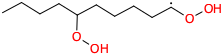

CCCCC(CCCCCO[O])OO <=> CCCCC(CCC[CH]COO)OO
CCCCC(CCCCCO[O])OO <=> CCCCC(CC[CH]CCOO)OO
CCCCC(CCCCCO[O])OO <=> CCCCC(C[CH]CCCOO)OO
CCCCC(CCCCCO[O])OO <=> CCCCC([CH]CCCCOO)OO
CCCCC(CCCCCO[O])OO <=> CCCC[C](CCCCCOO)OO


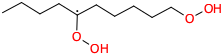

CCCCCCCCC(COO)O[O] <=> CCCCCCCC[C](COO)OO


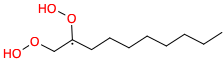

CCCCCCCCC(COO)O[O] <=> CCCCCCC[CH]C(COO)OO
CCCCCCCCC(COO)O[O] <=> CCCCCCCCC([CH]OO)OO


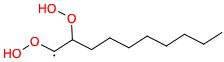

CCCCCCCCC(COO)O[O] <=> CCCCCC[CH]CC(COO)OO
CCCCCCCCC(COO)O[O] <=> CCCCC[CH]CCC(COO)OO
CCCCCCCCC(COO)O[O] <=> CCCCCCCCC(CO[O])OO
CCCCCCCCC(COO)O[O] <=> CCCC[CH]CCCC(COO)OO
CCCCCCCCC(COO)O[O] <=> CCC[CH]CCCCC(COO)OO
CCCCCCCC(CCOO)O[O] <=> CCCCCCC[C](CCOO)OO


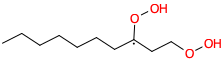

CCCCCCCC(CCOO)O[O] <=> CCCCCC[CH]C(CCOO)OO
CCCCCCCC(CCOO)O[O] <=> CCCCCCCC([CH]COO)OO
CCCCCCCC(CCOO)O[O] <=> CCCCC[CH]CC(CCOO)OO
CCCCCCCC(CCOO)O[O] <=> CCCCCCCC(C[CH]OO)OO


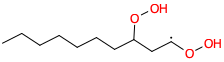

CCCCCCCC(CCOO)O[O] <=> CCCC[CH]CCC(CCOO)OO
CCCCCCCC(CCOO)O[O] <=> CCC[CH]CCCC(CCOO)OO
CCCCCCCC(CCOO)O[O] <=> CCCCCCCC(CCO[O])OO
CCCCCCCC(CCOO)O[O] <=> CC[CH]CCCCC(CCOO)OO
CCCCC(CCCC(C)O[O])OO <=> CCCCC(CCC[C](C)OO)OO


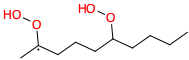

CCCCC(CCCC(C)O[O])OO <=> CCCCC(CC[CH]C(C)OO)OO
CCCCC(CCCC(C)O[O])OO <=> [CH2]C(CCCC(CCCC)OO)OO
CCCCC(CCCC(C)O[O])OO <=> CCCCC(C[CH]CC(C)OO)OO
CCCCC(CCCC(C)O[O])OO <=> CCCCC([CH]CCC(C)OO)OO
CCCCC(CCCC(C)O[O])OO <=> CCCC[C](CCCC(C)OO)OO


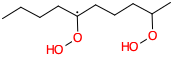

CCCCC(CCCC(C)O[O])OO <=> CCC[CH]C(CCCC(C)OO)OO
CCCCCC(CCC(C)OO)O[O] <=> CCCCC[C](CCC(C)OO)OO


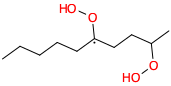

CCCCCC(CCC(C)OO)O[O] <=> CCCC[CH]C(CCC(C)OO)OO
CCCCCC(CCC(C)OO)O[O] <=> CCCCCC([CH]CC(C)OO)OO
CCCCCC(CCC(C)OO)O[O] <=> CCC[CH]CC(CCC(C)OO)OO
CCCCCC(CCC(C)OO)O[O] <=> CCCCCC(C[CH]C(C)OO)OO
CCCCCC(CCC(C)OO)O[O] <=> CC[CH]CCC(CCC(C)OO)OO
CCCCCC(CCC(C)OO)O[O] <=> CCCCCC(CC[C](C)OO)OO


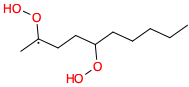

CCCCCC(CCC(C)OO)O[O] <=> C[CH]CCCC(CCC(C)OO)OO
CCCCCC(CCC(C)OO)O[O] <=> [CH2]C(CCC(CCCCC)OO)OO
CCCCCC(CCC(C)OO)O[O] <=> [CH2]CCCCC(CCC(C)OO)OO
CCCCCC(CCC(C)OO)O[O] <=> CCCCCC(CCC(C)O[O])OO
CCCCCCCCCC(O[O])OO <=> CCCCCCCCC[C](OO)OO


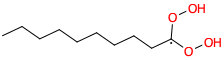

CCCCCCCCCC(O[O])OO <=> CCCCCCCC[CH]C(OO)OO
CCCCCCCCCC(O[O])OO <=> CCCCCCC[CH]CC(OO)OO
CCCCCCCCCC(O[O])OO <=> CCCCCC[CH]CCC(OO)OO
CCCCCCCCCC(O[O])OO <=> CCCCC[CH]CCCC(OO)OO
CCCCCCCCCC(O[O])OO <=> CCCC[CH]CCCCC(OO)OO
CCCCCC(CCCCO[O])OO <=> CCCCCC(CCC[CH]OO)OO


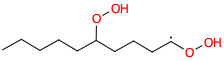

CCCCCC(CCCCO[O])OO <=> CCCCCC(CC[CH]COO)OO
CCCCCC(CCCCO[O])OO <=> CCCCCC(C[CH]CCOO)OO
CCCCCC(CCCCO[O])OO <=> CCCCCC([CH]CCCOO)OO
CCCCCC(CCCCO[O])OO <=> CCCCC[C](CCCCOO)OO


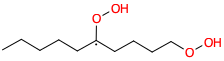

CCCCCC(CCCCO[O])OO <=> CCCC[CH]C(CCCCOO)OO
CCCCCC(CCC(C)O[O])OO <=> CCCCCC(CC[C](C)OO)OO


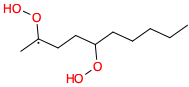

CCCCCC(CCC(C)O[O])OO <=> CCCCCC(C[CH]C(C)OO)OO
CCCCCC(CCC(C)O[O])OO <=> [CH2]C(CCC(CCCCC)OO)OO
CCCCCC(CCC(C)O[O])OO <=> CCCCCC([CH]CC(C)OO)OO
CCCCCC(CCC(C)O[O])OO <=> CCCCC[C](CCC(C)OO)OO


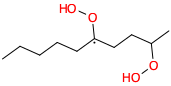

CCCCCC(CCC(C)O[O])OO <=> CCCC[CH]C(CCC(C)OO)OO
CCCCCC(CCC(C)O[O])OO <=> CCCCCC(CCC(C)OO)O[O]
CCCCCC(CCC(C)O[O])OO <=> CCC[CH]CC(CCC(C)OO)OO
CCCCCC(CC(CC)OO)O[O] <=> CCCCC[C](CC(CC)OO)OO


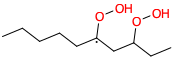

CCCCCC(CC(CC)OO)O[O] <=> CCCCCC([CH]C(CC)OO)OO
CCCCCC(CC(CC)OO)O[O] <=> CCCC[CH]C(CC(CC)OO)OO
CCCCCC(CC(CC)OO)O[O] <=> CCCCCC(C[C](CC)OO)OO


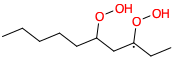

CCCCCC(CC(CC)OO)O[O] <=> CCC[CH]CC(CC(CC)OO)OO
CCCCCC(CC(CC)OO)O[O] <=> C[CH]C(CC(CCCCC)OO)OO
CCCCCC(CC(CC)OO)O[O] <=> CC[CH]CCC(CC(CC)OO)OO
CCCCCC(CC(CC)OO)O[O] <=> CCCCCC(CC(CC)O[O])OO
CCCCCC(CC(CC)OO)O[O] <=> [CH2]CC(CC(CCCCC)OO)OO
CCCCCC(CC(CC)OO)O[O] <=> C[CH]CCCC(CC(CC)OO)OO
CCCCCC(CC(CC)OO)O[O] <=> [CH2]CCCCC(CC(CC)OO)OO
CCCCCCCC(CCO[O])OO <=> CCCCCCCC(C[CH]OO)OO


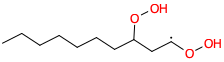

CCCCCCCC(CCO[O])OO <=> CCCCCCCC([CH]COO)OO
CCCCCCCC(CCO[O])OO <=> CCCCCCC[C](CCOO)OO


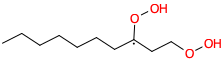

CCCCCCCC(CCO[O])OO <=> CCCCCC[CH]C(CCOO)OO
CCCCCCCC(CCO[O])OO <=> CCCCCCCC(CCOO)O[O]
CCCCCCCC(CCO[O])OO <=> CCCCC[CH]CC(CCOO)OO
CCCCCCCC(CCO[O])OO <=> CCCC[CH]CCC(CCOO)OO
CCCCC(CCC(CC)OO)O[O] <=> CCCC[C](CCC(CC)OO)OO


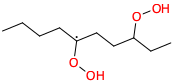

CCCCC(CCC(CC)OO)O[O] <=> CCC[CH]C(CCC(CC)OO)OO
CCCCC(CCC(CC)OO)O[O] <=> CCCCC([CH]CC(CC)OO)OO
CCCCC(CCC(CC)OO)O[O] <=> CC[CH]CC(CCC(CC)OO)OO
CCCCC(CCC(CC)OO)O[O] <=> CCCCC(C[CH]C(CC)OO)OO
CCCCC(CCC(CC)OO)O[O] <=> C[CH]CCC(CCC(CC)OO)OO
CCCCC(CCC(CC)OO)O[O] <=> CCCCC(CC[C](CC)OO)OO


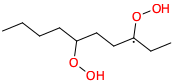

CCCCC(CCC(CC)OO)O[O] <=> [CH2]CCCC(CCC(CC)OO)OO
CCCCC(CCC(CC)OO)O[O] <=> C[CH]C(CCC(CCCC)OO)OO
CCCCC(CCC(CC)OO)O[O] <=> CCCCC(CCC(CC)O[O])OO
CCCCC(CCC(CC)OO)O[O] <=> [CH2]CC(CCC(CCCC)OO)OO
CCCC(CCCC(CC)OO)O[O] <=> CCC[C](CCCC(CC)OO)OO


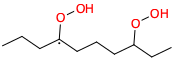

CCCC(CCCC(CC)OO)O[O] <=> CC[CH]C(CCCC(CC)OO)OO
CCCC(CCCC(CC)OO)O[O] <=> CCCC([CH]CCC(CC)OO)OO
CCCC(CCCC(CC)OO)O[O] <=> C[CH]CC(CCCC(CC)OO)OO
CCCC(CCCC(CC)OO)O[O] <=> CCCC(C[CH]CC(CC)OO)OO
CCCC(CCCC(CC)OO)O[O] <=> [CH2]CCC(CCCC(CC)OO)OO
CCCC(CCCC(CC)OO)O[O] <=> CCCC(CC[CH]C(CC)OO)OO
CCCC(CCCC(CC)OO)O[O] <=> CCCC(CCC[C](CC)OO)OO


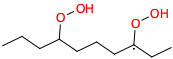

CCCC(CCCC(CC)OO)O[O] <=> C[CH]C(CCCC(CCC)OO)OO
CCC(CCCCC(CC)OO)O[O] <=> CC[C](CCCCC(CC)OO)OO


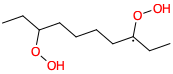

CCC(CCCCC(CC)OO)O[O] <=> CCC([CH]CCCC(CC)OO)OO
CCC(CCCCC(CC)OO)O[O] <=> C[CH]C(CCCCC(CC)OO)OO
CCC(CCCCC(CC)OO)O[O] <=> CCC(C[CH]CCC(CC)OO)OO
CCC(CCCCC(CC)OO)O[O] <=> [CH2]CC(CCCCC(CC)OO)OO
CCC(CCCCC(CC)OO)O[O] <=> CCC(C[CH]CCC(CC)OO)OO
CCC(CCCCC(CC)OO)O[O] <=> CCC([CH]CCCC(CC)OO)OO
CCC(CCCCC(CC)OO)O[O] <=> CC[C](CCCCC(CC)OO)OO


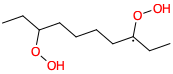

CCCCCCC(CCCOO)O[O] <=> CCCCCC[C](CCCOO)OO


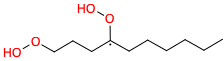

CCCCCCC(CCCOO)O[O] <=> CCCCC[CH]C(CCCOO)OO
CCCCCCC(CCCOO)O[O] <=> CCCCCCC([CH]CCOO)OO
CCCCCCC(CCCOO)O[O] <=> CCCC[CH]CC(CCCOO)OO
CCCCCCC(CCCOO)O[O] <=> CCCCCCC(C[CH]COO)OO
CCCCCCC(CCCOO)O[O] <=> CCC[CH]CCC(CCCOO)OO
CCCCCCC(CCCOO)O[O] <=> CCCCCCC(CC[CH]OO)OO


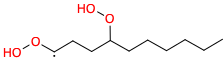

CCCCCCC(CCCOO)O[O] <=> CC[CH]CCCC(CCCOO)OO
CCCCCCC(CCCOO)O[O] <=> C[CH]CCCCC(CCCOO)OO
CCCCCCC(CCCOO)O[O] <=> CCCCCCC(CCCO[O])OO
HOOQjOOH


{Molecule(smiles="CCCCCCCCC[C](OO)OO"),
 Molecule(smiles="CC[C](CCCCC(CC)OO)OO"),
 Molecule(smiles="CCCC[C](CCCCCOO)OO"),
 Molecule(smiles="CCCCC(CCCC[CH]OO)OO"),
 Molecule(smiles="CCCCCCCCC([CH]OO)OO"),
 Molecule(smiles="CCCCCCCC[C](COO)OO"),
 Molecule(smiles="CCCC[C](CCCC(C)OO)OO"),
 Molecule(smiles="CCCCC(CCC[C](C)OO)OO"),
 Molecule(smiles="CCCCCCC[C](CCOO)OO"),
 Molecule(smiles="CCCCCCCC(C[CH]OO)OO"),
 Molecule(smiles="CCCCC[C](CCC(C)OO)OO"),
 Molecule(smiles="CCCCCC(CC[C](C)OO)OO"),
 Molecule(smiles="CCC[C](CCCCC(C)OO)OO"),
 Molecule(smiles="CCCCC(CC[C](CC)OO)OO"),
 Molecule(smiles="CCCC[C](CCC(CC)OO)OO"),
 Molecule(smiles="CCCCCC(OO)[C](CCC)OO"),
 Molecule(smiles="CCCCC[C](OO)C(CCC)OO"),
 Molecule(smiles="CCCCC(C[C](CCC)OO)OO"),
 Molecule(smiles="CCCC[C](CC(CCC)OO)OO"),
 Molecule(smiles="CCCCCCC[C](OO)C(C)OO"),
 Molecule(smiles="CCCCCCCC(OO)[C](C)OO"),
 Molecule(smiles="CCCCCC(C[C](CC)OO)OO"),
 Molecule(smiles="CCCCCCC(CC[CH]OO)OO"),
 Molecule(smiles="CCCC(CCC[C](CC)OO)OO"),
 Mol

In [20]:
# O2QOOH on its way towards OH + keto-hydroperoxide
print("Applying intra_H_migration but finding just the HOOQjOOH radicals")
for s in molecules['O2QOOH']:
    reactions = rmg.database.kinetics.generate_reactions_from_families((s,), only_families='intra_H_migration')
    for r in reactions:
        print(r)
        m = r.products[0].molecule[0]
        if m.is_subgraph_isomorphic(rjooh):
            display(m)
            molecules['HOOQjOOH'].add(m)
print('HOOQjOOH')
molecules['HOOQjOOH']

Applying R_Addition_MultipleBond to HOOQjOOH to find its Beta Scission products
CCCCCCCCC=C(OO)OO + [H] <=> CCCCCCCCC[C](OO)OO
C=C(OO)OO + [CH2]CCCCCCC <=> CCCCCCCCC[C](OO)OO
CCCCCCCCCC(=O)OO + [OH] <=> CCCCCCCCC[C](OO)OO


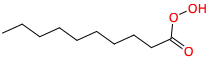

CCC(=CCCCC(CC)OO)OO + [H] <=> CC[C](CCCCC(CC)OO)OO
CC=C(CCCCC(CC)OO)OO + [H] <=> CC[C](CCCCC(CC)OO)OO
C=C(CC)OO + [CH2]CCC(CC)OO <=> CC[C](CCCCC(CC)OO)OO
C=C(CCCCC(CC)OO)OO + [CH3] <=> CC[C](CCCCC(CC)OO)OO
CCC(=O)CCCCC(CC)OO + [OH] <=> CC[C](CCCCC(CC)OO)OO


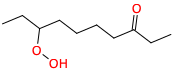

CCCC=C(CCCCCOO)OO + [H] <=> CCCC[C](CCCCCOO)OO
CCCCC(=CCCCCOO)OO + [H] <=> CCCC[C](CCCCCOO)OO
C=C(CCCCCOO)OO + [CH2]CC <=> CCCC[C](CCCCCOO)OO
C=C(CCCC)OO + [CH2]CCCOO <=> CCCC[C](CCCCCOO)OO
CCCCC(=O)CCCCCOO + [OH] <=> CCCC[C](CCCCCOO)OO


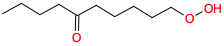

CCCCC(CCCC=COO)OO + [H] <=> CCCCC(CCCC[CH]OO)OO
C=COO + [CH2]CCC(CCCC)OO <=> CCCCC(CCCC[CH]OO)OO
CCCCC(CCCCC=O)OO + [OH] <=> CCCCC(CCCC[CH]OO)OO


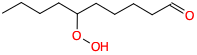

CCCCCCCCC(=COO)OO + [H] <=> CCCCCCCCC([CH]OO)OO
OOC=COO + [CH2]CCCCCCC <=> CCCCCCCCC([CH]OO)OO
CCCCCCCCC(C=O)OO + [OH] <=> CCCCCCCCC([CH]OO)OO


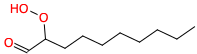

CCCCCCCCC=COO + [O]O <=> CCCCCCCCC([CH]OO)OO
CCCCCCCC=C(COO)OO + [H] <=> CCCCCCCC[C](COO)OO
CCCCCCCCC(=COO)OO + [H] <=> CCCCCCCC[C](COO)OO
C=C(COO)OO + [CH2]CCCCCC <=> CCCCCCCC[C](COO)OO
CCCCCCCCC(=O)COO + [OH] <=> CCCCCCCC[C](COO)OO


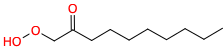

C=C(CCCCCCCC)OO + [O]O <=> CCCCCCCC[C](COO)OO
CCCC=C(CCCC(C)OO)OO + [H] <=> CCCC[C](CCCC(C)OO)OO
CCCCC(=CCCC(C)OO)OO + [H] <=> CCCC[C](CCCC(C)OO)OO
C=C(CCCC(C)OO)OO + [CH2]CC <=> CCCC[C](CCCC(C)OO)OO
C=C(CCCC)OO + [CH2]CC(C)OO <=> CCCC[C](CCCC(C)OO)OO
CCCCC(=O)CCCC(C)OO + [OH] <=> CCCC[C](CCCC(C)OO)OO


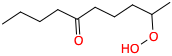

CCCCC(CCC=C(C)OO)OO + [H] <=> CCCCC(CCC[C](C)OO)OO
C=C(CCCC(CCCC)OO)OO + [H] <=> CCCCC(CCC[C](C)OO)OO
C=C(C)OO + [CH2]CC(CCCC)OO <=> CCCCC(CCC[C](C)OO)OO
CCCCC(CCCC(C)=O)OO + [OH] <=> CCCCC(CCC[C](C)OO)OO


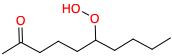

CCCCCCC=C(CCOO)OO + [H] <=> CCCCCCC[C](CCOO)OO
CCCCCCCC(=CCOO)OO + [H] <=> CCCCCCC[C](CCOO)OO
C=C(CCOO)OO + [CH2]CCCCC <=> CCCCCCC[C](CCOO)OO
C=C(CCCCCCC)OO + [CH2]OO <=> CCCCCCC[C](CCOO)OO
CCCCCCCC(=O)CCOO + [OH] <=> CCCCCCC[C](CCOO)OO


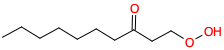

CCCCCCCC(C=COO)OO + [H] <=> CCCCCCCC(C[CH]OO)OO
C=COO + CCCCCCC[CH]OO <=> CCCCCCCC(C[CH]OO)OO
CCCCCCCC(CC=O)OO + [OH] <=> CCCCCCCC(C[CH]OO)OO


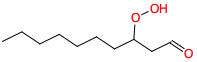

CCCCC=C(CCC(C)OO)OO + [H] <=> CCCCC[C](CCC(C)OO)OO
CCCCCC(=CCC(C)OO)OO + [H] <=> CCCCC[C](CCC(C)OO)OO
C=C(CCC(C)OO)OO + [CH2]CCC <=> CCCCC[C](CCC(C)OO)OO
C=C(CCCCC)OO + [CH2]C(C)OO <=> CCCCC[C](CCC(C)OO)OO
CCCCCC(=O)CCC(C)OO + [OH] <=> CCCCC[C](CCC(C)OO)OO


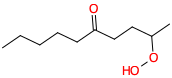

CCCCCC(CC=C(C)OO)OO + [H] <=> CCCCCC(CC[C](C)OO)OO
C=C(CCC(CCCCC)OO)OO + [H] <=> CCCCCC(CC[C](C)OO)OO
C=C(C)OO + [CH2]C(CCCCC)OO <=> CCCCCC(CC[C](C)OO)OO
CCCCCC(CCC(C)=O)OO + [OH] <=> CCCCCC(CC[C](C)OO)OO


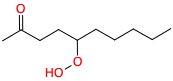

CCCC(=CCCCC(C)OO)OO + [H] <=> CCC[C](CCCCC(C)OO)OO
CCC=C(CCCCC(C)OO)OO + [H] <=> CCC[C](CCCCC(C)OO)OO
C=C(CCC)OO + [CH2]CCC(C)OO <=> CCC[C](CCCCC(C)OO)OO
C=C(CCCCC(C)OO)OO + C[CH2] <=> CCC[C](CCCCC(C)OO)OO
CCCC(=O)CCCCC(C)OO + [OH] <=> CCC[C](CCCCC(C)OO)OO


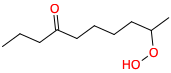

CCCCC(CC=C(CC)OO)OO + [H] <=> CCCCC(CC[C](CC)OO)OO
CC=C(CCC(CCCC)OO)OO + [H] <=> CCCCC(CC[C](CC)OO)OO
C=C(CC)OO + [CH2]C(CCCC)OO <=> CCCCC(CC[C](CC)OO)OO
C=C(CCC(CCCC)OO)OO + [CH3] <=> CCCCC(CC[C](CC)OO)OO
CCCCC(CCC(=O)CC)OO + [OH] <=> CCCCC(CC[C](CC)OO)OO


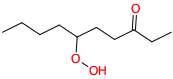

CCCC=C(CCC(CC)OO)OO + [H] <=> CCCC[C](CCC(CC)OO)OO
CCCCC(=CCC(CC)OO)OO + [H] <=> CCCC[C](CCC(CC)OO)OO
C=C(CCC(CC)OO)OO + [CH2]CC <=> CCCC[C](CCC(CC)OO)OO
C=C(CCCC)OO + [CH2]C(CC)OO <=> CCCC[C](CCC(CC)OO)OO
CCCCC(=O)CCC(CC)OO + [OH] <=> CCCC[C](CCC(CC)OO)OO


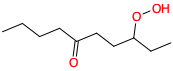

CCCCCC(OO)=C(CCC)OO + [H] <=> CCCCCC(OO)[C](CCC)OO
CCC=C(OO)C(CCCCC)OO + [H] <=> CCCCCC(OO)[C](CCC)OO
CCCC(=COO)OO + [CH2]CCCC <=> CCCCCC(OO)[C](CCC)OO
C=C(OO)C(CCCCC)OO + C[CH2] <=> CCCCCC(OO)[C](CCC)OO
CCCCCC(OO)C(=O)CCC + [OH] <=> CCCCCC(OO)[C](CCC)OO


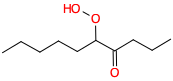

CCCCCC=C(CCC)OO + [O]O <=> CCCCCC(OO)[C](CCC)OO
CCCCCC(OO)=C(CCC)OO + [H] <=> CCCCC[C](OO)C(CCC)OO
CCCCC=C(OO)C(CCC)OO + [H] <=> CCCCC[C](OO)C(CCC)OO
CCCCCC(=COO)OO + [CH2]CC <=> CCCCC[C](OO)C(CCC)OO
C=C(OO)C(CCC)OO + [CH2]CCC <=> CCCCC[C](OO)C(CCC)OO
CCCCCC(=O)C(CCC)OO + [OH] <=> CCCCC[C](OO)C(CCC)OO


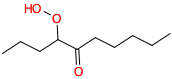

CCCC=C(CCCCC)OO + [O]O <=> CCCCC[C](OO)C(CCC)OO
CCCCC(C=C(CCC)OO)OO + [H] <=> CCCCC(C[C](CCC)OO)OO
CCC=C(CC(CCCC)OO)OO + [H] <=> CCCCC(C[C](CCC)OO)OO
C=C(CCC)OO + CCCC[CH]OO <=> CCCCC(C[C](CCC)OO)OO
C=C(CC(CCCC)OO)OO + C[CH2] <=> CCCCC(C[C](CCC)OO)OO
CCCCC(CC(=O)CCC)OO + [OH] <=> CCCCC(C[C](CCC)OO)OO


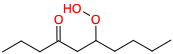

CCCCC(=CC(CCC)OO)OO + [H] <=> CCCC[C](CC(CCC)OO)OO
CCCC=C(CC(CCC)OO)OO + [H] <=> CCCC[C](CC(CCC)OO)OO
C=C(CCCC)OO + CCC[CH]OO <=> CCCC[C](CC(CCC)OO)OO
C=C(CC(CCC)OO)OO + [CH2]CC <=> CCCC[C](CC(CCC)OO)OO
CCCCC(=O)CC(CCC)OO + [OH] <=> CCCC[C](CC(CCC)OO)OO


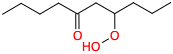

CCCCCCCC(OO)=C(C)OO + [H] <=> CCCCCCC[C](OO)C(C)OO
CCCCCCC=C(OO)C(C)OO + [H] <=> CCCCCCC[C](OO)C(C)OO
CCCCCCCC(=COO)OO + [CH3] <=> CCCCCCC[C](OO)C(C)OO
C=C(OO)C(C)OO + [CH2]CCCCC <=> CCCCCCC[C](OO)C(C)OO
CCCCCCCC(=O)C(C)OO + [OH] <=> CCCCCCC[C](OO)C(C)OO


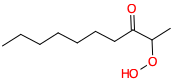

CC=C(CCCCCCC)OO + [O]O <=> CCCCCCC[C](OO)C(C)OO
CCCCCCCC(OO)=C(C)OO + [H] <=> CCCCCCCC(OO)[C](C)OO
C=C(OO)C(CCCCCCC)OO + [H] <=> CCCCCCCC(OO)[C](C)OO
CC(=COO)OO + [CH2]CCCCCC <=> CCCCCCCC(OO)[C](C)OO
CCCCCCCC(OO)C(C)=O + [OH] <=> CCCCCCCC(OO)[C](C)OO


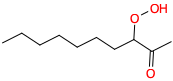

CCCCCCCC=C(C)OO + [O]O <=> CCCCCCCC(OO)[C](C)OO
CCCCCC(C=C(CC)OO)OO + [H] <=> CCCCCC(C[C](CC)OO)OO
CC=C(CC(CCCCC)OO)OO + [H] <=> CCCCCC(C[C](CC)OO)OO
C=C(CC)OO + CCCCC[CH]OO <=> CCCCCC(C[C](CC)OO)OO
C=C(CC(CCCCC)OO)OO + [CH3] <=> CCCCCC(C[C](CC)OO)OO
CCCCCC(CC(=O)CC)OO + [OH] <=> CCCCCC(C[C](CC)OO)OO


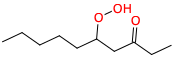

CCCCCCC(CC=COO)OO + [H] <=> CCCCCCC(CC[CH]OO)OO
C=COO + [CH2]C(CCCCCC)OO <=> CCCCCCC(CC[CH]OO)OO
CCCCCCC(CCC=O)OO + [OH] <=> CCCCCCC(CC[CH]OO)OO


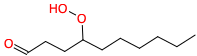

CCCC(CCC=C(CC)OO)OO + [H] <=> CCCC(CCC[C](CC)OO)OO
CC=C(CCCC(CCC)OO)OO + [H] <=> CCCC(CCC[C](CC)OO)OO
C=C(CC)OO + [CH2]CC(CCC)OO <=> CCCC(CCC[C](CC)OO)OO
C=C(CCCC(CCC)OO)OO + [CH3] <=> CCCC(CCC[C](CC)OO)OO
CCCC(CCCC(=O)CC)OO + [OH] <=> CCCC(CCC[C](CC)OO)OO


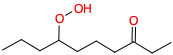

CCCC(=CCCC(CC)OO)OO + [H] <=> CCC[C](CCCC(CC)OO)OO
CCC=C(CCCC(CC)OO)OO + [H] <=> CCC[C](CCCC(CC)OO)OO
C=C(CCC)OO + [CH2]CC(CC)OO <=> CCC[C](CCCC(CC)OO)OO
C=C(CCCC(CC)OO)OO + C[CH2] <=> CCC[C](CCCC(CC)OO)OO
CCCC(=O)CCCC(CC)OO + [OH] <=> CCC[C](CCCC(CC)OO)OO


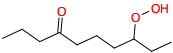

CCCCCCC(=CC(C)OO)OO + [H] <=> CCCCCC[C](CC(C)OO)OO
CCCCCC=C(CC(C)OO)OO + [H] <=> CCCCCC[C](CC(C)OO)OO
C=C(CCCCCC)OO + C[CH]OO <=> CCCCCC[C](CC(C)OO)OO
C=C(CC(C)OO)OO + [CH2]CCCC <=> CCCCCC[C](CC(C)OO)OO
CCCCCCC(=O)CC(C)OO + [OH] <=> CCCCCC[C](CC(C)OO)OO


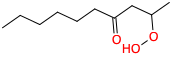

CCCCC(OO)=C(CCCC)OO + [H] <=> CCCC[C](OO)C(CCCC)OO
CCCC=C(OO)C(CCCC)OO + [H] <=> CCCC[C](OO)C(CCCC)OO
CCCCC(=COO)OO + [CH2]CCC <=> CCCC[C](OO)C(CCCC)OO
C=C(OO)C(CCCC)OO + [CH2]CC <=> CCCC[C](OO)C(CCCC)OO
CCCCC(=O)C(CCCC)OO + [OH] <=> CCCC[C](OO)C(CCCC)OO


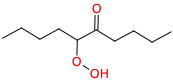

CCCCC=C(CCCC)OO + [O]O <=> CCCC[C](OO)C(CCCC)OO
CCCCCC=C(CCCOO)OO + [H] <=> CCCCCC[C](CCCOO)OO
CCCCCCC(=CCCOO)OO + [H] <=> CCCCCC[C](CCCOO)OO
C=C(CCCOO)OO + [CH2]CCCC <=> CCCCCC[C](CCCOO)OO
C=C(CCCCCC)OO + [CH2]COO <=> CCCCCC[C](CCCOO)OO
CCCCCCC(=O)CCCOO + [OH] <=> CCCCCC[C](CCCOO)OO


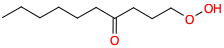

CCC=C(CCC(CCC)OO)OO + [H] <=> CCC[C](CCC(CCC)OO)OO
CCCC(=CCC(CCC)OO)OO + [H] <=> CCC[C](CCC(CCC)OO)OO
C=C(CCC(CCC)OO)OO + C[CH2] <=> CCC[C](CCC(CCC)OO)OO
C=C(CCC)OO + [CH2]C(CCC)OO <=> CCC[C](CCC(CCC)OO)OO
CCCC(=O)CCC(CCC)OO + [OH] <=> CCC[C](CCC(CCC)OO)OO


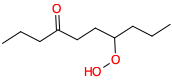

CCCCCCC(C=C(C)OO)OO + [H] <=> CCCCCCC(C[C](C)OO)OO
C=C(CC(CCCCCC)OO)OO + [H] <=> CCCCCCC(C[C](C)OO)OO
C=C(C)OO + CCCCCC[CH]OO <=> CCCCCCC(C[C](C)OO)OO
CCCCCCC(CC(C)=O)OO + [OH] <=> CCCCCCC(C[C](C)OO)OO


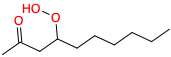

CCCCCC(=CC(CC)OO)OO + [H] <=> CCCCC[C](CC(CC)OO)OO
CCCCC=C(CC(CC)OO)OO + [H] <=> CCCCC[C](CC(CC)OO)OO
C=C(CCCCC)OO + CC[CH]OO <=> CCCCC[C](CC(CC)OO)OO
C=C(CC(CC)OO)OO + [CH2]CCC <=> CCCCC[C](CC(CC)OO)OO
CCCCCC(=O)CC(CC)OO + [OH] <=> CCCCC[C](CC(CC)OO)OO


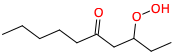

CCCCCCC(OO)=C(CC)OO + [H] <=> CCCCCCC(OO)[C](CC)OO
CC=C(OO)C(CCCCCC)OO + [H] <=> CCCCCCC(OO)[C](CC)OO
CCC(=COO)OO + [CH2]CCCCC <=> CCCCCCC(OO)[C](CC)OO
C=C(OO)C(CCCCCC)OO + [CH3] <=> CCCCCCC(OO)[C](CC)OO
CCCCCCC(OO)C(=O)CC + [OH] <=> CCCCCCC(OO)[C](CC)OO


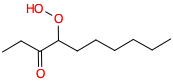

CCCCCCC=C(CC)OO + [O]O <=> CCCCCCC(OO)[C](CC)OO
CCCCCCC(OO)=C(CC)OO + [H] <=> CCCCCC[C](OO)C(CC)OO
CCCCCC=C(OO)C(CC)OO + [H] <=> CCCCCC[C](OO)C(CC)OO
CCCCCCC(=COO)OO + C[CH2] <=> CCCCCC[C](OO)C(CC)OO
C=C(OO)C(CC)OO + [CH2]CCCC <=> CCCCCC[C](OO)C(CC)OO
CCCCCCC(=O)C(CC)OO + [OH] <=> CCCCCC[C](OO)C(CC)OO


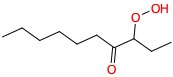

CCC=C(CCCCCC)OO + [O]O <=> CCCCCC[C](OO)C(CC)OO
CCCCC=C(CCCCOO)OO + [H] <=> CCCCC[C](CCCCOO)OO
CCCCCC(=CCCCOO)OO + [H] <=> CCCCC[C](CCCCOO)OO
C=C(CCCCOO)OO + [CH2]CCC <=> CCCCC[C](CCCCOO)OO
C=C(CCCCC)OO + [CH2]CCOO <=> CCCCC[C](CCCCOO)OO
CCCCCC(=O)CCCCOO + [OH] <=> CCCCC[C](CCCCOO)OO


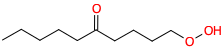

CCCCCC(CCC=COO)OO + [H] <=> CCCCCC(CCC[CH]OO)OO
C=COO + [CH2]CC(CCCCC)OO <=> CCCCCC(CCC[CH]OO)OO
CCCCCC(CCCC=O)OO + [OH] <=> CCCCCC(CCC[CH]OO)OO


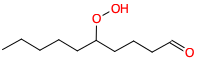

CCCC(CCCC=C(C)OO)OO + [H] <=> CCCC(CCCC[C](C)OO)OO
C=C(CCCCC(CCC)OO)OO + [H] <=> CCCC(CCCC[C](C)OO)OO
C=C(C)OO + [CH2]CCC(CCC)OO <=> CCCC(CCCC[C](C)OO)OO
CCCC(CCCCC(C)=O)OO + [OH] <=> CCCC(CCCC[C](C)OO)OO


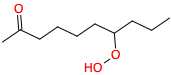

ketohydroperoxide


{Molecule(smiles="CCC(=O)CCCCC(CC)OO"),
 Molecule(smiles="CCCCC(CCCCC=O)OO"),
 Molecule(smiles="CCCCCCCCCC(=O)OO"),
 Molecule(smiles="CCCCC(=O)CCCCCOO"),
 Molecule(smiles="CCCCCCCCC(C=O)OO"),
 Molecule(smiles="CCCCCCCCC(=O)COO"),
 Molecule(smiles="CCCCC(=O)CCCC(C)OO"),
 Molecule(smiles="CCCCC(CCCC(C)=O)OO"),
 Molecule(smiles="CCCCCCCC(=O)CCOO"),
 Molecule(smiles="CCCCCCCC(CC=O)OO"),
 Molecule(smiles="CCCCCC(CCC(C)=O)OO"),
 Molecule(smiles="CCCC(=O)CCCCC(C)OO"),
 Molecule(smiles="CCCCC(CCC(=O)CC)OO"),
 Molecule(smiles="CCCCC(=O)CCC(CC)OO"),
 Molecule(smiles="CCCCCC(OO)C(=O)CCC"),
 Molecule(smiles="CCCCCC(=O)C(CCC)OO"),
 Molecule(smiles="CCCCC(CC(=O)CCC)OO"),
 Molecule(smiles="CCCCCC(=O)CCC(C)OO"),
 Molecule(smiles="CCCCC(=O)CC(CCC)OO"),
 Molecule(smiles="CCCCCCCC(=O)C(C)OO"),
 Molecule(smiles="CCCCCCCC(OO)C(C)=O"),
 Molecule(smiles="CCCCCC(CC(=O)CC)OO"),
 Molecule(smiles="CCCCCCC(CCC=O)OO"),
 Molecule(smiles="CCCC(CCCC(=O)CC)OO"),
 Molecule(smiles="CCCC(=O)CCCC(CC)OO"),
 Molecule(smiles

In [21]:
# HOOQjOOH now beta scissions to OH + ketohydroperoxide
print("Applying R_Addition_MultipleBond to HOOQjOOH to find its Beta Scission products")
for s in molecules['HOOQjOOH']:
    reactions = rmg.database.kinetics.generate_reactions_from_families((s,), only_families='R_Addition_MultipleBond')
    for r in reactions:
        print(r)
        r1 = r.reactants[0].molecule[0]
        r2 = r.reactants[1].molecule[0]
        if r2.get_formula() == 'HO':
            display(r1)
            molecules['ketohydroperoxide'].add(r1)

print('ketohydroperoxide')
molecules['ketohydroperoxide']

[OH] + CCC(=O)CCCCC([O])CC <=> CCC(=O)CCCCC(CC)OO


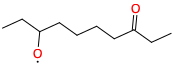

[O]O + CC[CH]CCCCC(=O)CC <=> CCC(=O)CCCCC(CC)OO
[H] + CCC(=O)CCCCC(CC)O[O] <=> CCC(=O)CCCCC(CC)OO
CC[CH]OO + [CH2]CCCC(=O)CC <=> CCC(=O)CCCCC(CC)OO
CCC(=O)CCCC[CH]OO + C[CH2] <=> CCC(=O)CCCCC(CC)OO
CC[C](CCCCC(=O)CC)OO + [H] <=> CCC(=O)CCCCC(CC)OO
[CH2]C(CC)OO + [CH2]CCC(=O)CC <=> CCC(=O)CCCCC(CC)OO
CCC(=O)CCC[CH]C(CC)OO + [H] <=> CCC(=O)CCCCC(CC)OO
[CH2]CC(CC)OO + [CH2]CC(=O)CC <=> CCC(=O)CCCCC(CC)OO
CCC(=O)CC[CH]CC(CC)OO + [H] <=> CCC(=O)CCCCC(CC)OO
[CH2]CCC(CC)OO + [CH2]C(=O)CC <=> CCC(=O)CCCCC(CC)OO
CCC(=O)C[CH]CCC(CC)OO + [H] <=> CCC(=O)CCCCC(CC)OO
[CH2]C(CCCCC(=O)CC)OO + [CH3] <=> CCC(=O)CCCCC(CC)OO
C[CH]C(CCCCC(=O)CC)OO + [H] <=> CCC(=O)CCCCC(CC)OO
[CH2]CCCC(CC)OO + CC[C]=O <=> CCC(=O)CCCCC(CC)OO
CCC(=O)[CH]CCCC(CC)OO + [H] <=> CCC(=O)CCCCC(CC)OO
[CH2]C(=O)CCCCC(CC)OO + [CH3] <=> CCC(=O)CCCCC(CC)OO
CCC(CCCC[C]=O)OO + C[CH2] <=> CCC(=O)CCCCC(CC)OO
C[CH]C(=O)CCCCC(CC)OO + [H] <=> CCC(=O)CCCCC(CC)OO
[CH2]CC(CCCCC(=O)CC)OO + [H] <=> CCC(=O)CCCCC(CC)OO
[CH2]CC(=O)CCCCC(CC)OO + [H] <=

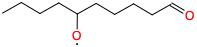

[O]O + CCCC[CH]CCCCC=O <=> CCCCC(CCCCC=O)OO
[H] + CCCCC(CCCCC=O)O[O] <=> CCCCC(CCCCC=O)OO
O=CCCCC[CH]OO + [CH2]CCC <=> CCCCC(CCCCC=O)OO
CCCC[CH]OO + [CH2]CCCC=O <=> CCCCC(CCCCC=O)OO
CCCC[C](CCCCC=O)OO + [H] <=> CCCCC(CCCCC=O)OO
[CH2]C(CCCCC=O)OO + [CH2]CC <=> CCCCC(CCCCC=O)OO
CCC[CH]C(CCCCC=O)OO + [H] <=> CCCCC(CCCCC=O)OO
[CH2]C(CCCC)OO + [CH2]CCC=O <=> CCCCC(CCCCC=O)OO
CCCCC([CH]CCCC=O)OO + [H] <=> CCCCC(CCCCC=O)OO
[CH2]CC(CCCCC=O)OO + C[CH2] <=> CCCCC(CCCCC=O)OO
CC[CH]CC(CCCCC=O)OO + [H] <=> CCCCC(CCCCC=O)OO
[CH2]CC(CCCC)OO + [CH2]CC=O <=> CCCCC(CCCCC=O)OO
CCCCC(C[CH]CCC=O)OO + [H] <=> CCCCC(CCCCC=O)OO
[CH2]CCC(CCCC)OO + [CH2]C=O <=> CCCCC(CCCCC=O)OO
CCCCC(CC[CH]CC=O)OO + [H] <=> CCCCC(CCCCC=O)OO
[CH2]CCC(CCCCC=O)OO + [CH3] <=> CCCCC(CCCCC=O)OO
C[CH]CCC(CCCCC=O)OO + [H] <=> CCCCC(CCCCC=O)OO
[CH2]CCCC(CCCC)OO + [CH]=O <=> CCCCC(CCCCC=O)OO
CCCCC(CCC[CH]C=O)OO + [H] <=> CCCCC(CCCCC=O)OO
[CH2]CCCC(CCCCC=O)OO + [H] <=> CCCCC(CCCCC=O)OO
CCCCC(CCCC[C]=O)OO + [H] <=> CCCCC(CCCCC=O)OO
[OH] + 

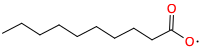

[O]O + CCCCCCCCC[C]=O <=> CCCCCCCCCC(=O)OO
[H] + CCCCCCCCCC(=O)O[O] <=> CCCCCCCCCC(=O)OO
[CH2]CCCCCC(=O)OO + [CH2]CC <=> CCCCCCCCCC(=O)OO
[CH2]CCCCCCC(=O)OO + C[CH2] <=> CCCCCCCCCC(=O)OO
CC[CH]CCCCCCC(=O)OO + [H] <=> CCCCCCCCCC(=O)OO
[CH2]CCCCC(=O)OO + [CH2]CCC <=> CCCCCCCCCC(=O)OO
CCC[CH]CCCCCC(=O)OO + [H] <=> CCCCCCCCCC(=O)OO
[CH2]CCCC(=O)OO + [CH2]CCCC <=> CCCCCCCCCC(=O)OO
CCCC[CH]CCCCC(=O)OO + [H] <=> CCCCCCCCCC(=O)OO
[CH2]CCC(=O)OO + [CH2]CCCCC <=> CCCCCCCCCC(=O)OO
CCCCC[CH]CCCC(=O)OO + [H] <=> CCCCCCCCCC(=O)OO
[CH2]CC(=O)OO + [CH2]CCCCCC <=> CCCCCCCCCC(=O)OO
CCCCCC[CH]CCC(=O)OO + [H] <=> CCCCCCCCCC(=O)OO
[CH2]C(=O)OO + [CH2]CCCCCCC <=> CCCCCCCCCC(=O)OO
CCCCCCC[CH]CC(=O)OO + [H] <=> CCCCCCCCCC(=O)OO
[CH2]CCCCCCCC(=O)OO + [CH3] <=> CCCCCCCCCC(=O)OO
C[CH]CCCCCCCC(=O)OO + [H] <=> CCCCCCCCCC(=O)OO
O=[C]OO + [CH2]CCCCCCCC <=> CCCCCCCCCC(=O)OO
CCCCCCCC[CH]C(=O)OO + [H] <=> CCCCCCCCCC(=O)OO
[CH2]CCCCCCCCC(=O)OO + [H] <=> CCCCCCCCCC(=O)OO
[OH] + CCCCC(=O)CCCCC[O] <=> CCCCC(=O)CCCCCOO


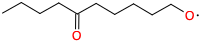

[O]O + [CH2]CCCCC(=O)CCCC <=> CCCCC(=O)CCCCCOO
[H] + CCCCC(=O)CCCCCO[O] <=> CCCCC(=O)CCCCCOO
[CH2]CCOO + [CH2]CC(=O)CCCC <=> CCCCC(=O)CCCCCOO
[CH2]COO + [CH2]CCC(=O)CCCC <=> CCCCC(=O)CCCCCOO
CCCCC(=O)CC[CH]CCOO + [H] <=> CCCCC(=O)CCCCCOO
[CH2]CCCOO + [CH2]C(=O)CCCC <=> CCCCC(=O)CCCCCOO
CCCCC(=O)C[CH]CCCOO + [H] <=> CCCCC(=O)CCCCCOO
[CH2]CC(=O)CCCCCOO + C[CH2] <=> CCCCC(=O)CCCCCOO
[CH2]C(=O)CCCCCOO + [CH2]CC <=> CCCCC(=O)CCCCCOO
CC[CH]CC(=O)CCCCCOO + [H] <=> CCCCC(=O)CCCCCOO
[CH2]OO + [CH2]CCCC(=O)CCCC <=> CCCCC(=O)CCCCCOO
CCCCC(=O)CCC[CH]COO + [H] <=> CCCCC(=O)CCCCCOO
[CH2]CCC(=O)CCCCCOO + [CH3] <=> CCCCC(=O)CCCCCOO
C[CH]CCC(=O)CCCCCOO + [H] <=> CCCCC(=O)CCCCCOO
[CH2]CCCCOO + CCCC[C]=O <=> CCCCC(=O)CCCCCOO
CCCCC(=O)[CH]CCCCOO + [H] <=> CCCCC(=O)CCCCCOO
O=[C]CCCCCOO + [CH2]CCC <=> CCCCC(=O)CCCCCOO
CCC[CH]C(=O)CCCCCOO + [H] <=> CCCCC(=O)CCCCCOO
CCCCC(=O)CCCC[CH]OO + [H] <=> CCCCC(=O)CCCCCOO
[CH2]CCCC(=O)CCCCCOO + [H] <=> CCCCC(=O)CCCCCOO
[OH] + CCCCCCCCC([O])C=O <=> CCCCCCCCC(C=O)OO


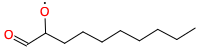

[O]O + CCCCCCCC[CH]C=O <=> CCCCCCCCC(C=O)OO
[H] + CCCCCCCCC(C=O)O[O] <=> CCCCCCCCC(C=O)OO
[CH2]C(C=O)OO + [CH2]CCCCCC <=> CCCCCCCCC(C=O)OO
O=C[CH]OO + [CH2]CCCCCCC <=> CCCCCCCCC(C=O)OO
CCCCCCC[CH]C(C=O)OO + [H] <=> CCCCCCCCC(C=O)OO
[CH2]CC(C=O)OO + [CH2]CCCCC <=> CCCCCCCCC(C=O)OO
CCCCCC[CH]CC(C=O)OO + [H] <=> CCCCCCCCC(C=O)OO
[CH2]CCC(C=O)OO + [CH2]CCCC <=> CCCCCCCCC(C=O)OO
CCCCC[CH]CCC(C=O)OO + [H] <=> CCCCCCCCC(C=O)OO
[CH2]CCCC(C=O)OO + [CH2]CCC <=> CCCCCCCCC(C=O)OO
CCCC[CH]CCCC(C=O)OO + [H] <=> CCCCCCCCC(C=O)OO
[CH2]CCCCC(C=O)OO + [CH2]CC <=> CCCCCCCCC(C=O)OO
CCC[CH]CCCCC(C=O)OO + [H] <=> CCCCCCCCC(C=O)OO
[CH2]CCCCCC(C=O)OO + C[CH2] <=> CCCCCCCCC(C=O)OO
CC[CH]CCCCCC(C=O)OO + [H] <=> CCCCCCCCC(C=O)OO
CCCCCCCC[CH]OO + [CH]=O <=> CCCCCCCCC(C=O)OO
CCCCCCCC[C](C=O)OO + [H] <=> CCCCCCCCC(C=O)OO
[CH2]CCCCCCC(C=O)OO + [CH3] <=> CCCCCCCCC(C=O)OO
C[CH]CCCCCCC(C=O)OO + [H] <=> CCCCCCCCC(C=O)OO
[CH2]CCCCCCCC(C=O)OO + [H] <=> CCCCCCCCC(C=O)OO
CCCCCCCCC([C]=O)OO + [H] <=> CCCCCCCCC(C=O)OO
[OH] + 

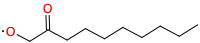

[O]O + [CH2]C(=O)CCCCCCCC <=> CCCCCCCCC(=O)COO
[H] + CCCCCCCCC(=O)CO[O] <=> CCCCCCCCC(=O)COO
[CH2]CCCCC(=O)COO + [CH2]CC <=> CCCCCCCCC(=O)COO
[CH2]CCCCCC(=O)COO + C[CH2] <=> CCCCCCCCC(=O)COO
CC[CH]CCCCCC(=O)COO + [H] <=> CCCCCCCCC(=O)COO
[CH2]CCCC(=O)COO + [CH2]CCC <=> CCCCCCCCC(=O)COO
CCC[CH]CCCCC(=O)COO + [H] <=> CCCCCCCCC(=O)COO
[CH2]CCC(=O)COO + [CH2]CCCC <=> CCCCCCCCC(=O)COO
CCCC[CH]CCCC(=O)COO + [H] <=> CCCCCCCCC(=O)COO
[CH2]CC(=O)COO + [CH2]CCCCC <=> CCCCCCCCC(=O)COO
CCCCC[CH]CCC(=O)COO + [H] <=> CCCCCCCCC(=O)COO
[CH2]C(=O)COO + [CH2]CCCCCC <=> CCCCCCCCC(=O)COO
CCCCCC[CH]CC(=O)COO + [H] <=> CCCCCCCCC(=O)COO
[CH2]CCCCCCC(=O)COO + [CH3] <=> CCCCCCCCC(=O)COO
C[CH]CCCCCCC(=O)COO + [H] <=> CCCCCCCCC(=O)COO
O=[C]COO + [CH2]CCCCCCC <=> CCCCCCCCC(=O)COO
CCCCCCC[CH]C(=O)COO + [H] <=> CCCCCCCCC(=O)COO
[CH2]OO + CCCCCCCC[C]=O <=> CCCCCCCCC(=O)COO
CCCCCCCCC(=O)[CH]OO + [H] <=> CCCCCCCCC(=O)COO
[CH2]CCCCCCCC(=O)COO + [H] <=> CCCCCCCCC(=O)COO
[OH] + CCCCC(=O)CCCC(C)[O] <=> CCCCC(=O)CCCC(C)OO


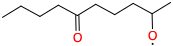

[O]O + C[CH]CCCC(=O)CCCC <=> CCCCC(=O)CCCC(C)OO
[H] + CCCCC(=O)CCCC(C)O[O] <=> CCCCC(=O)CCCC(C)OO
C[CH]OO + [CH2]CCC(=O)CCCC <=> CCCCC(=O)CCCC(C)OO
CCCCC(=O)CCC[CH]OO + [CH3] <=> CCCCC(=O)CCCC(C)OO
CCCCC(=O)CCC[C](C)OO + [H] <=> CCCCC(=O)CCCC(C)OO
[CH2]C(C)OO + [CH2]CC(=O)CCCC <=> CCCCC(=O)CCCC(C)OO
CCCCC(=O)CC[CH]C(C)OO + [H] <=> CCCCC(=O)CCCC(C)OO
[CH2]CC(C)OO + [CH2]C(=O)CCCC <=> CCCCC(=O)CCCC(C)OO
CCCCC(=O)C[CH]CC(C)OO + [H] <=> CCCCC(=O)CCCC(C)OO
[CH2]CC(=O)CCCC(C)OO + C[CH2] <=> CCCCC(=O)CCCC(C)OO
[CH2]C(=O)CCCC(C)OO + [CH2]CC <=> CCCCC(=O)CCCC(C)OO
CC[CH]CC(=O)CCCC(C)OO + [H] <=> CCCCC(=O)CCCC(C)OO
[CH2]CCC(=O)CCCC(C)OO + [CH3] <=> CCCCC(=O)CCCC(C)OO
C[CH]CCC(=O)CCCC(C)OO + [H] <=> CCCCC(=O)CCCC(C)OO
[CH2]CCC(C)OO + CCCC[C]=O <=> CCCCC(=O)CCCC(C)OO
CCCCC(=O)[CH]CCC(C)OO + [H] <=> CCCCC(=O)CCCC(C)OO
CC(CCC[C]=O)OO + [CH2]CCC <=> CCCCC(=O)CCCC(C)OO
CCC[CH]C(=O)CCCC(C)OO + [H] <=> CCCCC(=O)CCCC(C)OO
[CH2]C(CCCC(=O)CCCC)OO + [H] <=> CCCCC(=O)CCCC(C)OO
[CH2]CCCC(=O)CCCC(C)OO + [H] <=

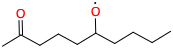

[O]O + CCCC[CH]CCCC(C)=O <=> CCCCC(CCCC(C)=O)OO
[H] + CCCCC(CCCC(C)=O)O[O] <=> CCCCC(CCCC(C)=O)OO
CC(=O)CCC[CH]OO + [CH2]CCC <=> CCCCC(CCCC(C)=O)OO
CCCC[CH]OO + [CH2]CCC(C)=O <=> CCCCC(CCCC(C)=O)OO
CCCC[C](CCCC(C)=O)OO + [H] <=> CCCCC(CCCC(C)=O)OO
[CH2]C(CCCC(C)=O)OO + [CH2]CC <=> CCCCC(CCCC(C)=O)OO
CCC[CH]C(CCCC(C)=O)OO + [H] <=> CCCCC(CCCC(C)=O)OO
[CH2]C(CCCC)OO + [CH2]CC(C)=O <=> CCCCC(CCCC(C)=O)OO
CCCCC([CH]CCC(C)=O)OO + [H] <=> CCCCC(CCCC(C)=O)OO
[CH2]CC(CCCC(C)=O)OO + C[CH2] <=> CCCCC(CCCC(C)=O)OO
CC[CH]CC(CCCC(C)=O)OO + [H] <=> CCCCC(CCCC(C)=O)OO
[CH2]CC(CCCC)OO + [CH2]C(C)=O <=> CCCCC(CCCC(C)=O)OO
CCCCC(C[CH]CC(C)=O)OO + [H] <=> CCCCC(CCCC(C)=O)OO
[CH2]CCC(CCCC(C)=O)OO + [CH3] <=> CCCCC(CCCC(C)=O)OO
C[CH]CCC(CCCC(C)=O)OO + [H] <=> CCCCC(CCCC(C)=O)OO
[CH2]CCC(CCCC)OO + C[C]=O <=> CCCCC(CCCC(C)=O)OO
CCCCC(CC[CH]C(C)=O)OO + [H] <=> CCCCC(CCCC(C)=O)OO
[CH2]CCCC(CCCC(C)=O)OO + [H] <=> CCCCC(CCCC(C)=O)OO
CCCCC(CCC[C]=O)OO + [CH3] <=> CCCCC(CCCC(C)=O)OO
[CH2]C(=O)CCCC(CCCC)OO + [H] <=

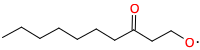

[O]O + [CH2]CC(=O)CCCCCCC <=> CCCCCCCC(=O)CCOO
[H] + CCCCCCCC(=O)CCO[O] <=> CCCCCCCC(=O)CCOO
[CH2]CCC(=O)CCOO + [CH2]CCC <=> CCCCCCCC(=O)CCOO
[CH2]CC(=O)CCOO + [CH2]CCCC <=> CCCCCCCC(=O)CCOO
CCCC[CH]CCC(=O)CCOO + [H] <=> CCCCCCCC(=O)CCOO
[CH2]CCCC(=O)CCOO + [CH2]CC <=> CCCCCCCC(=O)CCOO
CCC[CH]CCCC(=O)CCOO + [H] <=> CCCCCCCC(=O)CCOO
[CH2]CCCCC(=O)CCOO + C[CH2] <=> CCCCCCCC(=O)CCOO
CC[CH]CCCCC(=O)CCOO + [H] <=> CCCCCCCC(=O)CCOO
[CH2]C(=O)CCOO + [CH2]CCCCC <=> CCCCCCCC(=O)CCOO
CCCCC[CH]CC(=O)CCOO + [H] <=> CCCCCCCC(=O)CCOO
[CH2]CCCCCC(=O)CCOO + [CH3] <=> CCCCCCCC(=O)CCOO
C[CH]CCCCCC(=O)CCOO + [H] <=> CCCCCCCC(=O)CCOO
O=[C]CCOO + [CH2]CCCCCC <=> CCCCCCCC(=O)CCOO
CCCCCC[CH]C(=O)CCOO + [H] <=> CCCCCCCC(=O)CCOO
[CH2]OO + [CH2]C(=O)CCCCCCC <=> CCCCCCCC(=O)CCOO
[CH2]COO + CCCCCCC[C]=O <=> CCCCCCCC(=O)CCOO
CCCCCCCC(=O)[CH]COO + [H] <=> CCCCCCCC(=O)CCOO
CCCCCCCC(=O)C[CH]OO + [H] <=> CCCCCCCC(=O)CCOO
[CH2]CCCCCCC(=O)CCOO + [H] <=> CCCCCCCC(=O)CCOO
[OH] + CCCCCCCC([O])CC=O <=> CCCCCCCC(CC=O)OO


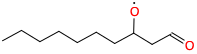

[O]O + CCCCCCC[CH]CC=O <=> CCCCCCCC(CC=O)OO
[H] + CCCCCCCC(CC=O)O[O] <=> CCCCCCCC(CC=O)OO
O=CC[CH]OO + [CH2]CCCCCC <=> CCCCCCCC(CC=O)OO
CCCCCCC[CH]OO + [CH2]C=O <=> CCCCCCCC(CC=O)OO
CCCCCCC[C](CC=O)OO + [H] <=> CCCCCCCC(CC=O)OO
[CH2]C(CC=O)OO + [CH2]CCCCC <=> CCCCCCCC(CC=O)OO
CCCCCC[CH]C(CC=O)OO + [H] <=> CCCCCCCC(CC=O)OO
[CH2]CCCC(CC=O)OO + [CH2]CC <=> CCCCCCCC(CC=O)OO
[CH2]CCCCC(CC=O)OO + C[CH2] <=> CCCCCCCC(CC=O)OO
CC[CH]CCCCC(CC=O)OO + [H] <=> CCCCCCCC(CC=O)OO
[CH2]CCC(CC=O)OO + [CH2]CCC <=> CCCCCCCC(CC=O)OO
CCC[CH]CCCC(CC=O)OO + [H] <=> CCCCCCCC(CC=O)OO
[CH2]CC(CC=O)OO + [CH2]CCCC <=> CCCCCCCC(CC=O)OO
CCCC[CH]CCC(CC=O)OO + [H] <=> CCCCCCCC(CC=O)OO
CCCCC[CH]CC(CC=O)OO + [H] <=> CCCCCCCC(CC=O)OO
[CH2]CCCCCC(CC=O)OO + [CH3] <=> CCCCCCCC(CC=O)OO
C[CH]CCCCCC(CC=O)OO + [H] <=> CCCCCCCC(CC=O)OO
[CH2]C(CCCCCCC)OO + [CH]=O <=> CCCCCCCC(CC=O)OO
CCCCCCCC([CH]C=O)OO + [H] <=> CCCCCCCC(CC=O)OO
[CH2]CCCCCCC(CC=O)OO + [H] <=> CCCCCCCC(CC=O)OO
CCCCCCCC(C[C]=O)OO + [H] <=> CCCCCCCC(CC=O)OO
[OH] + 

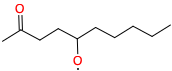

[O]O + CCCCC[CH]CCC(C)=O <=> CCCCCC(CCC(C)=O)OO
[H] + CCCCCC(CCC(C)=O)O[O] <=> CCCCCC(CCC(C)=O)OO
CC(=O)CC[CH]OO + [CH2]CCCC <=> CCCCCC(CCC(C)=O)OO
CCCCC[CH]OO + [CH2]CC(C)=O <=> CCCCCC(CCC(C)=O)OO
CCCCC[C](CCC(C)=O)OO + [H] <=> CCCCCC(CCC(C)=O)OO
[CH2]C(CCC(C)=O)OO + [CH2]CCC <=> CCCCCC(CCC(C)=O)OO
CCCC[CH]C(CCC(C)=O)OO + [H] <=> CCCCCC(CCC(C)=O)OO
[CH2]C(CCCCC)OO + [CH2]C(C)=O <=> CCCCCC(CCC(C)=O)OO
CCCCCC([CH]CC(C)=O)OO + [H] <=> CCCCCC(CCC(C)=O)OO
[CH2]CC(CCC(C)=O)OO + [CH2]CC <=> CCCCCC(CCC(C)=O)OO
[CH2]CCC(CCC(C)=O)OO + C[CH2] <=> CCCCCC(CCC(C)=O)OO
CC[CH]CCC(CCC(C)=O)OO + [H] <=> CCCCCC(CCC(C)=O)OO
CCC[CH]CC(CCC(C)=O)OO + [H] <=> CCCCCC(CCC(C)=O)OO
[CH2]CCCC(CCC(C)=O)OO + [CH3] <=> CCCCCC(CCC(C)=O)OO
C[CH]CCCC(CCC(C)=O)OO + [H] <=> CCCCCC(CCC(C)=O)OO
[CH2]CC(CCCCC)OO + C[C]=O <=> CCCCCC(CCC(C)=O)OO
CCCCCC(C[CH]C(C)=O)OO + [H] <=> CCCCCC(CCC(C)=O)OO
[CH2]CCCCC(CCC(C)=O)OO + [H] <=> CCCCCC(CCC(C)=O)OO
CCCCCC(CC[C]=O)OO + [CH3] <=> CCCCCC(CCC(C)=O)OO
[CH2]C(=O)CCC(CCCCC)OO + [H] <=

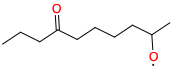

[O]O + C[CH]CCCCC(=O)CCC <=> CCCC(=O)CCCCC(C)OO
[H] + CCCC(=O)CCCCC(C)O[O] <=> CCCC(=O)CCCCC(C)OO
C[CH]OO + [CH2]CCCC(=O)CCC <=> CCCC(=O)CCCCC(C)OO
CCCC(=O)CCCC[CH]OO + [CH3] <=> CCCC(=O)CCCCC(C)OO
CCCC(=O)CCCC[C](C)OO + [H] <=> CCCC(=O)CCCCC(C)OO
[CH2]C(C)OO + [CH2]CCC(=O)CCC <=> CCCC(=O)CCCCC(C)OO
CCCC(=O)CCC[CH]C(C)OO + [H] <=> CCCC(=O)CCCCC(C)OO
[CH2]CC(C)OO + [CH2]CC(=O)CCC <=> CCCC(=O)CCCCC(C)OO
CCCC(=O)CC[CH]CC(C)OO + [H] <=> CCCC(=O)CCCCC(C)OO
[CH2]CCC(C)OO + [CH2]C(=O)CCC <=> CCCC(=O)CCCCC(C)OO
CCCC(=O)C[CH]CCC(C)OO + [H] <=> CCCC(=O)CCCCC(C)OO
[CH2]C(=O)CCCCC(C)OO + C[CH2] <=> CCCC(=O)CCCCC(C)OO
[CH2]CC(=O)CCCCC(C)OO + [CH3] <=> CCCC(=O)CCCCC(C)OO
C[CH]CC(=O)CCCCC(C)OO + [H] <=> CCCC(=O)CCCCC(C)OO
[CH2]CCCC(C)OO + CCC[C]=O <=> CCCC(=O)CCCCC(C)OO
CCCC(=O)[CH]CCCC(C)OO + [H] <=> CCCC(=O)CCCCC(C)OO
CC(CCCC[C]=O)OO + [CH2]CC <=> CCCC(=O)CCCCC(C)OO
CC[CH]C(=O)CCCCC(C)OO + [H] <=> CCCC(=O)CCCCC(C)OO
[CH2]C(CCCCC(=O)CCC)OO + [H] <=> CCCC(=O)CCCCC(C)OO
[CH2]CCC(=O)CCCCC(C)OO + [H] <=

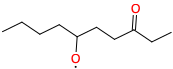

[O]O + CCCC[CH]CCC(=O)CC <=> CCCCC(CCC(=O)CC)OO
[H] + CCCCC(CCC(=O)CC)O[O] <=> CCCCC(CCC(=O)CC)OO
CCC(=O)CC[CH]OO + [CH2]CCC <=> CCCCC(CCC(=O)CC)OO
CCCC[CH]OO + [CH2]CC(=O)CC <=> CCCCC(CCC(=O)CC)OO
CCCC[C](CCC(=O)CC)OO + [H] <=> CCCCC(CCC(=O)CC)OO
[CH2]C(CCC(=O)CC)OO + [CH2]CC <=> CCCCC(CCC(=O)CC)OO
CCC[CH]C(CCC(=O)CC)OO + [H] <=> CCCCC(CCC(=O)CC)OO
[CH2]C(CCCC)OO + [CH2]C(=O)CC <=> CCCCC(CCC(=O)CC)OO
CCCCC([CH]CC(=O)CC)OO + [H] <=> CCCCC(CCC(=O)CC)OO
[CH2]CC(CCC(=O)CC)OO + C[CH2] <=> CCCCC(CCC(=O)CC)OO
CC[CH]CC(CCC(=O)CC)OO + [H] <=> CCCCC(CCC(=O)CC)OO
[CH2]CCC(CCC(=O)CC)OO + [CH3] <=> CCCCC(CCC(=O)CC)OO
C[CH]CCC(CCC(=O)CC)OO + [H] <=> CCCCC(CCC(=O)CC)OO
[CH2]CC(CCCC)OO + CC[C]=O <=> CCCCC(CCC(=O)CC)OO
CCCCC(C[CH]C(=O)CC)OO + [H] <=> CCCCC(CCC(=O)CC)OO
[CH2]C(=O)CCC(CCCC)OO + [CH3] <=> CCCCC(CCC(=O)CC)OO
CCCCC(CC[C]=O)OO + C[CH2] <=> CCCCC(CCC(=O)CC)OO
C[CH]C(=O)CCC(CCCC)OO + [H] <=> CCCCC(CCC(=O)CC)OO
[CH2]CCCC(CCC(=O)CC)OO + [H] <=> CCCCC(CCC(=O)CC)OO
[CH2]CC(=O)CCC(CCCC)OO + [H] <=

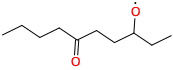

[O]O + CC[CH]CCC(=O)CCCC <=> CCCCC(=O)CCC(CC)OO
[H] + CCCCC(=O)CCC(CC)O[O] <=> CCCCC(=O)CCC(CC)OO
CC[CH]OO + [CH2]CC(=O)CCCC <=> CCCCC(=O)CCC(CC)OO
CCCCC(=O)CC[CH]OO + C[CH2] <=> CCCCC(=O)CCC(CC)OO
CCCCC(=O)CC[C](CC)OO + [H] <=> CCCCC(=O)CCC(CC)OO
[CH2]C(CC)OO + [CH2]C(=O)CCCC <=> CCCCC(=O)CCC(CC)OO
CCCCC(=O)C[CH]C(CC)OO + [H] <=> CCCCC(=O)CCC(CC)OO
[CH2]CC(=O)CCC(CC)OO + C[CH2] <=> CCCCC(=O)CCC(CC)OO
[CH2]C(=O)CCC(CC)OO + [CH2]CC <=> CCCCC(=O)CCC(CC)OO
CC[CH]CC(=O)CCC(CC)OO + [H] <=> CCCCC(=O)CCC(CC)OO
[CH2]C(CCC(=O)CCCC)OO + [CH3] <=> CCCCC(=O)CCC(CC)OO
C[CH]C(CCC(=O)CCCC)OO + [H] <=> CCCCC(=O)CCC(CC)OO
[CH2]CCC(=O)CCC(CC)OO + [CH3] <=> CCCCC(=O)CCC(CC)OO
C[CH]CCC(=O)CCC(CC)OO + [H] <=> CCCCC(=O)CCC(CC)OO
CCC(CC[C]=O)OO + [CH2]CCC <=> CCCCC(=O)CCC(CC)OO
CCC[CH]C(=O)CCC(CC)OO + [H] <=> CCCCC(=O)CCC(CC)OO
[CH2]CC(CC)OO + CCCC[C]=O <=> CCCCC(=O)CCC(CC)OO
CCCCC(=O)[CH]CC(CC)OO + [H] <=> CCCCC(=O)CCC(CC)OO
[CH2]CCCC(=O)CCC(CC)OO + [H] <=> CCCCC(=O)CCC(CC)OO
[CH2]CC(CCC(=O)CCCC)OO + [H] <=

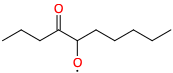

[O]O + CCCCC[CH]C(=O)CCC <=> CCCCCC(OO)C(=O)CCC
[H] + CCCCCC(O[O])C(=O)CCC <=> CCCCCC(OO)C(=O)CCC
CCCC(=O)[CH]OO + [CH2]CCCC <=> CCCCCC(OO)C(=O)CCC
CCCCC[CH]OO + CCC[C]=O <=> CCCCCC(OO)C(=O)CCC
CCCCC[C](OO)C(=O)CCC + [H] <=> CCCCCC(OO)C(=O)CCC
[CH2]C(OO)C(=O)CCC + [CH2]CCC <=> CCCCCC(OO)C(=O)CCC
CCCC[CH]C(OO)C(=O)CCC + [H] <=> CCCCCC(OO)C(=O)CCC
[CH2]CC(OO)C(=O)CCC + [CH2]CC <=> CCCCCC(OO)C(=O)CCC
CCC[CH]CC(OO)C(=O)CCC + [H] <=> CCCCCC(OO)C(=O)CCC
[CH2]CCC(OO)C(=O)CCC + C[CH2] <=> CCCCCC(OO)C(=O)CCC
CC[CH]CCC(OO)C(=O)CCC + [H] <=> CCCCCC(OO)C(=O)CCC
[CH2]CCCC(OO)C(=O)CCC + [CH3] <=> CCCCCC(OO)C(=O)CCC
C[CH]CCCC(OO)C(=O)CCC + [H] <=> CCCCCC(OO)C(=O)CCC
[CH2]C(=O)C(CCCCC)OO + C[CH2] <=> CCCCCC(OO)C(=O)CCC
[CH2]CC(=O)C(CCCCC)OO + [CH3] <=> CCCCCC(OO)C(=O)CCC
C[CH]CC(=O)C(CCCCC)OO + [H] <=> CCCCCC(OO)C(=O)CCC
CCCCCC([C]=O)OO + [CH2]CC <=> CCCCCC(OO)C(=O)CCC
CC[CH]C(=O)C(CCCCC)OO + [H] <=> CCCCCC(OO)C(=O)CCC
[CH2]CCC(=O)C(CCCCC)OO + [H] <=> CCCCCC(OO)C(=O)CCC
[CH2]CCCCC(OO)C(=O)CCC + [H] <=

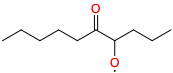

[O]O + CCC[CH]C(=O)CCCCC <=> CCCCCC(=O)C(CCC)OO
[H] + CCCCCC(=O)C(CCC)O[O] <=> CCCCCC(=O)C(CCC)OO
CCCCCC(=O)[CH]OO + [CH2]CC <=> CCCCCC(=O)C(CCC)OO
CCC[CH]OO + CCCCC[C]=O <=> CCCCCC(=O)C(CCC)OO
CCCCCC(=O)[C](CCC)OO + [H] <=> CCCCCC(=O)C(CCC)OO
[CH2]C(OO)C(=O)CCCCC + C[CH2] <=> CCCCCC(=O)C(CCC)OO
CC[CH]C(OO)C(=O)CCCCC + [H] <=> CCCCCC(=O)C(CCC)OO
[CH2]CC(=O)C(CCC)OO + [CH2]CC <=> CCCCCC(=O)C(CCC)OO
[CH2]CCC(=O)C(CCC)OO + C[CH2] <=> CCCCCC(=O)C(CCC)OO
CC[CH]CCC(=O)C(CCC)OO + [H] <=> CCCCCC(=O)C(CCC)OO
[CH2]C(=O)C(CCC)OO + [CH2]CCC <=> CCCCCC(=O)C(CCC)OO
CCC[CH]CC(=O)C(CCC)OO + [H] <=> CCCCCC(=O)C(CCC)OO
[CH2]CCCC(=O)C(CCC)OO + [CH3] <=> CCCCCC(=O)C(CCC)OO
C[CH]CCCC(=O)C(CCC)OO + [H] <=> CCCCCC(=O)C(CCC)OO
[CH2]CC(OO)C(=O)CCCCC + [CH3] <=> CCCCCC(=O)C(CCC)OO
C[CH]CC(OO)C(=O)CCCCC + [H] <=> CCCCCC(=O)C(CCC)OO
CCCC([C]=O)OO + [CH2]CCCC <=> CCCCCC(=O)C(CCC)OO
CCCC[CH]C(=O)C(CCC)OO + [H] <=> CCCCCC(=O)C(CCC)OO
[CH2]CCCCC(=O)C(CCC)OO + [H] <=> CCCCCC(=O)C(CCC)OO
[CH2]CCC(OO)C(=O)CCCCC + [H] <=

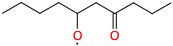

[O]O + CCCC[CH]CC(=O)CCC <=> CCCCC(CC(=O)CCC)OO
[H] + CCCCC(CC(=O)CCC)O[O] <=> CCCCC(CC(=O)CCC)OO
CCCC(=O)C[CH]OO + [CH2]CCC <=> CCCCC(CC(=O)CCC)OO
CCCC[CH]OO + [CH2]C(=O)CCC <=> CCCCC(CC(=O)CCC)OO
CCCC[C](CC(=O)CCC)OO + [H] <=> CCCCC(CC(=O)CCC)OO
[CH2]C(CC(=O)CCC)OO + [CH2]CC <=> CCCCC(CC(=O)CCC)OO
CCC[CH]C(CC(=O)CCC)OO + [H] <=> CCCCC(CC(=O)CCC)OO
[CH2]CC(CC(=O)CCC)OO + C[CH2] <=> CCCCC(CC(=O)CCC)OO
CC[CH]CC(CC(=O)CCC)OO + [H] <=> CCCCC(CC(=O)CCC)OO
[CH2]CCC(CC(=O)CCC)OO + [CH3] <=> CCCCC(CC(=O)CCC)OO
C[CH]CCC(CC(=O)CCC)OO + [H] <=> CCCCC(CC(=O)CCC)OO
[CH2]C(=O)CC(CCCC)OO + C[CH2] <=> CCCCC(CC(=O)CCC)OO
[CH2]CC(=O)CC(CCCC)OO + [CH3] <=> CCCCC(CC(=O)CCC)OO
C[CH]CC(=O)CC(CCCC)OO + [H] <=> CCCCC(CC(=O)CCC)OO
[CH2]C(CCCC)OO + CCC[C]=O <=> CCCCC(CC(=O)CCC)OO
CCCCC([CH]C(=O)CCC)OO + [H] <=> CCCCC(CC(=O)CCC)OO
CCCCC(C[C]=O)OO + [CH2]CC <=> CCCCC(CC(=O)CCC)OO
CC[CH]C(=O)CC(CCCC)OO + [H] <=> CCCCC(CC(=O)CCC)OO
[CH2]CCCC(CC(=O)CCC)OO + [H] <=> CCCCC(CC(=O)CCC)OO
[CH2]CCC(=O)CC(CCCC)OO + [H] <=

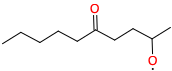

[O]O + C[CH]CCC(=O)CCCCC <=> CCCCCC(=O)CCC(C)OO
[H] + CCCCCC(=O)CCC(C)O[O] <=> CCCCCC(=O)CCC(C)OO
C[CH]OO + [CH2]CC(=O)CCCCC <=> CCCCCC(=O)CCC(C)OO
CCCCCC(=O)CC[CH]OO + [CH3] <=> CCCCCC(=O)CCC(C)OO
CCCCCC(=O)CC[C](C)OO + [H] <=> CCCCCC(=O)CCC(C)OO
[CH2]C(C)OO + [CH2]C(=O)CCCCC <=> CCCCCC(=O)CCC(C)OO
CCCCCC(=O)C[CH]C(C)OO + [H] <=> CCCCCC(=O)CCC(C)OO
[CH2]CC(=O)CCC(C)OO + [CH2]CC <=> CCCCCC(=O)CCC(C)OO
[CH2]CCC(=O)CCC(C)OO + C[CH2] <=> CCCCCC(=O)CCC(C)OO
CC[CH]CCC(=O)CCC(C)OO + [H] <=> CCCCCC(=O)CCC(C)OO
[CH2]C(=O)CCC(C)OO + [CH2]CCC <=> CCCCCC(=O)CCC(C)OO
CCC[CH]CC(=O)CCC(C)OO + [H] <=> CCCCCC(=O)CCC(C)OO
[CH2]CCCC(=O)CCC(C)OO + [CH3] <=> CCCCCC(=O)CCC(C)OO
C[CH]CCCC(=O)CCC(C)OO + [H] <=> CCCCCC(=O)CCC(C)OO
[CH2]CC(C)OO + CCCCC[C]=O <=> CCCCCC(=O)CCC(C)OO
CCCCCC(=O)[CH]CC(C)OO + [H] <=> CCCCCC(=O)CCC(C)OO
CC(CC[C]=O)OO + [CH2]CCCC <=> CCCCCC(=O)CCC(C)OO
CCCC[CH]C(=O)CCC(C)OO + [H] <=> CCCCCC(=O)CCC(C)OO
[CH2]C(CCC(=O)CCCCC)OO + [H] <=> CCCCCC(=O)CCC(C)OO
[CH2]CCCCC(=O)CCC(C)OO + [H] <=

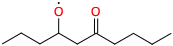

[O]O + CCC[CH]CC(=O)CCCC <=> CCCCC(=O)CC(CCC)OO
[H] + CCCCC(=O)CC(CCC)O[O] <=> CCCCC(=O)CC(CCC)OO
CCCCC(=O)C[CH]OO + [CH2]CC <=> CCCCC(=O)CC(CCC)OO
CCC[CH]OO + [CH2]C(=O)CCCC <=> CCCCC(=O)CC(CCC)OO
CCCCC(=O)C[C](CCC)OO + [H] <=> CCCCC(=O)CC(CCC)OO
[CH2]C(CC(=O)CCCC)OO + C[CH2] <=> CCCCC(=O)CC(CCC)OO
CC[CH]C(CC(=O)CCCC)OO + [H] <=> CCCCC(=O)CC(CCC)OO
[CH2]CC(=O)CC(CCC)OO + C[CH2] <=> CCCCC(=O)CC(CCC)OO
[CH2]C(=O)CC(CCC)OO + [CH2]CC <=> CCCCC(=O)CC(CCC)OO
CC[CH]CC(=O)CC(CCC)OO + [H] <=> CCCCC(=O)CC(CCC)OO
[CH2]CCC(=O)CC(CCC)OO + [CH3] <=> CCCCC(=O)CC(CCC)OO
C[CH]CCC(=O)CC(CCC)OO + [H] <=> CCCCC(=O)CC(CCC)OO
[CH2]CC(CC(=O)CCCC)OO + [CH3] <=> CCCCC(=O)CC(CCC)OO
C[CH]CC(CC(=O)CCCC)OO + [H] <=> CCCCC(=O)CC(CCC)OO
[CH2]C(CCC)OO + CCCC[C]=O <=> CCCCC(=O)CC(CCC)OO
CCCCC(=O)[CH]C(CCC)OO + [H] <=> CCCCC(=O)CC(CCC)OO
CCCC(C[C]=O)OO + [CH2]CCC <=> CCCCC(=O)CC(CCC)OO
CCC[CH]C(=O)CC(CCC)OO + [H] <=> CCCCC(=O)CC(CCC)OO
[CH2]CCC(CC(=O)CCCC)OO + [H] <=> CCCCC(=O)CC(CCC)OO
[CH2]CCCC(=O)CC(CCC)OO + [H] <=

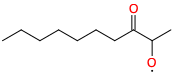

[O]O + C[CH]C(=O)CCCCCCC <=> CCCCCCCC(=O)C(C)OO
[H] + CCCCCCCC(=O)C(C)O[O] <=> CCCCCCCC(=O)C(C)OO
[CH2]CCC(=O)C(C)OO + [CH2]CCC <=> CCCCCCCC(=O)C(C)OO
[CH2]CC(=O)C(C)OO + [CH2]CCCC <=> CCCCCCCC(=O)C(C)OO
CCCC[CH]CCC(=O)C(C)OO + [H] <=> CCCCCCCC(=O)C(C)OO
[CH2]CCCC(=O)C(C)OO + [CH2]CC <=> CCCCCCCC(=O)C(C)OO
CCC[CH]CCCC(=O)C(C)OO + [H] <=> CCCCCCCC(=O)C(C)OO
[CH2]CCCCC(=O)C(C)OO + C[CH2] <=> CCCCCCCC(=O)C(C)OO
CC[CH]CCCCC(=O)C(C)OO + [H] <=> CCCCCCCC(=O)C(C)OO
[CH2]C(=O)C(C)OO + [CH2]CCCCC <=> CCCCCCCC(=O)C(C)OO
CCCCC[CH]CC(=O)C(C)OO + [H] <=> CCCCCCCC(=O)C(C)OO
CCCCCCCC(=O)[CH]OO + [CH3] <=> CCCCCCCC(=O)C(C)OO
C[CH]OO + CCCCCCC[C]=O <=> CCCCCCCC(=O)C(C)OO
CCCCCCCC(=O)[C](C)OO + [H] <=> CCCCCCCC(=O)C(C)OO
[CH2]CCCCCC(=O)C(C)OO + [CH3] <=> CCCCCCCC(=O)C(C)OO
C[CH]CCCCCC(=O)C(C)OO + [H] <=> CCCCCCCC(=O)C(C)OO
CC([C]=O)OO + [CH2]CCCCCC <=> CCCCCCCC(=O)C(C)OO
CCCCCC[CH]C(=O)C(C)OO + [H] <=> CCCCCCCC(=O)C(C)OO
[CH2]C(OO)C(=O)CCCCCCC + [H] <=> CCCCCCCC(=O)C(C)OO
[CH2]CCCCCCC(=O)C(C)OO + [H] <=

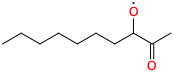

[O]O + CCCCCCC[CH]C(C)=O <=> CCCCCCCC(OO)C(C)=O
[H] + CCCCCCCC(O[O])C(C)=O <=> CCCCCCCC(OO)C(C)=O
CC(=O)[CH]OO + [CH2]CCCCCC <=> CCCCCCCC(OO)C(C)=O
CCCCCCC[CH]OO + C[C]=O <=> CCCCCCCC(OO)C(C)=O
CCCCCCC[C](OO)C(C)=O + [H] <=> CCCCCCCC(OO)C(C)=O
[CH2]C(OO)C(C)=O + [CH2]CCCCC <=> CCCCCCCC(OO)C(C)=O
CCCCCC[CH]C(OO)C(C)=O + [H] <=> CCCCCCCC(OO)C(C)=O
[CH2]CCCC(OO)C(C)=O + [CH2]CC <=> CCCCCCCC(OO)C(C)=O
[CH2]CCCCC(OO)C(C)=O + C[CH2] <=> CCCCCCCC(OO)C(C)=O
CC[CH]CCCCC(OO)C(C)=O + [H] <=> CCCCCCCC(OO)C(C)=O
[CH2]CCC(OO)C(C)=O + [CH2]CCC <=> CCCCCCCC(OO)C(C)=O
CCC[CH]CCCC(OO)C(C)=O + [H] <=> CCCCCCCC(OO)C(C)=O
[CH2]CC(OO)C(C)=O + [CH2]CCCC <=> CCCCCCCC(OO)C(C)=O
CCCC[CH]CCC(OO)C(C)=O + [H] <=> CCCCCCCC(OO)C(C)=O
CCCCC[CH]CC(OO)C(C)=O + [H] <=> CCCCCCCC(OO)C(C)=O
[CH2]CCCCCC(OO)C(C)=O + [CH3] <=> CCCCCCCC(OO)C(C)=O
C[CH]CCCCCC(OO)C(C)=O + [H] <=> CCCCCCCC(OO)C(C)=O
[CH2]CCCCCCC(OO)C(C)=O + [H] <=> CCCCCCCC(OO)C(C)=O
CCCCCCCC([C]=O)OO + [CH3] <=> CCCCCCCC(OO)C(C)=O
[CH2]C(=O)C(CCCCCCC)OO + [H] <=

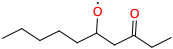

[O]O + CCCCC[CH]CC(=O)CC <=> CCCCCC(CC(=O)CC)OO
[H] + CCCCCC(CC(=O)CC)O[O] <=> CCCCCC(CC(=O)CC)OO
CCC(=O)C[CH]OO + [CH2]CCCC <=> CCCCCC(CC(=O)CC)OO
CCCCC[CH]OO + [CH2]C(=O)CC <=> CCCCCC(CC(=O)CC)OO
CCCCC[C](CC(=O)CC)OO + [H] <=> CCCCCC(CC(=O)CC)OO
[CH2]C(CC(=O)CC)OO + [CH2]CCC <=> CCCCCC(CC(=O)CC)OO
CCCC[CH]C(CC(=O)CC)OO + [H] <=> CCCCCC(CC(=O)CC)OO
[CH2]CC(CC(=O)CC)OO + [CH2]CC <=> CCCCCC(CC(=O)CC)OO
CCC[CH]CC(CC(=O)CC)OO + [H] <=> CCCCCC(CC(=O)CC)OO
[CH2]CCC(CC(=O)CC)OO + C[CH2] <=> CCCCCC(CC(=O)CC)OO
CC[CH]CCC(CC(=O)CC)OO + [H] <=> CCCCCC(CC(=O)CC)OO
[CH2]CCCC(CC(=O)CC)OO + [CH3] <=> CCCCCC(CC(=O)CC)OO
C[CH]CCCC(CC(=O)CC)OO + [H] <=> CCCCCC(CC(=O)CC)OO
[CH2]C(CCCCC)OO + CC[C]=O <=> CCCCCC(CC(=O)CC)OO
CCCCCC([CH]C(=O)CC)OO + [H] <=> CCCCCC(CC(=O)CC)OO
[CH2]C(=O)CC(CCCCC)OO + [CH3] <=> CCCCCC(CC(=O)CC)OO
CCCCCC(C[C]=O)OO + C[CH2] <=> CCCCCC(CC(=O)CC)OO
C[CH]C(=O)CC(CCCCC)OO + [H] <=> CCCCCC(CC(=O)CC)OO
[CH2]CCCCC(CC(=O)CC)OO + [H] <=> CCCCCC(CC(=O)CC)OO
[CH2]CC(=O)CC(CCCCC)OO + [H] <=

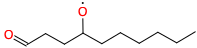

[O]O + CCCCCC[CH]CCC=O <=> CCCCCCC(CCC=O)OO
[H] + CCCCCCC(CCC=O)O[O] <=> CCCCCCC(CCC=O)OO
O=CCC[CH]OO + [CH2]CCCCC <=> CCCCCCC(CCC=O)OO
CCCCCC[CH]OO + [CH2]CC=O <=> CCCCCCC(CCC=O)OO
CCCCCC[C](CCC=O)OO + [H] <=> CCCCCCC(CCC=O)OO
[CH2]C(CCC=O)OO + [CH2]CCCC <=> CCCCCCC(CCC=O)OO
CCCCC[CH]C(CCC=O)OO + [H] <=> CCCCCCC(CCC=O)OO
[CH2]C(CCCCCC)OO + [CH2]C=O <=> CCCCCCC(CCC=O)OO
CCCCCCC([CH]CC=O)OO + [H] <=> CCCCCCC(CCC=O)OO
[CH2]CC(CCC=O)OO + [CH2]CCC <=> CCCCCCC(CCC=O)OO
CCCC[CH]CC(CCC=O)OO + [H] <=> CCCCCCC(CCC=O)OO
[CH2]CCC(CCC=O)OO + [CH2]CC <=> CCCCCCC(CCC=O)OO
CCC[CH]CCC(CCC=O)OO + [H] <=> CCCCCCC(CCC=O)OO
[CH2]CCCC(CCC=O)OO + C[CH2] <=> CCCCCCC(CCC=O)OO
CC[CH]CCCC(CCC=O)OO + [H] <=> CCCCCCC(CCC=O)OO
[CH2]CCCCC(CCC=O)OO + [CH3] <=> CCCCCCC(CCC=O)OO
C[CH]CCCCC(CCC=O)OO + [H] <=> CCCCCCC(CCC=O)OO
[CH2]CC(CCCCCC)OO + [CH]=O <=> CCCCCCC(CCC=O)OO
CCCCCCC(C[CH]C=O)OO + [H] <=> CCCCCCC(CCC=O)OO
[CH2]CCCCCC(CCC=O)OO + [H] <=> CCCCCCC(CCC=O)OO
CCCCCCC(CC[C]=O)OO + [H] <=> CCCCCCC(CCC=O)OO
[OH] + 

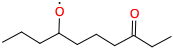

[O]O + CCC[CH]CCCC(=O)CC <=> CCCC(CCCC(=O)CC)OO
[H] + CCCC(CCCC(=O)CC)O[O] <=> CCCC(CCCC(=O)CC)OO
CCC[CH]OO + [CH2]CCC(=O)CC <=> CCCC(CCCC(=O)CC)OO
CCC(=O)CCC[CH]OO + [CH2]CC <=> CCCC(CCCC(=O)CC)OO
CCC[C](CCCC(=O)CC)OO + [H] <=> CCCC(CCCC(=O)CC)OO
[CH2]C(CCC)OO + [CH2]CC(=O)CC <=> CCCC(CCCC(=O)CC)OO
CCCC([CH]CCC(=O)CC)OO + [H] <=> CCCC(CCCC(=O)CC)OO
[CH2]C(CCCC(=O)CC)OO + C[CH2] <=> CCCC(CCCC(=O)CC)OO
CC[CH]C(CCCC(=O)CC)OO + [H] <=> CCCC(CCCC(=O)CC)OO
[CH2]CC(CCC)OO + [CH2]C(=O)CC <=> CCCC(CCCC(=O)CC)OO
CCCC(C[CH]CC(=O)CC)OO + [H] <=> CCCC(CCCC(=O)CC)OO
[CH2]CC(CCCC(=O)CC)OO + [CH3] <=> CCCC(CCCC(=O)CC)OO
C[CH]CC(CCCC(=O)CC)OO + [H] <=> CCCC(CCCC(=O)CC)OO
[CH2]CCC(CCC)OO + CC[C]=O <=> CCCC(CCCC(=O)CC)OO
CCCC(CC[CH]C(=O)CC)OO + [H] <=> CCCC(CCCC(=O)CC)OO
[CH2]C(=O)CCCC(CCC)OO + [CH3] <=> CCCC(CCCC(=O)CC)OO
CCCC(CCC[C]=O)OO + C[CH2] <=> CCCC(CCCC(=O)CC)OO
C[CH]C(=O)CCCC(CCC)OO + [H] <=> CCCC(CCCC(=O)CC)OO
[CH2]CCC(CCCC(=O)CC)OO + [H] <=> CCCC(CCCC(=O)CC)OO
[CH2]CC(=O)CCCC(CCC)OO + [H] <=

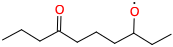

[O]O + CC[CH]CCCC(=O)CCC <=> CCCC(=O)CCCC(CC)OO
[H] + CCCC(=O)CCCC(CC)O[O] <=> CCCC(=O)CCCC(CC)OO
CC[CH]OO + [CH2]CCC(=O)CCC <=> CCCC(=O)CCCC(CC)OO
CCCC(=O)CCC[CH]OO + C[CH2] <=> CCCC(=O)CCCC(CC)OO
CCCC(=O)CCC[C](CC)OO + [H] <=> CCCC(=O)CCCC(CC)OO
[CH2]C(CC)OO + [CH2]CC(=O)CCC <=> CCCC(=O)CCCC(CC)OO
CCCC(=O)CC[CH]C(CC)OO + [H] <=> CCCC(=O)CCCC(CC)OO
[CH2]CC(CC)OO + [CH2]C(=O)CCC <=> CCCC(=O)CCCC(CC)OO
CCCC(=O)C[CH]CC(CC)OO + [H] <=> CCCC(=O)CCCC(CC)OO
[CH2]C(CCCC(=O)CCC)OO + [CH3] <=> CCCC(=O)CCCC(CC)OO
C[CH]C(CCCC(=O)CCC)OO + [H] <=> CCCC(=O)CCCC(CC)OO
[CH2]C(=O)CCCC(CC)OO + C[CH2] <=> CCCC(=O)CCCC(CC)OO
[CH2]CC(=O)CCCC(CC)OO + [CH3] <=> CCCC(=O)CCCC(CC)OO
C[CH]CC(=O)CCCC(CC)OO + [H] <=> CCCC(=O)CCCC(CC)OO
[CH2]CCC(CC)OO + CCC[C]=O <=> CCCC(=O)CCCC(CC)OO
CCCC(=O)[CH]CCC(CC)OO + [H] <=> CCCC(=O)CCCC(CC)OO
CCC(CCC[C]=O)OO + [CH2]CC <=> CCCC(=O)CCCC(CC)OO
CC[CH]C(=O)CCCC(CC)OO + [H] <=> CCCC(=O)CCCC(CC)OO
[CH2]CCC(=O)CCCC(CC)OO + [H] <=> CCCC(=O)CCCC(CC)OO
[CH2]CC(CCCC(=O)CCC)OO + [H] <=

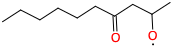

[O]O + C[CH]CC(=O)CCCCCC <=> CCCCCCC(=O)CC(C)OO
[H] + CCCCCCC(=O)CC(C)O[O] <=> CCCCCCC(=O)CC(C)OO
C[CH]OO + [CH2]C(=O)CCCCCC <=> CCCCCCC(=O)CC(C)OO
CCCCCCC(=O)C[CH]OO + [CH3] <=> CCCCCCC(=O)CC(C)OO
CCCCCCC(=O)C[C](C)OO + [H] <=> CCCCCCC(=O)CC(C)OO
[CH2]CCC(=O)CC(C)OO + [CH2]CC <=> CCCCCCC(=O)CC(C)OO
[CH2]CCCC(=O)CC(C)OO + C[CH2] <=> CCCCCCC(=O)CC(C)OO
CC[CH]CCCC(=O)CC(C)OO + [H] <=> CCCCCCC(=O)CC(C)OO
[CH2]CC(=O)CC(C)OO + [CH2]CCC <=> CCCCCCC(=O)CC(C)OO
CCC[CH]CCC(=O)CC(C)OO + [H] <=> CCCCCCC(=O)CC(C)OO
[CH2]C(=O)CC(C)OO + [CH2]CCCC <=> CCCCCCC(=O)CC(C)OO
CCCC[CH]CC(=O)CC(C)OO + [H] <=> CCCCCCC(=O)CC(C)OO
[CH2]CCCCC(=O)CC(C)OO + [CH3] <=> CCCCCCC(=O)CC(C)OO
C[CH]CCCCC(=O)CC(C)OO + [H] <=> CCCCCCC(=O)CC(C)OO
[CH2]C(C)OO + CCCCCC[C]=O <=> CCCCCCC(=O)CC(C)OO
CCCCCCC(=O)[CH]C(C)OO + [H] <=> CCCCCCC(=O)CC(C)OO
CC(C[C]=O)OO + [CH2]CCCCC <=> CCCCCCC(=O)CC(C)OO
CCCCC[CH]C(=O)CC(C)OO + [H] <=> CCCCCCC(=O)CC(C)OO
[CH2]C(CC(=O)CCCCCC)OO + [H] <=> CCCCCCC(=O)CC(C)OO
[CH2]CCCCCC(=O)CC(C)OO + [H] <=

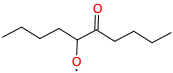

[O]O + CCCC[CH]C(=O)CCCC <=> CCCCC(=O)C(CCCC)OO
[H] + CCCCC(=O)C(CCCC)O[O] <=> CCCCC(=O)C(CCCC)OO
CCCCC(=O)[CH]OO + [CH2]CCC <=> CCCCC(=O)C(CCCC)OO
CCCC[CH]OO + CCCC[C]=O <=> CCCCC(=O)C(CCCC)OO
CCCC[C](OO)C(=O)CCCC + [H] <=> CCCCC(=O)C(CCCC)OO
[CH2]C(OO)C(=O)CCCC + [CH2]CC <=> CCCCC(=O)C(CCCC)OO
CCC[CH]C(OO)C(=O)CCCC + [H] <=> CCCCC(=O)C(CCCC)OO
[CH2]CC(OO)C(=O)CCCC + C[CH2] <=> CCCCC(=O)C(CCCC)OO
CC[CH]CC(OO)C(=O)CCCC + [H] <=> CCCCC(=O)C(CCCC)OO
[CH2]CC(=O)C(CCCC)OO + C[CH2] <=> CCCCC(=O)C(CCCC)OO
[CH2]C(=O)C(CCCC)OO + [CH2]CC <=> CCCCC(=O)C(CCCC)OO
CC[CH]CC(=O)C(CCCC)OO + [H] <=> CCCCC(=O)C(CCCC)OO
[CH2]CCC(OO)C(=O)CCCC + [CH3] <=> CCCCC(=O)C(CCCC)OO
C[CH]CCC(OO)C(=O)CCCC + [H] <=> CCCCC(=O)C(CCCC)OO
[CH2]CCC(=O)C(CCCC)OO + [CH3] <=> CCCCC(=O)C(CCCC)OO
C[CH]CCC(=O)C(CCCC)OO + [H] <=> CCCCC(=O)C(CCCC)OO
CCCCC([C]=O)OO + [CH2]CCC <=> CCCCC(=O)C(CCCC)OO
CCC[CH]C(=O)C(CCCC)OO + [H] <=> CCCCC(=O)C(CCCC)OO
[CH2]CCCC(OO)C(=O)CCCC + [H] <=> CCCCC(=O)C(CCCC)OO
[CH2]CCCC(=O)C(CCCC)OO + [H] <=

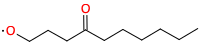

[O]O + [CH2]CCC(=O)CCCCCC <=> CCCCCCC(=O)CCCOO
[H] + CCCCCCC(=O)CCCO[O] <=> CCCCCCC(=O)CCCOO
[CH2]CCC(=O)CCCOO + [CH2]CC <=> CCCCCCC(=O)CCCOO
[CH2]CCCC(=O)CCCOO + C[CH2] <=> CCCCCCC(=O)CCCOO
CC[CH]CCCC(=O)CCCOO + [H] <=> CCCCCCC(=O)CCCOO
[CH2]CC(=O)CCCOO + [CH2]CCC <=> CCCCCCC(=O)CCCOO
CCC[CH]CCC(=O)CCCOO + [H] <=> CCCCCCC(=O)CCCOO
[CH2]C(=O)CCCOO + [CH2]CCCC <=> CCCCCCC(=O)CCCOO
CCCC[CH]CC(=O)CCCOO + [H] <=> CCCCCCC(=O)CCCOO
[CH2]COO + [CH2]C(=O)CCCCCC <=> CCCCCCC(=O)CCCOO
[CH2]OO + [CH2]CC(=O)CCCCCC <=> CCCCCCC(=O)CCCOO
CCCCCCC(=O)C[CH]COO + [H] <=> CCCCCCC(=O)CCCOO
[CH2]CCCCC(=O)CCCOO + [CH3] <=> CCCCCCC(=O)CCCOO
C[CH]CCCCC(=O)CCCOO + [H] <=> CCCCCCC(=O)CCCOO
O=[C]CCCOO + [CH2]CCCCC <=> CCCCCCC(=O)CCCOO
CCCCC[CH]C(=O)CCCOO + [H] <=> CCCCCCC(=O)CCCOO
[CH2]CCOO + CCCCCC[C]=O <=> CCCCCCC(=O)CCCOO
CCCCCCC(=O)[CH]CCOO + [H] <=> CCCCCCC(=O)CCCOO
CCCCCCC(=O)CC[CH]OO + [H] <=> CCCCCCC(=O)CCCOO
[CH2]CCCCCC(=O)CCCOO + [H] <=> CCCCCCC(=O)CCCOO
[OH] + CCCC(=O)CCC([O])CCC <=> CCCC(=O)CCC(CCC)OO


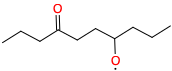

[O]O + CCC[CH]CCC(=O)CCC <=> CCCC(=O)CCC(CCC)OO
[H] + CCCC(=O)CCC(CCC)O[O] <=> CCCC(=O)CCC(CCC)OO
CCCC(=O)CC[CH]OO + [CH2]CC <=> CCCC(=O)CCC(CCC)OO
CCC[CH]OO + [CH2]CC(=O)CCC <=> CCCC(=O)CCC(CCC)OO
CCC[C](CCC(=O)CCC)OO + [H] <=> CCCC(=O)CCC(CCC)OO
[CH2]C(CCC(=O)CCC)OO + C[CH2] <=> CCCC(=O)CCC(CCC)OO
CC[CH]C(CCC(=O)CCC)OO + [H] <=> CCCC(=O)CCC(CCC)OO
[CH2]C(CCC)OO + [CH2]C(=O)CCC <=> CCCC(=O)CCC(CCC)OO
CCCC(=O)C[CH]C(CCC)OO + [H] <=> CCCC(=O)CCC(CCC)OO
[CH2]CC(CCC(=O)CCC)OO + [CH3] <=> CCCC(=O)CCC(CCC)OO
C[CH]CC(CCC(=O)CCC)OO + [H] <=> CCCC(=O)CCC(CCC)OO
[CH2]C(=O)CCC(CCC)OO + C[CH2] <=> CCCC(=O)CCC(CCC)OO
[CH2]CC(=O)CCC(CCC)OO + [CH3] <=> CCCC(=O)CCC(CCC)OO
C[CH]CC(=O)CCC(CCC)OO + [H] <=> CCCC(=O)CCC(CCC)OO
[CH2]CC(CCC)OO + CCC[C]=O <=> CCCC(=O)CCC(CCC)OO
CCCC(=O)[CH]CC(CCC)OO + [H] <=> CCCC(=O)CCC(CCC)OO
CCCC(CC[C]=O)OO + [CH2]CC <=> CCCC(=O)CCC(CCC)OO
CC[CH]C(=O)CCC(CCC)OO + [H] <=> CCCC(=O)CCC(CCC)OO
[CH2]CCC(CCC(=O)CCC)OO + [H] <=> CCCC(=O)CCC(CCC)OO
[CH2]CCC(=O)CCC(CCC)OO + [H] <=

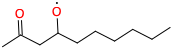

[O]O + CCCCCC[CH]CC(C)=O <=> CCCCCCC(CC(C)=O)OO
[H] + CCCCCCC(CC(C)=O)O[O] <=> CCCCCCC(CC(C)=O)OO
CC(=O)C[CH]OO + [CH2]CCCCC <=> CCCCCCC(CC(C)=O)OO
CCCCCC[CH]OO + [CH2]C(C)=O <=> CCCCCCC(CC(C)=O)OO
CCCCCC[C](CC(C)=O)OO + [H] <=> CCCCCCC(CC(C)=O)OO
[CH2]C(CC(C)=O)OO + [CH2]CCCC <=> CCCCCCC(CC(C)=O)OO
CCCCC[CH]C(CC(C)=O)OO + [H] <=> CCCCCCC(CC(C)=O)OO
[CH2]CC(CC(C)=O)OO + [CH2]CCC <=> CCCCCCC(CC(C)=O)OO
CCCC[CH]CC(CC(C)=O)OO + [H] <=> CCCCCCC(CC(C)=O)OO
[CH2]CCC(CC(C)=O)OO + [CH2]CC <=> CCCCCCC(CC(C)=O)OO
CCC[CH]CCC(CC(C)=O)OO + [H] <=> CCCCCCC(CC(C)=O)OO
[CH2]CCCC(CC(C)=O)OO + C[CH2] <=> CCCCCCC(CC(C)=O)OO
CC[CH]CCCC(CC(C)=O)OO + [H] <=> CCCCCCC(CC(C)=O)OO
[CH2]CCCCC(CC(C)=O)OO + [CH3] <=> CCCCCCC(CC(C)=O)OO
C[CH]CCCCC(CC(C)=O)OO + [H] <=> CCCCCCC(CC(C)=O)OO
[CH2]C(CCCCCC)OO + C[C]=O <=> CCCCCCC(CC(C)=O)OO
CCCCCCC([CH]C(C)=O)OO + [H] <=> CCCCCCC(CC(C)=O)OO
[CH2]CCCCCC(CC(C)=O)OO + [H] <=> CCCCCCC(CC(C)=O)OO
CCCCCCC(C[C]=O)OO + [CH3] <=> CCCCCCC(CC(C)=O)OO
[CH2]C(=O)CC(CCCCCC)OO + [H] <=

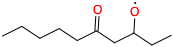

[O]O + CC[CH]CC(=O)CCCCC <=> CCCCCC(=O)CC(CC)OO
[H] + CCCCCC(=O)CC(CC)O[O] <=> CCCCCC(=O)CC(CC)OO
CCCCCC(=O)C[CH]OO + C[CH2] <=> CCCCCC(=O)CC(CC)OO
CC[CH]OO + [CH2]C(=O)CCCCC <=> CCCCCC(=O)CC(CC)OO
CCCCCC(=O)C[C](CC)OO + [H] <=> CCCCCC(=O)CC(CC)OO
[CH2]CC(=O)CC(CC)OO + [CH2]CC <=> CCCCCC(=O)CC(CC)OO
[CH2]CCC(=O)CC(CC)OO + C[CH2] <=> CCCCCC(=O)CC(CC)OO
CC[CH]CCC(=O)CC(CC)OO + [H] <=> CCCCCC(=O)CC(CC)OO
[CH2]C(=O)CC(CC)OO + [CH2]CCC <=> CCCCCC(=O)CC(CC)OO
CCC[CH]CC(=O)CC(CC)OO + [H] <=> CCCCCC(=O)CC(CC)OO
[CH2]C(CC(=O)CCCCC)OO + [CH3] <=> CCCCCC(=O)CC(CC)OO
C[CH]C(CC(=O)CCCCC)OO + [H] <=> CCCCCC(=O)CC(CC)OO
[CH2]CCCC(=O)CC(CC)OO + [CH3] <=> CCCCCC(=O)CC(CC)OO
C[CH]CCCC(=O)CC(CC)OO + [H] <=> CCCCCC(=O)CC(CC)OO
[CH2]C(CC)OO + CCCCC[C]=O <=> CCCCCC(=O)CC(CC)OO
CCCCCC(=O)[CH]C(CC)OO + [H] <=> CCCCCC(=O)CC(CC)OO
CCC(C[C]=O)OO + [CH2]CCCC <=> CCCCCC(=O)CC(CC)OO
CCCC[CH]C(=O)CC(CC)OO + [H] <=> CCCCCC(=O)CC(CC)OO
[CH2]CCCCC(=O)CC(CC)OO + [H] <=> CCCCCC(=O)CC(CC)OO
[CH2]CC(CC(=O)CCCCC)OO + [H] <=

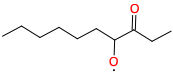

[O]O + CCCCCC[CH]C(=O)CC <=> CCCCCCC(OO)C(=O)CC
[H] + CCCCCCC(O[O])C(=O)CC <=> CCCCCCC(OO)C(=O)CC
CCC(=O)[CH]OO + [CH2]CCCCC <=> CCCCCCC(OO)C(=O)CC
CCCCCC[CH]OO + CC[C]=O <=> CCCCCCC(OO)C(=O)CC
CCCCCC[C](OO)C(=O)CC + [H] <=> CCCCCCC(OO)C(=O)CC
[CH2]C(OO)C(=O)CC + [CH2]CCCC <=> CCCCCCC(OO)C(=O)CC
CCCCC[CH]C(OO)C(=O)CC + [H] <=> CCCCCCC(OO)C(=O)CC
[CH2]CC(OO)C(=O)CC + [CH2]CCC <=> CCCCCCC(OO)C(=O)CC
CCCC[CH]CC(OO)C(=O)CC + [H] <=> CCCCCCC(OO)C(=O)CC
[CH2]CCC(OO)C(=O)CC + [CH2]CC <=> CCCCCCC(OO)C(=O)CC
CCC[CH]CCC(OO)C(=O)CC + [H] <=> CCCCCCC(OO)C(=O)CC
[CH2]CCCC(OO)C(=O)CC + C[CH2] <=> CCCCCCC(OO)C(=O)CC
CC[CH]CCCC(OO)C(=O)CC + [H] <=> CCCCCCC(OO)C(=O)CC
[CH2]CCCCC(OO)C(=O)CC + [CH3] <=> CCCCCCC(OO)C(=O)CC
C[CH]CCCCC(OO)C(=O)CC + [H] <=> CCCCCCC(OO)C(=O)CC
[CH2]C(=O)C(CCCCCC)OO + [CH3] <=> CCCCCCC(OO)C(=O)CC
CCCCCCC([C]=O)OO + C[CH2] <=> CCCCCCC(OO)C(=O)CC
C[CH]C(=O)C(CCCCCC)OO + [H] <=> CCCCCCC(OO)C(=O)CC
[CH2]CCCCCC(OO)C(=O)CC + [H] <=> CCCCCCC(OO)C(=O)CC
[CH2]CC(=O)C(CCCCCC)OO + [H] <=

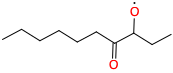

[O]O + CC[CH]C(=O)CCCCCC <=> CCCCCCC(=O)C(CC)OO
[H] + CCCCCCC(=O)C(CC)O[O] <=> CCCCCCC(=O)C(CC)OO
CCCCCCC(=O)[CH]OO + C[CH2] <=> CCCCCCC(=O)C(CC)OO
CC[CH]OO + CCCCCC[C]=O <=> CCCCCCC(=O)C(CC)OO
CCCCCCC(=O)[C](CC)OO + [H] <=> CCCCCCC(=O)C(CC)OO
[CH2]CCC(=O)C(CC)OO + [CH2]CC <=> CCCCCCC(=O)C(CC)OO
[CH2]CCCC(=O)C(CC)OO + C[CH2] <=> CCCCCCC(=O)C(CC)OO
CC[CH]CCCC(=O)C(CC)OO + [H] <=> CCCCCCC(=O)C(CC)OO
[CH2]CC(=O)C(CC)OO + [CH2]CCC <=> CCCCCCC(=O)C(CC)OO
CCC[CH]CCC(=O)C(CC)OO + [H] <=> CCCCCCC(=O)C(CC)OO
[CH2]C(=O)C(CC)OO + [CH2]CCCC <=> CCCCCCC(=O)C(CC)OO
CCCC[CH]CC(=O)C(CC)OO + [H] <=> CCCCCCC(=O)C(CC)OO
[CH2]C(OO)C(=O)CCCCCC + [CH3] <=> CCCCCCC(=O)C(CC)OO
C[CH]C(OO)C(=O)CCCCCC + [H] <=> CCCCCCC(=O)C(CC)OO
[CH2]CCCCC(=O)C(CC)OO + [CH3] <=> CCCCCCC(=O)C(CC)OO
C[CH]CCCCC(=O)C(CC)OO + [H] <=> CCCCCCC(=O)C(CC)OO
CCC([C]=O)OO + [CH2]CCCCC <=> CCCCCCC(=O)C(CC)OO
CCCCC[CH]C(=O)C(CC)OO + [H] <=> CCCCCCC(=O)C(CC)OO
[CH2]CCCCCC(=O)C(CC)OO + [H] <=> CCCCCCC(=O)C(CC)OO
[CH2]CC(OO)C(=O)CCCCCC + [H] <=

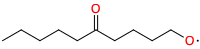

[O]O + [CH2]CCCC(=O)CCCCC <=> CCCCCC(=O)CCCCOO
[H] + CCCCCC(=O)CCCCO[O] <=> CCCCCC(=O)CCCCOO
[CH2]CC(=O)CCCCOO + [CH2]CC <=> CCCCCC(=O)CCCCOO
[CH2]CCC(=O)CCCCOO + C[CH2] <=> CCCCCC(=O)CCCCOO
CC[CH]CCC(=O)CCCCOO + [H] <=> CCCCCC(=O)CCCCOO
[CH2]COO + [CH2]CC(=O)CCCCC <=> CCCCCC(=O)CCCCOO
[CH2]CCOO + [CH2]C(=O)CCCCC <=> CCCCCC(=O)CCCCOO
CCCCCC(=O)C[CH]CCOO + [H] <=> CCCCCC(=O)CCCCOO
[CH2]C(=O)CCCCOO + [CH2]CCC <=> CCCCCC(=O)CCCCOO
CCC[CH]CC(=O)CCCCOO + [H] <=> CCCCCC(=O)CCCCOO
[CH2]OO + [CH2]CCC(=O)CCCCC <=> CCCCCC(=O)CCCCOO
CCCCCC(=O)CC[CH]COO + [H] <=> CCCCCC(=O)CCCCOO
[CH2]CCCC(=O)CCCCOO + [CH3] <=> CCCCCC(=O)CCCCOO
C[CH]CCCC(=O)CCCCOO + [H] <=> CCCCCC(=O)CCCCOO
[CH2]CCCOO + CCCCC[C]=O <=> CCCCCC(=O)CCCCOO
CCCCCC(=O)[CH]CCCOO + [H] <=> CCCCCC(=O)CCCCOO
O=[C]CCCCOO + [CH2]CCCC <=> CCCCCC(=O)CCCCOO
CCCC[CH]C(=O)CCCCOO + [H] <=> CCCCCC(=O)CCCCOO
CCCCCC(=O)CCC[CH]OO + [H] <=> CCCCCC(=O)CCCCOO
[CH2]CCCCC(=O)CCCCOO + [H] <=> CCCCCC(=O)CCCCOO
[OH] + CCCCCC([O])CCCC=O <=> CCCCCC(CCCC=O)OO


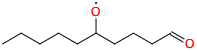

[O]O + CCCCC[CH]CCCC=O <=> CCCCCC(CCCC=O)OO
[H] + CCCCCC(CCCC=O)O[O] <=> CCCCCC(CCCC=O)OO
O=CCCC[CH]OO + [CH2]CCCC <=> CCCCCC(CCCC=O)OO
CCCCC[CH]OO + [CH2]CCC=O <=> CCCCCC(CCCC=O)OO
CCCCC[C](CCCC=O)OO + [H] <=> CCCCCC(CCCC=O)OO
[CH2]C(CCCC=O)OO + [CH2]CCC <=> CCCCCC(CCCC=O)OO
CCCC[CH]C(CCCC=O)OO + [H] <=> CCCCCC(CCCC=O)OO
[CH2]C(CCCCC)OO + [CH2]CC=O <=> CCCCCC(CCCC=O)OO
CCCCCC([CH]CCC=O)OO + [H] <=> CCCCCC(CCCC=O)OO
[CH2]CC(CCCC=O)OO + [CH2]CC <=> CCCCCC(CCCC=O)OO
[CH2]CCC(CCCC=O)OO + C[CH2] <=> CCCCCC(CCCC=O)OO
CC[CH]CCC(CCCC=O)OO + [H] <=> CCCCCC(CCCC=O)OO
CCC[CH]CC(CCCC=O)OO + [H] <=> CCCCCC(CCCC=O)OO
[CH2]CC(CCCCC)OO + [CH2]C=O <=> CCCCCC(CCCC=O)OO
CCCCCC(C[CH]CC=O)OO + [H] <=> CCCCCC(CCCC=O)OO
[CH2]CCCC(CCCC=O)OO + [CH3] <=> CCCCCC(CCCC=O)OO
C[CH]CCCC(CCCC=O)OO + [H] <=> CCCCCC(CCCC=O)OO
[CH2]CCC(CCCCC)OO + [CH]=O <=> CCCCCC(CCCC=O)OO
CCCCCC(CC[CH]C=O)OO + [H] <=> CCCCCC(CCCC=O)OO
[CH2]CCCCC(CCCC=O)OO + [H] <=> CCCCCC(CCCC=O)OO
CCCCCC(CCC[C]=O)OO + [H] <=> CCCCCC(CCCC=O)OO
[OH] + 

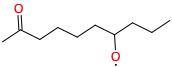

[O]O + CCC[CH]CCCCC(C)=O <=> CCCC(CCCCC(C)=O)OO
[H] + CCCC(CCCCC(C)=O)O[O] <=> CCCC(CCCCC(C)=O)OO
CCC[CH]OO + [CH2]CCCC(C)=O <=> CCCC(CCCCC(C)=O)OO
CC(=O)CCCC[CH]OO + [CH2]CC <=> CCCC(CCCCC(C)=O)OO
CCC[C](CCCCC(C)=O)OO + [H] <=> CCCC(CCCCC(C)=O)OO
[CH2]C(CCC)OO + [CH2]CCC(C)=O <=> CCCC(CCCCC(C)=O)OO
CCCC([CH]CCCC(C)=O)OO + [H] <=> CCCC(CCCCC(C)=O)OO
[CH2]C(CCCCC(C)=O)OO + C[CH2] <=> CCCC(CCCCC(C)=O)OO
CC[CH]C(CCCCC(C)=O)OO + [H] <=> CCCC(CCCCC(C)=O)OO
[CH2]CC(CCC)OO + [CH2]CC(C)=O <=> CCCC(CCCCC(C)=O)OO
CCCC(C[CH]CCC(C)=O)OO + [H] <=> CCCC(CCCCC(C)=O)OO
[CH2]CCC(CCC)OO + [CH2]C(C)=O <=> CCCC(CCCCC(C)=O)OO
CCCC(CC[CH]CC(C)=O)OO + [H] <=> CCCC(CCCCC(C)=O)OO
[CH2]CC(CCCCC(C)=O)OO + [CH3] <=> CCCC(CCCCC(C)=O)OO
C[CH]CC(CCCCC(C)=O)OO + [H] <=> CCCC(CCCCC(C)=O)OO
[CH2]CCCC(CCC)OO + C[C]=O <=> CCCC(CCCCC(C)=O)OO
CCCC(CCC[CH]C(C)=O)OO + [H] <=> CCCC(CCCCC(C)=O)OO
[CH2]CCC(CCCCC(C)=O)OO + [H] <=> CCCC(CCCCC(C)=O)OO
CCCC(CCCC[C]=O)OO + [CH3] <=> CCCC(CCCCC(C)=O)OO
[CH2]C(=O)CCCCC(CCC)OO + [H] <=

{Molecule(smiles="CCCC(=O)CCCCC(C)[O]"),
 Molecule(smiles="CCCCC([O])CCC(=O)CC"),
 Molecule(smiles="CCCCC(=O)CCC([O])CC"),
 Molecule(smiles="CCCCCC([O])C(=O)CCC"),
 Molecule(smiles="CCCCCC(=O)C([O])CCC"),
 Molecule(smiles="CCCCC([O])CC(=O)CCC"),
 Molecule(smiles="CCCCCC(=O)CCC(C)[O]"),
 Molecule(smiles="CCCCC(=O)CC([O])CCC"),
 Molecule(smiles="CCCCC(=O)CCCCC[O]"),
 Molecule(smiles="CCCCCCCCCC([O])=O"),
 Molecule(smiles="CCCCCCC(=O)C([O])CC"),
 Molecule(smiles="CCCCCC(=O)CCCC[O]"),
 Molecule(smiles="CCCCCC([O])CCCC=O"),
 Molecule(smiles="CCCC([O])CCCCC(C)=O"),
 Molecule(smiles="CCCCCCC([O])CCC=O"),
 Molecule(smiles="CCCC([O])CCCC(=O)CC"),
 Molecule(smiles="CCCC(=O)CCCC([O])CC"),
 Molecule(smiles="CCCCCCC(=O)CC(C)[O]"),
 Molecule(smiles="CCCCC(=O)C([O])CCCC"),
 Molecule(smiles="CCCCCCC(=O)CCC[O]"),
 Molecule(smiles="CCCC(=O)CCC([O])CCC"),
 Molecule(smiles="CCCCCCC([O])CC(C)=O"),
 Molecule(smiles="CCCCCC(=O)CC([O])CC"),
 Molecule(smiles="CCCCCCC([O])C(=O)CC"),
 Molecule(smiles="CCCCCC([O]

In [22]:
# The ketohydroperoxide can now break its O-OH and form an alkoxy radical
for s in molecules['ketohydroperoxide']:
    reactions = rmg.database.kinetics.generate_reactions_from_families((s,), only_families='R_Recombination')
    for r in reactions:
        print(r)
        m1 = r.reactants[0].molecule[0]
        m2 = r.reactants[1].molecule[0]
        if m1.get_formula() == 'HO':
            display(m2)
            molecules['alkoxy_radical'].add(m2)
            molecules['OH'].add(m1)
        if m2.get_formula() == 'HO':
            display(m1)
            molecules['alkoxy_radical'].add(m1)
            molecules['OH'].add(m2)
molecules['alkoxy_radical']

Applying HO2_Elimination_from_PeroxyRadical
CCCCCCC(CC(C)O[O])OO <=> CC=CC(CCCCCC)OO + [O]O


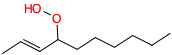

CCCCCCC(CC(C)O[O])OO <=> C=CCC(CCCCCC)OO + [O]O


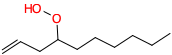

CCCC(CCC(CCC)OO)O[O] <=> CCC=CCCC(CCC)OO + [O]O


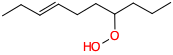

CCCC(CCC(CCC)OO)O[O] <=> CCCC=CCC(CCC)OO + [O]O


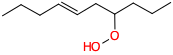

CCCCCCC(CCCO[O])OO <=> C=CCC(CCCCCC)OO + [O]O


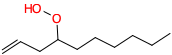

CCCC(CCCC(CC)O[O])OO <=> CCC=CCCC(CCC)OO + [O]O


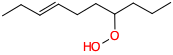

CCCC(CCCC(CC)O[O])OO <=> CC=CCCCC(CCC)OO + [O]O


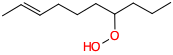

CCCC(CCCCC(C)O[O])OO <=> CC=CCCCC(CCC)OO + [O]O


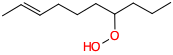

CCCC(CCCCC(C)O[O])OO <=> C=CCCCCC(CCC)OO + [O]O


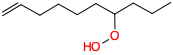

CCCCC(CCC(CC)O[O])OO <=> CCC=CCC(CCCC)OO + [O]O


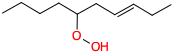

CCCCC(CCC(CC)O[O])OO <=> CC=CCCC(CCCC)OO + [O]O


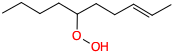

CCCCCC(CCCC)(O[O])OO <=> CCCCC=C(CCCC)OO + [O]O


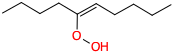

CCCCCC(CCCC)(O[O])OO <=> CCCC=C(CCCCC)OO + [O]O


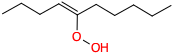

CCCCC(O[O])C(CCCC)OO <=> CCCCC=C(CCCC)OO + [O]O


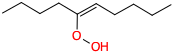

CCCCC(O[O])C(CCCC)OO <=> CCCC=CC(CCCC)OO + [O]O


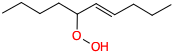

CCCCCC(OO)C(CCC)O[O] <=> CCCC=C(CCCCC)OO + [O]O


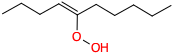

CCCCCC(OO)C(CCC)O[O] <=> CCC=CC(CCCCC)OO + [O]O


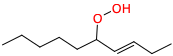

CCCCC(CC(CCC)O[O])OO <=> CCCC=CC(CCCC)OO + [O]O


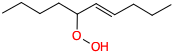

CCCCC(CC(CCC)O[O])OO <=> CCC=CCC(CCCC)OO + [O]O


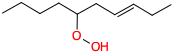

CCCCCCCC(O[O])C(C)OO <=> CCCCCCCC=C(C)OO + [O]O


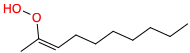

CCCCCCCC(O[O])C(C)OO <=> CCCCCCC=CC(C)OO + [O]O


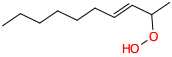

CCCCCC(CC(CC)O[O])OO <=> CCC=CC(CCCCC)OO + [O]O


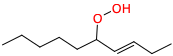

CCCCCC(CC(CC)O[O])OO <=> CC=CCC(CCCCC)OO + [O]O


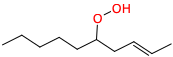

CCCCCCC(CCC)(O[O])OO <=> CCCCCC=C(CCC)OO + [O]O


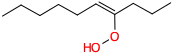

CCCCCCC(CCC)(O[O])OO <=> CCC=C(CCCCCC)OO + [O]O


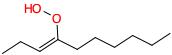

CCCCCC(O[O])C(CCC)OO <=> CCCCCC=C(CCC)OO + [O]O


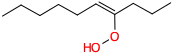

CCCCCC(O[O])C(CCC)OO <=> CCCCC=CC(CCC)OO + [O]O


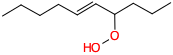

CCCCCCC(OO)C(CC)O[O] <=> CCC=C(CCCCCC)OO + [O]O


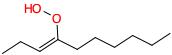

CCCCCCC(OO)C(CC)O[O] <=> CC=CC(CCCCCC)OO + [O]O


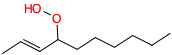

CCCCC(CC(CCC)OO)O[O] <=> CCCCC=CC(CCC)OO + [O]O


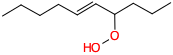

CCCCC(CC(CCC)OO)O[O] <=> CCCC=CCC(CCC)OO + [O]O


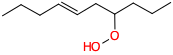

CCCCCC(CCCCOO)O[O] <=> CCCCC=CCCCCOO + [O]O


CCCCCC(CCCCOO)O[O] <=> CCCCCC=CCCCOO + [O]O


CCCCC(CCCCCOO)O[O] <=> CCCC=CCCCCCOO + [O]O


CCCCC(CCCCCOO)O[O] <=> CCCCC=CCCCCOO + [O]O


CCCCCCC(CC(C)OO)O[O] <=> CCCCCCC=CC(C)OO + [O]O


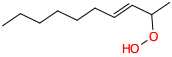

CCCCCCC(CC(C)OO)O[O] <=> CCCCCC=CCC(C)OO + [O]O


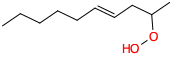

CCCCCCCCC(C)(O[O])OO <=> CCCCCCCC=C(C)OO + [O]O


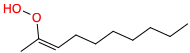

CCCCCCCCC(C)(O[O])OO <=> C=C(CCCCCCCC)OO + [O]O


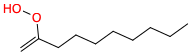

CCCCCCCCC(CO[O])OO <=> C=C(CCCCCCCC)OO + [O]O


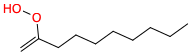

CCCCC(CCCC(C)OO)O[O] <=> CCCC=CCCCC(C)OO + [O]O


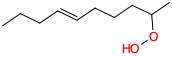

CCCCC(CCCC(C)OO)O[O] <=> CCCCC=CCCC(C)OO + [O]O


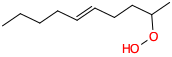

CCCC(CCCCC(C)OO)O[O] <=> CCC=CCCCCC(C)OO + [O]O


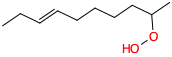

CCCC(CCCCC(C)OO)O[O] <=> CCCC=CCCCC(C)OO + [O]O


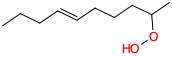

CCCCCCCC(CC)(O[O])OO <=> CCCCCCC=C(CC)OO + [O]O


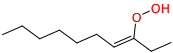

CCCCCCCC(CC)(O[O])OO <=> CC=C(CCCCCCC)OO + [O]O


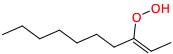

CCCCCCC(O[O])C(CC)OO <=> CCCCCCC=C(CC)OO + [O]O


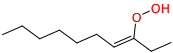

CCCCCCC(O[O])C(CC)OO <=> CCCCCC=CC(CC)OO + [O]O


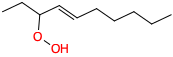

CCCCCCCC(OO)C(C)O[O] <=> CC=C(CCCCCCC)OO + [O]O


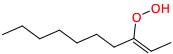

CCCCCCCC(OO)C(C)O[O] <=> C=CC(CCCCCCC)OO + [O]O


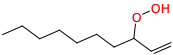

CCCCC(CCCCCO[O])OO <=> C=CCCCC(CCCC)OO + [O]O


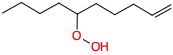

CCCCCCCCC(COO)O[O] <=> CCCCCCCC=CCOO + [O]O


CCCCCCCCC(COO)O[O] <=> CCCCCCCCC=COO + [O]O


CCCCCCCC(CCOO)O[O] <=> CCCCCCC=CCCOO + [O]O


CCCCCCCC(CCOO)O[O] <=> CCCCCCCC=CCOO + [O]O


CCCCC(CCCC(C)O[O])OO <=> CC=CCCC(CCCC)OO + [O]O


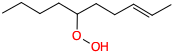

CCCCC(CCCC(C)O[O])OO <=> C=CCCCC(CCCC)OO + [O]O


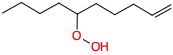

CCCCCC(CCC(C)OO)O[O] <=> CCCCC=CCCC(C)OO + [O]O


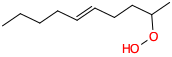

CCCCCC(CCC(C)OO)O[O] <=> CCCCCC=CCC(C)OO + [O]O


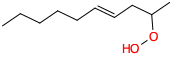

CCCCCCCCCC(O[O])OO <=> CCCCCCCCC=COO + [O]O


CCCCCC(CCCCO[O])OO <=> C=CCCC(CCCCC)OO + [O]O


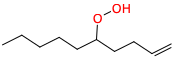

CCCCCC(CCC(C)O[O])OO <=> CC=CCC(CCCCC)OO + [O]O


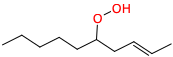

CCCCCC(CCC(C)O[O])OO <=> C=CCCC(CCCCC)OO + [O]O


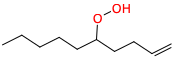

CCCCCC(CC(CC)OO)O[O] <=> CCCCCC=CC(CC)OO + [O]O


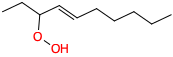

CCCCCC(CC(CC)OO)O[O] <=> CCCCC=CCC(CC)OO + [O]O


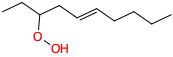

CCCCCCCC(CCO[O])OO <=> C=CC(CCCCCCC)OO + [O]O


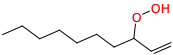

CCCCC(CCC(CC)OO)O[O] <=> CCCC=CCCC(CC)OO + [O]O


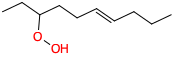

CCCCC(CCC(CC)OO)O[O] <=> CCCCC=CCC(CC)OO + [O]O


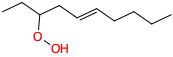

CCCC(CCCC(CC)OO)O[O] <=> CCC=CCCCC(CC)OO + [O]O


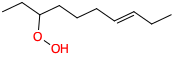

CCCC(CCCC(CC)OO)O[O] <=> CCCC=CCCC(CC)OO + [O]O


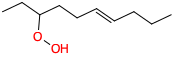

CCC(CCCCC(CC)OO)O[O] <=> CCC=CCCCC(CC)OO + [O]O


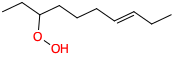

CCC(CCCCC(CC)OO)O[O] <=> CC=CCCCCC(CC)OO + [O]O


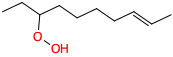

CCCCCCC(CCCOO)O[O] <=> CCCCCC=CCCCOO + [O]O


CCCCCCC(CCCOO)O[O] <=> CCCCCCC=CCCOO + [O]O


QeneOOH


{Molecule(smiles="CCC=CCCCCC(C)OO"),
 Molecule(smiles="CCCCCCC=C(CC)OO"),
 Molecule(smiles="CC=C(CCCCCCC)OO"),
 Molecule(smiles="CCCCCC=CC(CC)OO"),
 Molecule(smiles="C=CC(CCCCCCC)OO"),
 Molecule(smiles="C=CCCCC(CCCC)OO"),
 Molecule(smiles="CCCCCCCC=CCOO"),
 Molecule(smiles="CCCCCCCCC=COO"),
 Molecule(smiles="CCCCCCC=CCCOO"),
 Molecule(smiles="C=CCCC(CCCCC)OO"),
 Molecule(smiles="CCCCCCCC=C(C)OO"),
 Molecule(smiles="CCCCCCC=CC(C)OO"),
 Molecule(smiles="CC=CCC(CCCCC)OO"),
 Molecule(smiles="CCCCCC=C(CCC)OO"),
 Molecule(smiles="CCC=C(CCCCCC)OO"),
 Molecule(smiles="CCCCC=CC(CCC)OO"),
 Molecule(smiles="CCCCC=CCCCCOO"),
 Molecule(smiles="CCCC=CCC(CCC)OO"),
 Molecule(smiles="C=CCC(CCCCCC)OO"),
 Molecule(smiles="CCC=CCCC(CCC)OO"),
 Molecule(smiles="CCCC=CCCC(CC)OO"),
 Molecule(smiles="CCC=CCCCC(CC)OO"),
 Molecule(smiles="CC=CCCCCC(CC)OO"),
 Molecule(smiles="CCCCCC=CCC(C)OO"),
 Molecule(smiles="C=C(CCCCCCCC)OO"),
 Molecule(smiles="CCCC=CCCCC(C)OO"),
 Molecule(smiles="CCCCC=CCCC(C)OO"),
 Molecule

In [23]:
# HO2_Elimination_from_PeroxyRadical applied to QOOH makes an Alkene-OOH
print("Applying HO2_Elimination_from_PeroxyRadical")
for s in molecules['O2QOOH']:
    reactions = rmg.database.kinetics.generate_reactions_from_families(
        (s,), only_families='HO2_Elimination_from_PeroxyRadical')
    for r in reactions:
        print(r)
        m = r.products[0].molecule[0]
        display(m)
        molecules['QeneOOH'].add(m)
print('QeneOOH')
molecules['QeneOOH']

[H] + CCCCCCCCC(C)O[O] <=> CCCCCCCCC(C)OO


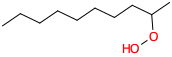

[H] + CCCCCCCC(CC)O[O] <=> CCCCCCCC(CC)OO


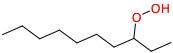

[H] + CCCCCC(CCCC)O[O] <=> CCCCCC(CCCC)OO


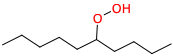

[H] + CCCCCCCCCCO[O] <=> CCCCCCCCCCOO


[H] + CCCCCCC(CCC)O[O] <=> CCCCCCC(CCC)OO


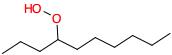

ROOH


{Molecule(smiles="CCCCCCCC(CC)OO"),
 Molecule(smiles="CCCCCC(CCCC)OO"),
 Molecule(smiles="CCCCCCCCC(C)OO"),
 Molecule(smiles="CCCCCCCCCCOO"),
 Molecule(smiles="CCCCCCC(CCC)OO")}

In [24]:
# Another chain-brainching route.
# Add H to RO2 to make ROOH (which in the next cell becomes RO and OH)
# This would happen by abstracting an H from some fuel, but 
# here we can make the same species by just adding an H atom.
h = list(molecules['H'])[0]
for s in molecules['ROO']:
    reactions = rmg.database.kinetics.generate_reactions_from_families((s,h), only_families='R_Recombination')
    for r in reactions:
        print(r)
        m = r.products[0].molecule[0]
        display(m)
        molecules['ROOH'].add(m)
print('ROOH')
molecules['ROOH']

[OH] + CCCCCCCC([O])CC <=> CCCCCCCC(CC)OO


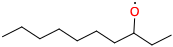

[O]O + CC[CH]CCCCCCC <=> CCCCCCCC(CC)OO
[H] + CCCCCCCC(CC)O[O] <=> CCCCCCCC(CC)OO
CC[CH]OO + [CH2]CCCCCC <=> CCCCCCCC(CC)OO
CCCCCCC[CH]OO + C[CH2] <=> CCCCCCCC(CC)OO
CCCCCCC[C](CC)OO + [H] <=> CCCCCCCC(CC)OO
[CH2]C(CC)OO + [CH2]CCCCC <=> CCCCCCCC(CC)OO
CCCCCC[CH]C(CC)OO + [H] <=> CCCCCCCC(CC)OO
[CH2]CCCC(CC)OO + [CH2]CC <=> CCCCCCCC(CC)OO
[CH2]CCCCC(CC)OO + C[CH2] <=> CCCCCCCC(CC)OO
CC[CH]CCCCC(CC)OO + [H] <=> CCCCCCCC(CC)OO
[CH2]CCC(CC)OO + [CH2]CCC <=> CCCCCCCC(CC)OO
CCC[CH]CCCC(CC)OO + [H] <=> CCCCCCCC(CC)OO
[CH2]CC(CC)OO + [CH2]CCCC <=> CCCCCCCC(CC)OO
CCCC[CH]CCC(CC)OO + [H] <=> CCCCCCCC(CC)OO
CCCCC[CH]CC(CC)OO + [H] <=> CCCCCCCC(CC)OO
[CH2]C(CCCCCCC)OO + [CH3] <=> CCCCCCCC(CC)OO
C[CH]C(CCCCCCC)OO + [H] <=> CCCCCCCC(CC)OO
[CH2]CCCCCC(CC)OO + [CH3] <=> CCCCCCCC(CC)OO
C[CH]CCCCCC(CC)OO + [H] <=> CCCCCCCC(CC)OO
[CH2]CCCCCCC(CC)OO + [H] <=> CCCCCCCC(CC)OO
[CH2]CC(CCCCCCC)OO + [H] <=> CCCCCCCC(CC)OO
[OH] + CCCCCC([O])CCCC <=> CCCCCC(CCCC)OO


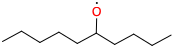

[O]O + CCCC[CH]CCCCC <=> CCCCCC(CCCC)OO
[H] + CCCCCC(CCCC)O[O] <=> CCCCCC(CCCC)OO
CCCC[CH]OO + [CH2]CCCC <=> CCCCCC(CCCC)OO
CCCCC[CH]OO + [CH2]CCC <=> CCCCCC(CCCC)OO
CCCCC[C](CCCC)OO + [H] <=> CCCCCC(CCCC)OO
[CH2]C(CCCC)OO + [CH2]CCC <=> CCCCCC(CCCC)OO
CCCC[CH]C(CCCC)OO + [H] <=> CCCCCC(CCCC)OO
[CH2]C(CCCCC)OO + [CH2]CC <=> CCCCCC(CCCC)OO
CCC[CH]C(CCCCC)OO + [H] <=> CCCCCC(CCCC)OO
[CH2]CC(CCCC)OO + [CH2]CC <=> CCCCCC(CCCC)OO
[CH2]CCC(CCCC)OO + C[CH2] <=> CCCCCC(CCCC)OO
CC[CH]CCC(CCCC)OO + [H] <=> CCCCCC(CCCC)OO
CCC[CH]CC(CCCC)OO + [H] <=> CCCCCC(CCCC)OO
[CH2]CC(CCCCC)OO + C[CH2] <=> CCCCCC(CCCC)OO
CC[CH]CC(CCCCC)OO + [H] <=> CCCCCC(CCCC)OO
[CH2]CCCC(CCCC)OO + [CH3] <=> CCCCCC(CCCC)OO
C[CH]CCCC(CCCC)OO + [H] <=> CCCCCC(CCCC)OO
[CH2]CCC(CCCCC)OO + [CH3] <=> CCCCCC(CCCC)OO
C[CH]CCC(CCCCC)OO + [H] <=> CCCCCC(CCCC)OO
[CH2]CCCCC(CCCC)OO + [H] <=> CCCCCC(CCCC)OO
[CH2]CCCC(CCCCC)OO + [H] <=> CCCCCC(CCCC)OO
[OH] + CCCCCCCCC(C)[O] <=> CCCCCCCCC(C)OO


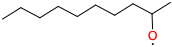

[O]O + C[CH]CCCCCCCC <=> CCCCCCCCC(C)OO
[H] + CCCCCCCCC(C)O[O] <=> CCCCCCCCC(C)OO
C[CH]OO + [CH2]CCCCCCC <=> CCCCCCCCC(C)OO
CCCCCCCC[CH]OO + [CH3] <=> CCCCCCCCC(C)OO
CCCCCCCC[C](C)OO + [H] <=> CCCCCCCCC(C)OO
[CH2]C(C)OO + [CH2]CCCCCC <=> CCCCCCCCC(C)OO
CCCCCCC[CH]C(C)OO + [H] <=> CCCCCCCCC(C)OO
[CH2]CCCCC(C)OO + [CH2]CC <=> CCCCCCCCC(C)OO
[CH2]CCCCCC(C)OO + C[CH2] <=> CCCCCCCCC(C)OO
CC[CH]CCCCCC(C)OO + [H] <=> CCCCCCCCC(C)OO
[CH2]CCCC(C)OO + [CH2]CCC <=> CCCCCCCCC(C)OO
CCC[CH]CCCCC(C)OO + [H] <=> CCCCCCCCC(C)OO
[CH2]CCC(C)OO + [CH2]CCCC <=> CCCCCCCCC(C)OO
CCCC[CH]CCCC(C)OO + [H] <=> CCCCCCCCC(C)OO
[CH2]CC(C)OO + [CH2]CCCCC <=> CCCCCCCCC(C)OO
CCCCC[CH]CCC(C)OO + [H] <=> CCCCCCCCC(C)OO
CCCCCC[CH]CC(C)OO + [H] <=> CCCCCCCCC(C)OO
[CH2]CCCCCCC(C)OO + [CH3] <=> CCCCCCCCC(C)OO
C[CH]CCCCCCC(C)OO + [H] <=> CCCCCCCCC(C)OO
[CH2]C(CCCCCCCC)OO + [H] <=> CCCCCCCCC(C)OO
[CH2]CCCCCCCC(C)OO + [H] <=> CCCCCCCCC(C)OO
[OH] + CCCCCCCCCC[O] <=> CCCCCCCCCCOO


[O]O + [CH2]CCCCCCCCC <=> CCCCCCCCCCOO
[H] + CCCCCCCCCCO[O] <=> CCCCCCCCCCOO
[CH2]CCCCCCOO + [CH2]CC <=> CCCCCCCCCCOO
[CH2]CCCCCCCOO + C[CH2] <=> CCCCCCCCCCOO
CC[CH]CCCCCCCOO + [H] <=> CCCCCCCCCCOO
[CH2]CCCCCOO + [CH2]CCC <=> CCCCCCCCCCOO
CCC[CH]CCCCCCOO + [H] <=> CCCCCCCCCCOO
[CH2]CCCCOO + [CH2]CCCC <=> CCCCCCCCCCOO
CCCC[CH]CCCCCOO + [H] <=> CCCCCCCCCCOO
[CH2]CCCOO + [CH2]CCCCC <=> CCCCCCCCCCOO
CCCCC[CH]CCCCOO + [H] <=> CCCCCCCCCCOO
[CH2]CCOO + [CH2]CCCCCC <=> CCCCCCCCCCOO
CCCCCC[CH]CCCOO + [H] <=> CCCCCCCCCCOO
[CH2]COO + [CH2]CCCCCCC <=> CCCCCCCCCCOO
CCCCCCC[CH]CCOO + [H] <=> CCCCCCCCCCOO
[CH2]OO + [CH2]CCCCCCCC <=> CCCCCCCCCCOO
CCCCCCCC[CH]COO + [H] <=> CCCCCCCCCCOO
[CH2]CCCCCCCCOO + [CH3] <=> CCCCCCCCCCOO
C[CH]CCCCCCCCOO + [H] <=> CCCCCCCCCCOO
CCCCCCCCC[CH]OO + [H] <=> CCCCCCCCCCOO
[CH2]CCCCCCCCCOO + [H] <=> CCCCCCCCCCOO
[OH] + CCCCCCC([O])CCC <=> CCCCCCC(CCC)OO


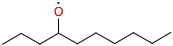

[O]O + CCC[CH]CCCCCC <=> CCCCCCC(CCC)OO
[H] + CCCCCCC(CCC)O[O] <=> CCCCCCC(CCC)OO
CCC[CH]OO + [CH2]CCCCC <=> CCCCCCC(CCC)OO
CCCCCC[CH]OO + [CH2]CC <=> CCCCCCC(CCC)OO
CCCCCC[C](CCC)OO + [H] <=> CCCCCCC(CCC)OO
[CH2]C(CCC)OO + [CH2]CCCC <=> CCCCCCC(CCC)OO
CCCCC[CH]C(CCC)OO + [H] <=> CCCCCCC(CCC)OO
[CH2]C(CCCCCC)OO + C[CH2] <=> CCCCCCC(CCC)OO
CC[CH]C(CCCCCC)OO + [H] <=> CCCCCCC(CCC)OO
[CH2]CCC(CCC)OO + [CH2]CC <=> CCCCCCC(CCC)OO
[CH2]CCCC(CCC)OO + C[CH2] <=> CCCCCCC(CCC)OO
CC[CH]CCCC(CCC)OO + [H] <=> CCCCCCC(CCC)OO
[CH2]CC(CCC)OO + [CH2]CCC <=> CCCCCCC(CCC)OO
CCC[CH]CCC(CCC)OO + [H] <=> CCCCCCC(CCC)OO
CCCC[CH]CC(CCC)OO + [H] <=> CCCCCCC(CCC)OO
[CH2]CCCCC(CCC)OO + [CH3] <=> CCCCCCC(CCC)OO
C[CH]CCCCC(CCC)OO + [H] <=> CCCCCCC(CCC)OO
[CH2]CC(CCCCCC)OO + [CH3] <=> CCCCCCC(CCC)OO
C[CH]CC(CCCCCC)OO + [H] <=> CCCCCCC(CCC)OO
[CH2]CCCCCC(CCC)OO + [H] <=> CCCCCCC(CCC)OO
[CH2]CCC(CCCCCC)OO + [H] <=> CCCCCCC(CCC)OO


RO


{Molecule(smiles="CCCCCCCC([O])CC"),
 Molecule(smiles="CCCCCCC([O])CCC"),
 Molecule(smiles="CCCCCCCCCC[O]"),
 Molecule(smiles="CCCCCCCCC(C)[O]"),
 Molecule(smiles="CCCCCC([O])CCCC")}

In [25]:
# The ROOH then becomes RO and OH which is chain-brainching
for s in molecules['ROOH']:
    reactions = rmg.database.kinetics.generate_reactions_from_families((s,), only_families='R_Recombination')
    for r in reactions:
        print(r)
        m1 = r.reactants[0].molecule[0]
        m2 = r.reactants[1].molecule[0]
        
        if m1.get_formula() == 'HO':
            display(m2)
            molecules['RO'].add(m2)
            molecules['OH'].add(m1)
        if m2.get_formula() == 'HO':
            display(m1)
            molecules['RO'].add(m1)
            molecules['OH'].add(m2)

print("\n\nRO")
molecules['RO']

Applying intra_OH_migration to QOOH
C[CH]CCC(CCCCC)OO <=> CCCCCC([O])CCC(C)O


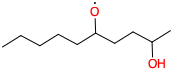

CCCCCCCCC[CH]OO <=> CCCCCCCCCC([O])O


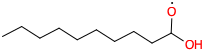

CCCCCCCC[CH]COO <=> CCCCCCCCC(O)C[O]


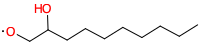

CCCCCCC[CH]CCOO <=> CCCCCCCC(O)CC[O]


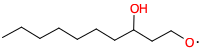

CCCCCC[CH]CCCOO <=> CCCCCCC(O)CCC[O]


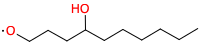

CCCCCC[CH]CC(C)OO <=> CCCCCCC(O)CC(C)[O]


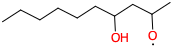

CCCCC[CH]CCC(C)OO <=> CCCCCC(O)CCC(C)[O]


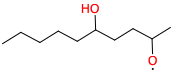

CCCCCCCC[C](C)OO <=> CCCCCCCCC(C)([O])O


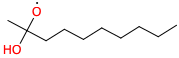

[CH2]C(CCCCCCCC)OO <=> CCCCCCCCC([O])CO


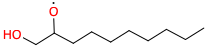

CCCCCCC[C](CC)OO <=> CCCCCCCC([O])(O)CC


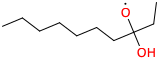

CCCCCC[CH]C(CC)OO <=> CCCCCCC(O)C([O])CC


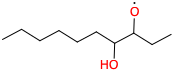

C[CH]C(CCCCCCC)OO <=> CCCCCCCC([O])C(C)O


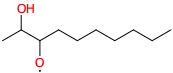

CCCCC[CH]CC(CC)OO <=> CCCCCC(O)CC([O])CC


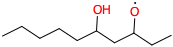

[CH2]CC(CCCCCCC)OO <=> CCCCCCCC([O])CCO


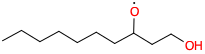

CCCC[CH]CCC(CC)OO <=> CCCCC(O)CCC([O])CC


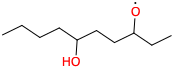

CCCCC[C](CCCC)OO <=> CCCCCC([O])(O)CCCC


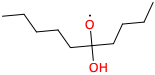

CCCC[CH]C(CCCC)OO <=> CCCCC([O])C(O)CCCC


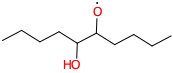

CCC[CH]C(CCCCC)OO <=> CCCCCC([O])C(O)CCC


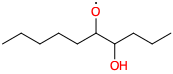

CCC[CH]CC(CCCC)OO <=> CCCCC([O])CC(O)CCC


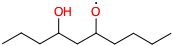

CCCCCCC[CH]C(C)OO <=> CCCCCCCC(O)C(C)[O]


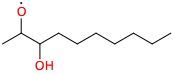

CC[CH]CC(CCCCC)OO <=> CCCCCC([O])CC(O)CC


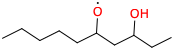

CCCCCC[C](CCC)OO <=> CCCCCCC([O])(O)CCC


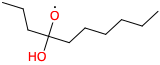

CCCCC[CH]C(CCC)OO <=> CCCCCC(O)C([O])CCC


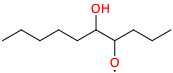

CC[CH]C(CCCCCC)OO <=> CCCCCCC([O])C(O)CC


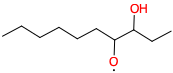

CCCC[CH]CC(CCC)OO <=> CCCCC(O)CC([O])CCC


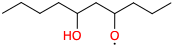

C[CH]CC(CCCCCC)OO <=> CCCCCCC([O])CC(C)O


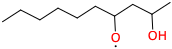

CCC[CH]CCC(CCC)OO <=> CCCC([O])CCC(O)CCC


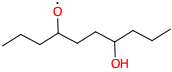

[CH2]CCC(CCCCCC)OO <=> CCCCCCC([O])CCCO


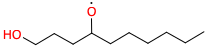

CC[CH]CCC(CCCC)OO <=> CCCCC([O])CCC(O)CC


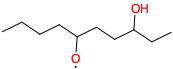

In [26]:
# intra_OH_migration can happen to QOOH
# Not sure it's helpful for low-T chemistry
# So we won't actually save them, but this is what they'd look like
print("Applying intra_OH_migration to QOOH")
for s in molecules['QOOH']:
    reactions = rmg.database.kinetics.generate_reactions_from_families((s,), only_families='intra_OH_migration')
    for r in reactions:
        print(r)
        m = r.products[0].molecule[0]
        display(m)
        # molecules['weird'].add(m)

In [27]:
# Here is what we've made
molecules

defaultdict(set,
            {'fuel': {Molecule(smiles="CCCCCCCCCC")},
             'H': {Molecule(smiles="[H]")},
             'R': {Molecule(smiles="CCCC[CH]CCCCC"),
              Molecule(smiles="CCC[CH]CCCCCC"),
              Molecule(smiles="[CH2]CCCCCCCCC"),
              Molecule(smiles="C[CH]CCCCCCCC"),
              Molecule(smiles="CC[CH]CCCCCCC")},
             'O2': {Molecule(smiles="[O][O]")},
             'ROO': {Molecule(smiles="CCCCCCCCC(C)O[O]"),
              Molecule(smiles="CCCCCCCC(CC)O[O]"),
              Molecule(smiles="CCCCCC(CCCC)O[O]"),
              Molecule(smiles="CCCCCCCCCCO[O]"),
              Molecule(smiles="CCCCCCC(CCC)O[O]")},
             'QOOH': {Molecule(smiles="C[CH]CCC(CCCCC)OO"),
              Molecule(smiles="C[CH]CCCC(CCCC)OO"),
              Molecule(smiles="[CH2]CCCC(CCCCC)OO"),
              Molecule(smiles="[CH2]CCCCC(CCCC)OO"),
              Molecule(smiles="CCCCCCCCC[CH]OO"),
              Molecule(smiles="CCCCCCCC[CH]COO"),
           

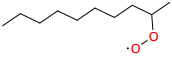

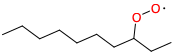

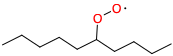

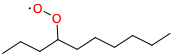

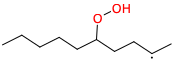

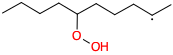

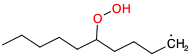

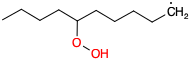

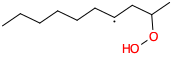

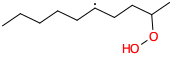

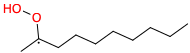

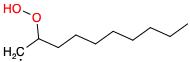

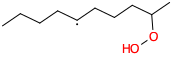

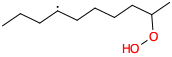

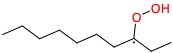

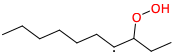

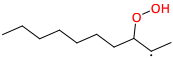

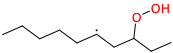

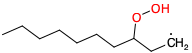

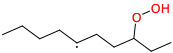

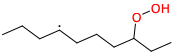

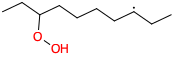

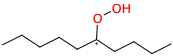

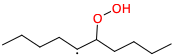

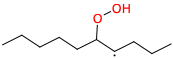

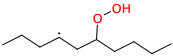

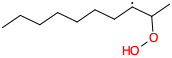

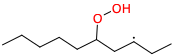

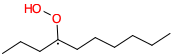

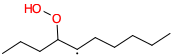

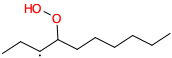

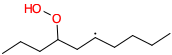

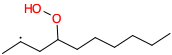

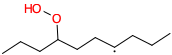

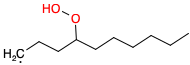

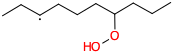

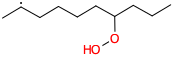

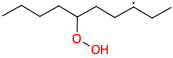

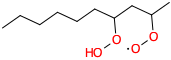

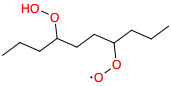

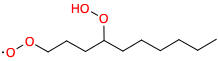

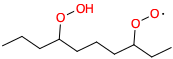

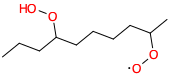

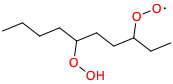

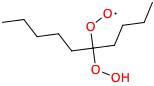

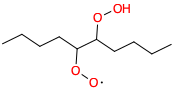

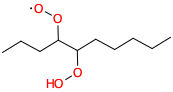

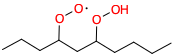

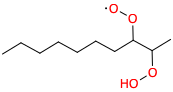

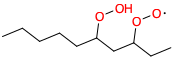

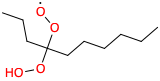

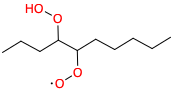

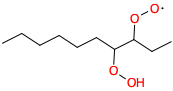

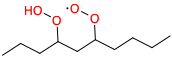

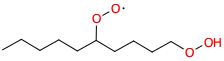

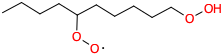

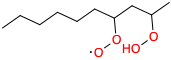

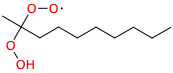

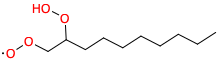

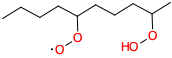

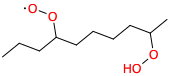

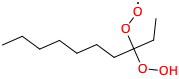

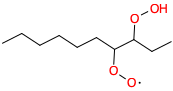

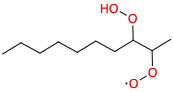

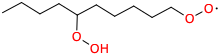

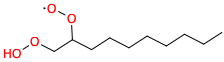

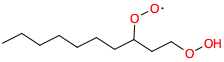

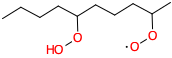

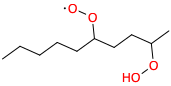

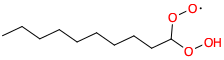

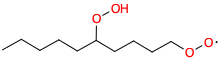

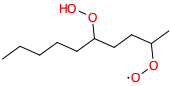

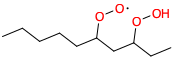

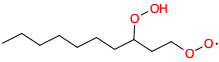

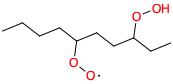

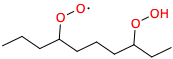

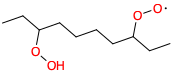

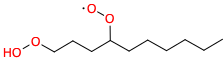

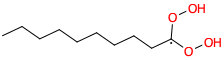

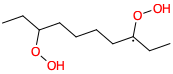

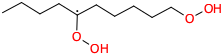

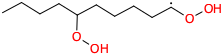

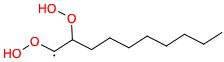

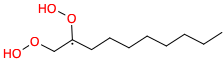

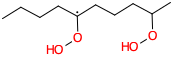

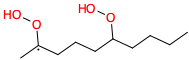

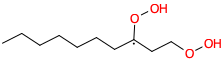

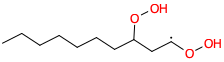

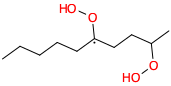

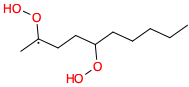

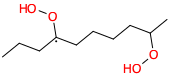

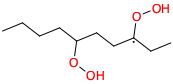

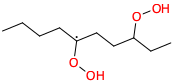

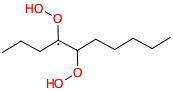

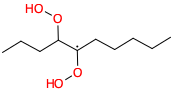

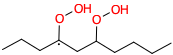

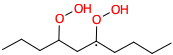

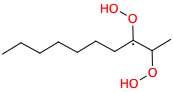

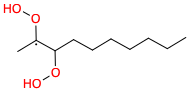

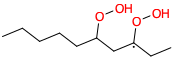

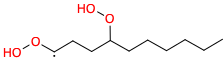

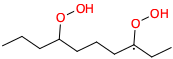

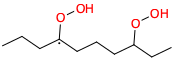

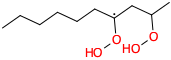

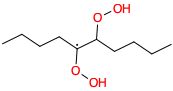

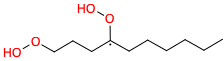

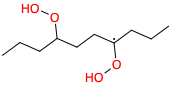

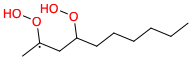

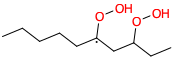

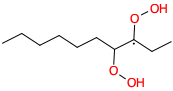

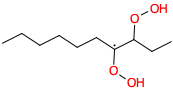

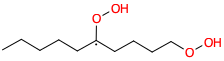

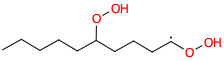

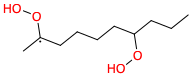

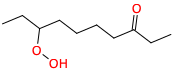

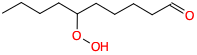

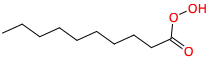

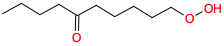

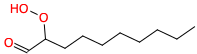

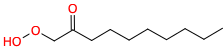

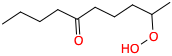

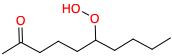

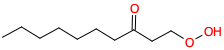

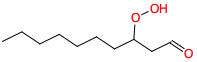

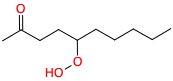

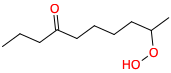

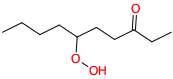

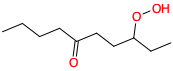

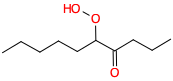

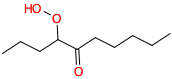

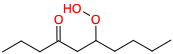

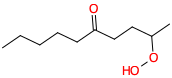

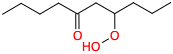

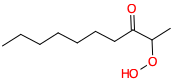

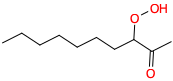

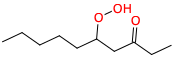

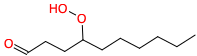

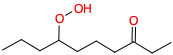

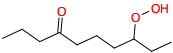

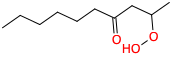

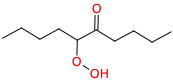

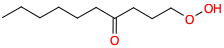

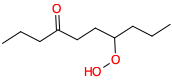

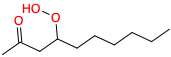

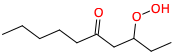

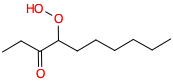

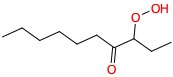

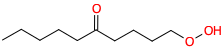

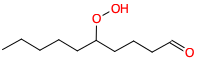

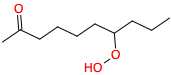

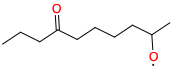

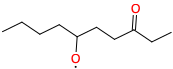

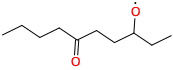

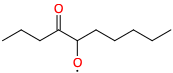

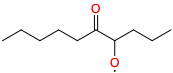

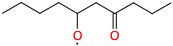

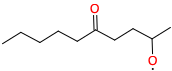

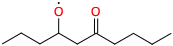

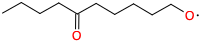

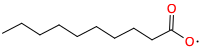

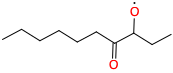

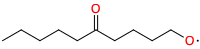

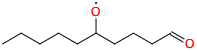

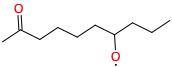

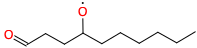

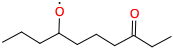

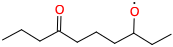

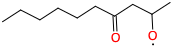

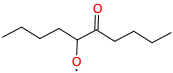

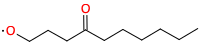

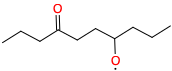

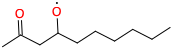

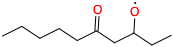

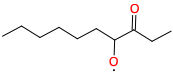

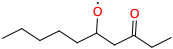

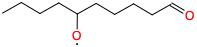

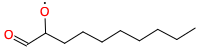

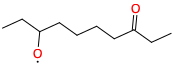

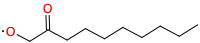

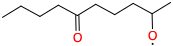

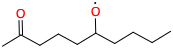

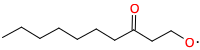

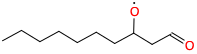

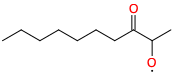

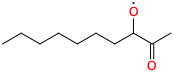

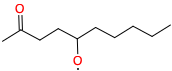

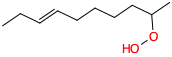

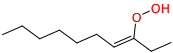

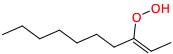

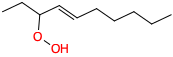

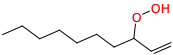

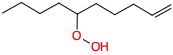

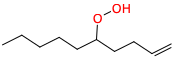

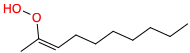

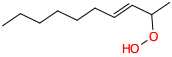

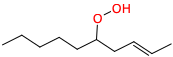

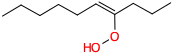

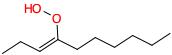

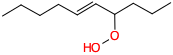

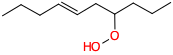

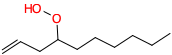

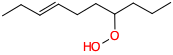

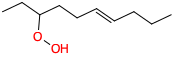

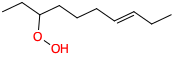

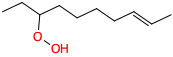

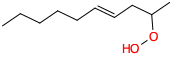

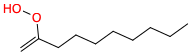

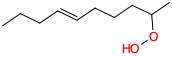

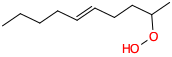

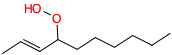

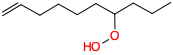

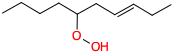

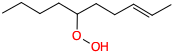

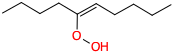

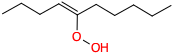

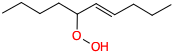

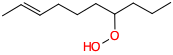

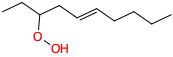

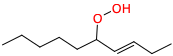

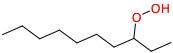

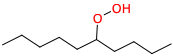

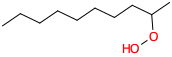

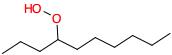

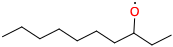

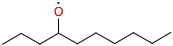

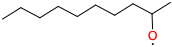

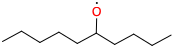

In [28]:
_=[ display(m) for s in molecules.values() for m in s]

In [29]:
molecules.keys()

dict_keys(['fuel', 'H', 'R', 'O2', 'ROO', 'QOOH', 'O2QOOH', 'HOOQjOOH', 'ketohydroperoxide', 'alkoxy_radical', 'OH', 'QeneOOH', 'ROOH', 'RO'])

In [30]:
import datetime
datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2019-11-07 10:49:01'

In [31]:

# Print them out for an RMG input file

print(f"""
######################################
# RMG input file species block
# Generated on {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
# to help discover the low temperature combustion of:
#   {', '.join([m.to_smiles() for m in molecules['fuel']])}
######################################
""")

special = 'OH H O2'.split()

print('#'*30)
print(f'# Small molecules')
for name in special:
    mols = molecules[name]
    for i, m in enumerate(mols):
        print(f"species(label='{name}', reactive=True, structure=SMILES('{m.to_smiles()}'))")
        
for name,mols in molecules.items():
    
    if name in special:
        continue
    
    print('#'*30)
    print(f'# {name}')
    for i,m in enumerate(mols):
        print(f"species(label='{name}_{i+1}', reactive=True, structure=SMILES('{m.to_smiles()}'))")
    


######################################
# RMG input file species block
# Generated on 2019-11-07 10:49:01
# to help discover the low temperature combustion of:
#   CCCCCCCCCC
######################################

##############################
# Small molecules
species(label='OH', reactive=True, structure=SMILES('[OH]'))
species(label='H', reactive=True, structure=SMILES('[H]'))
species(label='O2', reactive=True, structure=SMILES('[O][O]'))
##############################
# fuel
species(label='fuel_1', reactive=True, structure=SMILES('CCCCCCCCCC'))
##############################
# R
species(label='R_1', reactive=True, structure=SMILES('CCCC[CH]CCCCC'))
species(label='R_2', reactive=True, structure=SMILES('CCC[CH]CCCCCC'))
species(label='R_3', reactive=True, structure=SMILES('[CH2]CCCCCCCCC'))
species(label='R_4', reactive=True, structure=SMILES('C[CH]CCCCCCCC'))
species(label='R_5', reactive=True, structure=SMILES('CC[CH]CCCCCCC'))
##############################
# ROO
species(label='R

species(label='alkoxy_radical_32', reactive=True, structure=SMILES('CCCCCCCC(=O)CC[O]'))
species(label='alkoxy_radical_33', reactive=True, structure=SMILES('CCCCCCCC([O])CC=O'))
species(label='alkoxy_radical_34', reactive=True, structure=SMILES('CCCCCCCC(=O)C(C)[O]'))
species(label='alkoxy_radical_35', reactive=True, structure=SMILES('CCCCCCCC([O])C(C)=O'))
species(label='alkoxy_radical_36', reactive=True, structure=SMILES('CCCCCC([O])CCC(C)=O'))
##############################
# QeneOOH
species(label='QeneOOH_1', reactive=True, structure=SMILES('CCC=CCCCCC(C)OO'))
species(label='QeneOOH_2', reactive=True, structure=SMILES('CCCCCCC=C(CC)OO'))
species(label='QeneOOH_3', reactive=True, structure=SMILES('CC=C(CCCCCCC)OO'))
species(label='QeneOOH_4', reactive=True, structure=SMILES('CCCCCC=CC(CC)OO'))
species(label='QeneOOH_5', reactive=True, structure=SMILES('C=CC(CCCCCCC)OO'))
species(label='QeneOOH_6', reactive=True, structure=SMILES('C=CCCCC(CCCC)OO'))
species(label='QeneOOH_7', reactiv